<a href="https://colab.research.google.com/github/FedericoRaschiatore0123/Neural_Network/blob/main/Adversarial_Diffusion_Distillation_Last_Version.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Cose da fare

L'obbiettivo di tutto il modello è quello di rendere l'ADD student il più bravo possibile  ma con un numero molto piccolo di istanti in cui viene fatto il denoising.
Utilizziamo quindi lo stesso modello per il teacher  e poer lo student ma allo student diamo solo da 1 a 4 istanti di denoising e lo aggiorniamo con la loss in modo che impari a predire le immagini giuste nel minor tempo possibile

*   Importare il dataset e preprocessing
*   Realizzare il Discriminator(ViT) e pretrainarlo da zero e salvarne i weights, importarne i weights e visto ceh le performance saranno scarse prova ad utilizzare un vit_b_16 pretrainato
*   Realizzare il forward process che aggiunge il noise all'immagine
*   Realizzare il denoise process (ADD-Student) che toglie il rumore dell'immagine e genera la nuova immagine
*   Calcolare la Discriminator Loss (condizionarla all'immagine iniziale utilizzando un dino model)
*   Riaggiungere il rumore all'immagine generata dallo Student
*   Utilizzare il DM-Teacher per ricostruire una nuova immagine(ricordati che non deve essere trainato)
*   Calcolare la distillation Loss
##RISOLVERE I PROBLEMI


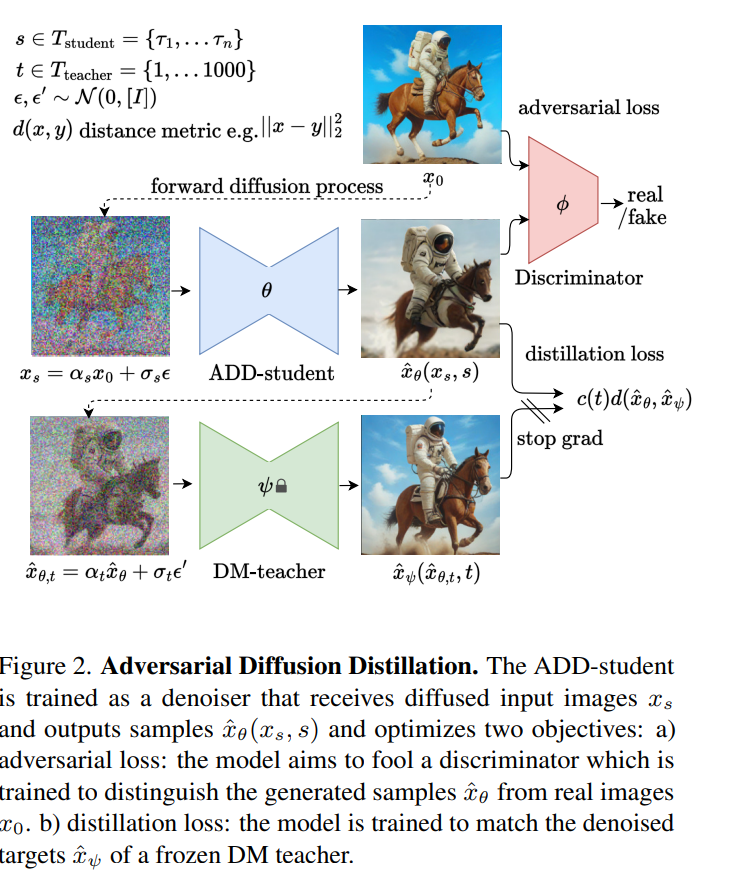









https://static1.squarespace.com/static/6213c340453c3f502425776e/t/65663480a92fba51d0e1023f/1701197769659/adversarial_diffusion_distillation.pdf

https://arxiv.org/pdf/2006.11239.pdf


#Dataset

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U einops datasets matplotlib tqdm

import math
import torch as torch
from inspect import isfunction
from functools import partial

%matplotlib inline
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from einops import rearrange
from torch import einsum
import torch.nn.functional as F
import torchvision
import torchvision.transforms as tt
import matplotlib.pyplot as plt
import os
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import random
from torchvision import datasets
from torch.optim import Adam

BATCH_SIZE=128

device = "cuda" if torch.cuda.is_available() else "cpu"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 772.1 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 507.1/507.1 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 52.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 17.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
lida 0.0.10 requires fastapi, which is not installed.
lida 0.0.10 requires kaleido, which is not installed.
lida 0.0.10 requires python-multipart, which is not installed.
lida 0.0.10 requires uvicorn, which is not installed.


In [3]:
transform = tt.Compose([
            tt.RandomHorizontalFlip(),
            tt.ToTensor(),
            tt.Lambda(lambda t: (t * 2) - 1)
])

dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# define function
def transforms(examples):
   examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
   del examples["image"]

   return examples

print(dataset)
# create dataloader
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)


100%|██████████| 26421880/26421880 [00:01<00:00, 15522932.45it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 265427.56it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:00<00:00, 4955573.21it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 5901141.57it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Lambda()
           )


In [4]:
def show_batch(dl):
    for images in dl:
        fig, ax = plt.subplots(figsize=(24, 24))
        ax.set_xticks([]); ax.set_yticks([])
        print(images[0].shape)
        ax.imshow(make_grid(images[:32][0], nrow=8).permute(1, 2, 0))
        break

torch.Size([128, 1, 28, 28])


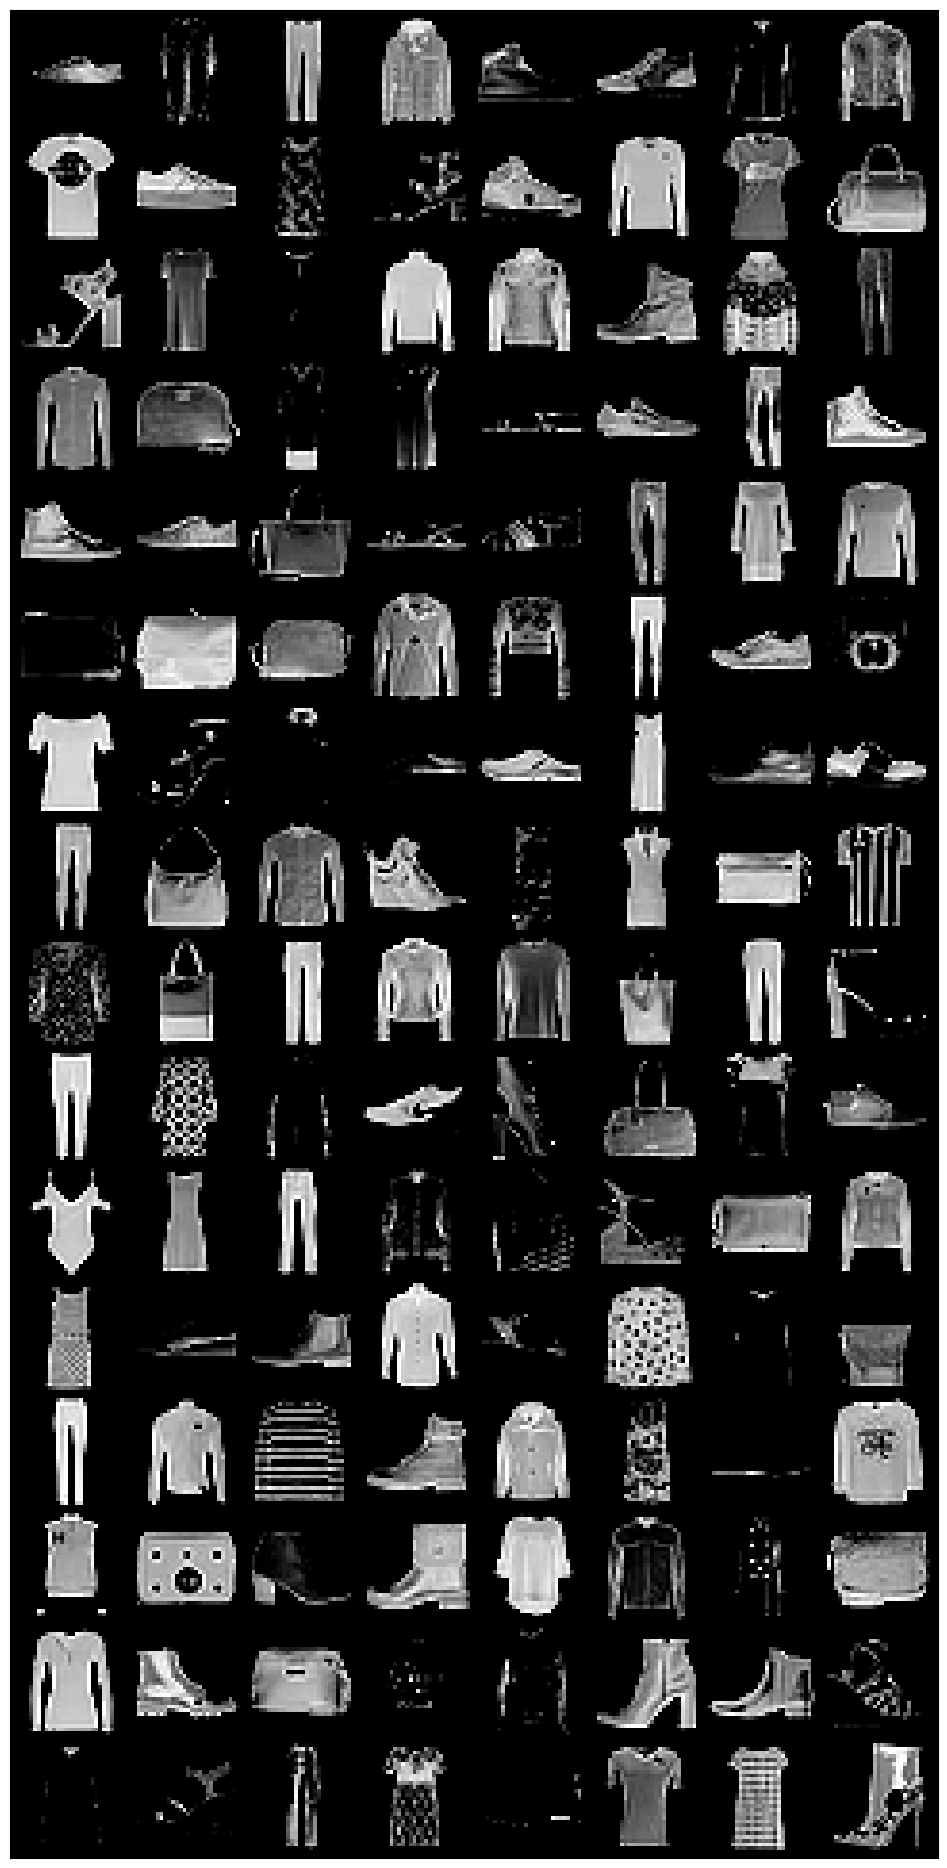

In [5]:
show_batch(dataloader)

In [6]:
#time schedule
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start, beta_end, timesteps)

# forward diffusion
def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)

    sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod, t, x_start.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x_start.shape
    )

    return sqrt_alphas_cumprod_t * x_start + sqrt_one_minus_alphas_cumprod_t * noise, noise

timesteps = 500

# define beta schedule
betas = linear_beta_schedule(timesteps=timesteps)

# define alphas
alphas = 1. -  betas
alphas_cumprod = torch.cumprod(alphas, axis=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)

# calculations for diffusion q(x_t | x_{t-1}) and others
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)

# calculations for posterior q(x_{t-1} | x_t, x_0)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

def extract(a, t, x_shape):
    batch_size = t.shape[0]
    out = a.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

In [7]:
IMG_SIZE = 28

def show_tensor_image(image):
    reverse_transforms = tt.Compose([
        tt.Lambda(lambda t: (t + 1) / 2),
        tt.Lambda(lambda t: t.permute(1, 2, 0)), # CHW to HWC
        tt.Lambda(lambda t: t * 255.),
        tt.Lambda(lambda t: t.numpy().astype(np.uint8)),
        tt.ToPILImage(),
    ])

    # Take first image of batch
    if len(image.shape) == 4:
        image = image[0, :, :, :]
    plt.imshow(reverse_transforms(image))


torch.Size([128, 1, 28, 28])


<ipython-input-8-f27da4a9ee29>:12: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(1, num_images+1, int(idx/stepsize) + 1)


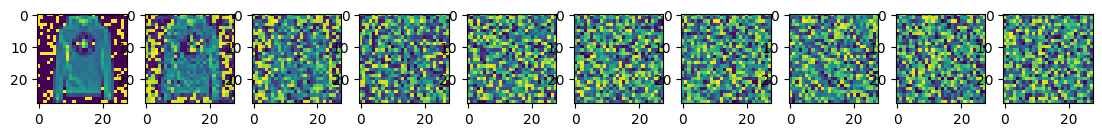

In [8]:
# Simulate forward diffusion
image = next(iter(dataloader))[0]
print(image.shape)

plt.figure(figsize=(15,15))
plt.axis('off')
num_images = 10
stepsize = int(timesteps/num_images)

for idx in range(1, timesteps, stepsize):
    t = torch.Tensor([idx]).type(torch.int64)
    plt.subplot(1, num_images+1, int(idx/stepsize) + 1)
    img, noise = q_sample(image, t)
    show_tensor_image(img)

# UNet

La UNet viene utilizzata per fare in modo che il modello impari solo le parti più importanti dell'immagini tralasciando i dettagli



##UNeT

In [9]:
#Utilities

def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)

class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

In [10]:
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1) #concatenazione
        return embeddings

In [11]:
class UNet_Block(nn.Module):
  def __init__(self, dim_input, dim_output, groups=4):
    super().__init__()
    self.proj = nn.Conv2d(dim_input, dim_output, 3, padding = 1)
    self.normalization= nn.GroupNorm( groups, dim_output)
    self.act= nn.SiLU()

  def forward(self, x):
    x = self.proj(x)
    x = self.normalization(x)
    x = self.act(x)

    return x

class UNet_ResNet(nn.Module):
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=4):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = UNet_Block(dim, dim_out, groups=groups)
        self.block2 = UNet_Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)

DEVI UNIFICARE QUESTA ATTENTION CON L'ALTRA

In [12]:
class Attention(nn.Module):
    def __init__(self, dim, num_heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.num_heads = num_heads
        hidden_dim = dim_head * num_heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.num_heads), qkv
        )
        #batch, num_heads, dim_features, x, y
        #organizza le informazioni ottenute dalla proiezione lineare in q, k, e v nel formato appropriato
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k) #specifica come fare la moltiplicazione tra il vettore q (batch, num_heads, dim_features, index(i)) e k(batch, num_heads, dim_features, index(j))
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)


class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1),
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)

In [13]:
class Unet(nn.Module):
    def __init__(
        self,
        dim,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=1,#rgb
        with_time_emb=True,
        resnet_block_groups=4,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)] #dim * [1,2,4,8]
        in_out = list(zip(dims[:-1], dims[1:]))  #dim * [1,2,4,8,4,2,1]

        block_klass = partial(UNet_ResNet, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),


                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )


    def forward(self, x, time):
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        return self.final_conv(x)

##Train

In [14]:
# load dataset from the hub
image_size = 28
channels = 1
batch_size = 128

device = "cuda" if torch.cuda.is_available() else "cpu"

diffusion_model = Unet(
    dim=image_size,
    channels=channels,
    dim_mults=(1, 2, 4,)
)
diffusion_model.to(device)


In [15]:
from torchvision.utils import save_image
from pathlib import Path

def num_to_groups(num, divisor):
    groups = num // divisor
    remainder = num % divisor
    arr = [divisor] * groups
    if remainder > 0:
        arr.append(remainder)
    return arr

epochs = 10
results_folder = Path("./results")
results_folder.mkdir(exist_ok = True)
save_and_sample_every = 100

optimizer = Adam(diffusion_model.parameters(), lr=1e-4)
for epoch in range(epochs):
    for step, batch in enumerate(dataloader):
      optimizer.zero_grad()

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      # Algorithm 1 line 3: sample t uniformally for every example in the batch
      t = torch.randint(0, timesteps, (batch_size,), device=device).long()

      #genera sample e calcola loss

      noise=torch.randn_like(batch) #crea rumore con la stessa dimensione del batch
      x_noisy = q_sample(x_start=batch, t=t, noise=noise)
      predicted_noise = diffusion_model(x_noisy[0], t)

      loss = F.smooth_l1_loss(noise, predicted_noise)

      if step % 100 == 0:
        print("Epoch: " + str(epoch)+ "   Loss:", loss.item())

      loss.backward()
      optimizer.step()

Epoch: 0   Loss: 0.5290239453315735
Epoch: 0   Loss: 0.16308358311653137
Epoch: 0   Loss: 0.10811202973127365
Epoch: 0   Loss: 0.08708696812391281
Epoch: 0   Loss: 0.07692233473062515
Epoch: 1   Loss: 0.06130995973944664
Epoch: 1   Loss: 0.053509894758462906
Epoch: 1   Loss: 0.06945096701383591
Epoch: 1   Loss: 0.05670250579714775
Epoch: 1   Loss: 0.05653775855898857
Epoch: 2   Loss: 0.04866471141576767
Epoch: 2   Loss: 0.043532125651836395
Epoch: 2   Loss: 0.06434402614831924
Epoch: 2   Loss: 0.053396135568618774
Epoch: 2   Loss: 0.04296544939279556
Epoch: 3   Loss: 0.05055181309580803
Epoch: 3   Loss: 0.03941433131694794
Epoch: 3   Loss: 0.04342309758067131
Epoch: 3   Loss: 0.038135770708322525
Epoch: 3   Loss: 0.0363847017288208
Epoch: 4   Loss: 0.03771227225661278
Epoch: 4   Loss: 0.0455474928021431
Epoch: 4   Loss: 0.04341288283467293
Epoch: 4   Loss: 0.03539034724235535
Epoch: 4   Loss: 0.04486093670129776
Epoch: 5   Loss: 0.04656330496072769
Epoch: 5   Loss: 0.03881467133760452


In [156]:
path = '/content/drive/MyDrive/diffusion_model.pth'

# Salva il modello
torch.save(diffusion_model.state_dict(), path)

##Generate new samples

In [17]:
@torch.no_grad()
def p_sample(model, x, t, t_index):
    betas_t = extract(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = extract(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = extract(sqrt_recip_alphas, t, x.shape)

    # Equation 11 in the paper
    # Use our model (noise predictor) to predict the mean
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t
    )

    if t_index == 0:
        return model_mean
    else:
        posterior_variance_t = extract(posterior_variance, t, x.shape)
        noise = torch.randn_like(x)
        # Algorithm 2 line 4:
        return model_mean + torch.sqrt(posterior_variance_t) * noise

# Algorithm 2 but save all images:
@torch.no_grad()
def p_sample_loop(model,img, shape, timesteps):
    device = next(model.parameters()).device

    b = shape[0]
    # start from pure noise (for each example in the batch)
    #img = torch.randn(shape, device=device)
    imgs = []

    for i in reversed(range(0, timesteps)):   #tqdm(reversed(range(0, timesteps)), desc='sampling loop time step', total=timesteps):
        img = p_sample(model, img, torch.full((b,), i, device=device, dtype=torch.long), i)
        imgs.append(img)
    return imgs

@torch.no_grad()
def sample(model, img, image_size, timestep, batch_size=BATCH_SIZE, channels=3):  #QUELLO SU CUI DEVI LAVORARE E' TIMESTEPS PERCHè NEL DM-TEACHER PUò ESSERE 500 MA NEL ADD DEVE ESSERE 1-4
    return p_sample_loop(model, img,  shape=(batch_size, channels, image_size, image_size), timesteps=timestep)

In [18]:
timesteps = 500
t = torch.randint(0, timesteps, (BATCH_SIZE), device=device).long()
samples = sample(diffusion_model, t, image_size=image_size,  timestep=timesteps, batch_size=BATCH_SIZE, channels=channels)

TypeError: randint() received an invalid combination of arguments - got (int, int, int, device=str), but expected one of:
 * (int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int high, tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int low, int high, tuple of ints size, *, torch.Generator generator, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)
 * (int low, int high, tuple of ints size, *, Tensor out, torch.dtype dtype, torch.layout layout, torch.device device, bool pin_memory, bool requires_grad)


In [19]:
# show a random one
random_index = random.randint(0, 127)
print(random_index)

image_data = samples[-1][random_index].reshape(image_size, image_size, channels)

# Normalizza i dati dell'immagine nel range [0, 1] se sono float
image_data_normalized = image_data / np.max(image_data)

# Visualizza l'immagine normalizzata
plt.imshow(image_data_normalized)
plt.show()
print(len(samples[-1]))#samples = [200,128,1,28,28]

20


NameError: name 'samples' is not defined

# ViT

In [20]:
from torch import nn
from einops.layers.torch import Rearrange
from torch import Tensor
from einops import repeat


class PatchEmbedding(nn.Module):
    def __init__(self, in_channels, patch_size,  emb_size = 128):
        self.patch_size = patch_size
        super().__init__()
        self.projection = nn.Sequential(
            # break-down the image in s1 x s2 patches and flat them
            Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=patch_size, p2=patch_size)
        )
        self.linear= nn.Linear(patch_size * patch_size * in_channels, emb_size).to(device)

    def forward(self, x):
        x = self.projection(x)
        x = self.linear(x) #abbiamo le patches
        return x


In [21]:
class DiscResidual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn=fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x


class DiscPreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.norm = nn.LayerNorm(dim)
        self.fn = fn
    def forward(self, x, **kwargs):
        return self.fn(self.norm(x), **kwargs)


In [22]:
class DiscAttention(nn.Module):
  def __init__(self, emb_dim, num_heads):
    super(DiscAttention, self).__init__()
    self.emb_dim=emb_dim
    self.num_heads = num_heads

    self.attention = nn.MultiheadAttention(self.emb_dim, self.num_heads, dropout=0.1)

    self.q = nn.Linear(emb_dim, emb_dim)
    self.k = nn.Linear(emb_dim, emb_dim)
    self.v = nn.Linear(emb_dim, emb_dim)

  def forward(self, x):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)
    attention, attention_weights = self.attention(q, k, v)
    return attention

In [102]:
class ViT(nn.Module):
  def __init__(self, emb_dim, hidden_dim, out_dim, channels, input_channels=1, patch_size = 7,  n_layers = 3,  img_size=28, dropout=0.1, num_heads = 8):
    super(ViT, self).__init__()
    self.emb_dim = emb_dim
    self.num_heads = num_heads
    self.hidden_dim = hidden_dim
    self.dropout = dropout
    self.channels = channels
    self.img_width = img_size
    self.img_height = img_size
    self.n_layers = n_layers

    self.patch_embedding = PatchEmbedding(channels, patch_size= patch_size,  emb_size = emb_dim)

    #self.patch_extraction = PatchExtractionBlock(input_channels, output_channels)

    # Learnable params
    num_patches = (img_size // patch_size) ** 2
    self.positional_emb = nn.Parameter(torch.randn(emb_dim, num_patches + 1, emb_dim))
    self.cls_token = nn.Parameter(torch.rand(1, 1, emb_dim))

    self.layers = nn.ModuleList([])
    for _ in range(n_layers):
      block = nn.Sequential(

          DiscResidual(DiscPreNorm(emb_dim, DiscAttention(emb_dim, num_heads))),

          DiscResidual(DiscPreNorm(emb_dim, nn.Sequential(nn.Linear(emb_dim, hidden_dim),
                                                  nn.LeakyReLU(),
                                                  nn.Dropout(dropout),
                                                  nn.Linear(hidden_dim, emb_dim),
                                                  nn.Dropout(dropout)
                                              )))
      )
      self.layers.append(block)

    self.classification_head = nn.Sequential(nn.LayerNorm(emb_dim* (num_patches + 1)), nn.Linear(emb_dim* (num_patches + 1), out_dim))
    self.sigmoid = nn.Sigmoid()
    self.projection = nn.Sequential(
            Rearrange('b h p -> b (h p)')
        )

  def forward(self, batch):
      #images = self.patch_extraction(images)
      x = self.patch_embedding(batch)
      b, n, _ = x.shape

      # Add cls token to inputs
      cls_tokens = repeat(self.cls_token, '1 1 d -> b 1 d', b = b)
      x = torch.cat([cls_tokens, x], dim=1)
      x += self.positional_emb[:, :(n+1),:]
      for layer in self.layers:
        x = layer(x)
      x = self.projection(x)
      return self.sigmoid(self.classification_head(x[:, :]))

losses = []
discriminator_model = ViT(128, 256, 1, 1).to(device)

In [148]:
num_epochs=5
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(discriminator_model.parameters(), lr=1e-3)

for epoch in range(num_epochs):

    for step, batch in enumerate(dataloader):

        if step ==10:
          break

        optimizer.zero_grad()

        t = torch.randint(0, timesteps, (batch[0].shape[0],), device=device).long().to(device)

        noise=torch.randn_like(batch[0]).to(device) #crea rumore con la stessa dimensione del batch
        x_noisy = q_sample(x_start=batch[0].to(device), t=t, noise=noise)
        predicted_noise = diffusion_model(x_noisy[0], t)

        fake_data = sample( diffusion_model, x_noisy[0], image_size, timestep=200,  batch_size=BATCH_SIZE, channels=channels)


        # Preparazione dei dati
        real_data = batch

        # Etichette per esempi reali e falsi
        real_labels = torch.ones(BATCH_SIZE, 1).to(device)
        fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)
        if real_data[0].shape[0] == BATCH_SIZE:
          output_real = discriminator_model(real_data[0].to(device))
          loss_real = criterion(output_real, real_labels)
        else:
          break

        # Forward pass per esempi falsi
        output_fake = discriminator_model(fake_data[-1].detach())  # Detach per evitare di propagare il gradiente al generatore
        loss_fake = criterion(output_fake, fake_labels)

        # Calcolo totale della loss
        total_loss = loss_real + loss_fake
        #if step % 100 == 0:
        print(loss_real)
        print(loss_fake)
        print("Epoch: " + str(epoch)+ "   Loss:", total_loss)

        total_loss.backward()
        optimizer.step()

tensor(0.4607, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(0.4612, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.8945, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(0.8947, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.4308, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0285, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0123, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0   Loss: tensor(0.0408, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.2650, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>

In [149]:
path = '/content/drive/MyDrive/discriminator_model.pth'

# Salva il modello
torch.save(discriminator_model.state_dict(), path)

# Full Train

In [150]:
image_size = 28
channels = 1
batch_size = 128
student_timesteps = 50
teacher_timesteps= 400

In [ ]:
# Specifica il percorso nel tuo Google Drive dove hai salvato il modello
diffusion_path = '/content/drive/MyDrive/diffusion_model.pth'
discriminator_path = '/content/drive/MyDrive/discriminator_model.pth'


# Carica il teacher_model
teacher_model = Unet(dim=image_size,channels=1, dim_mults=(1, 2, 4))
teacher_model.load_state_dict(torch.load(diffusion_path))
teacher_model.eval()
teacher_model.to(device)

# Carica il discriminator_model
discriminator_model = ViT(128, 256, 1, 1)
discriminator_model.load_state_dict(torch.load(discriminator_path))
discriminator_model.to(device)

# Carica il teacher_model
student_model = Unet( dim=image_size, channels=1, dim_mults=(1, 2, 4))
student_model.load_state_dict(torch.load(diffusion_path))
student_model.train()
student_model.to(device)

Epoch: 0  Adversarial Loss:tensor(1.0555, device='cuda:0', grad_fn=<AddBackward0>)


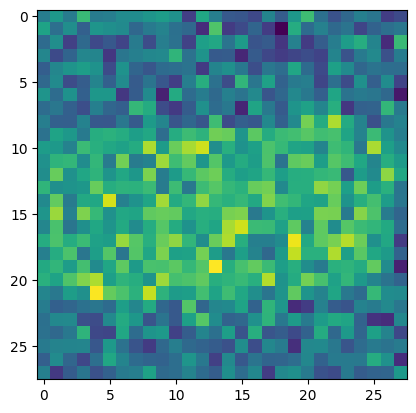

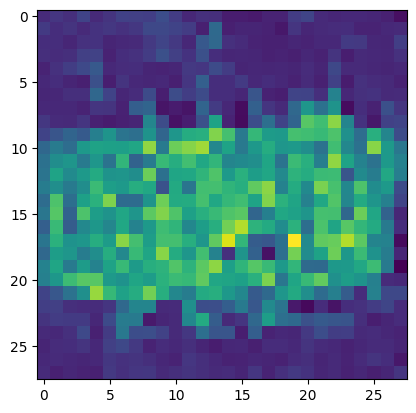

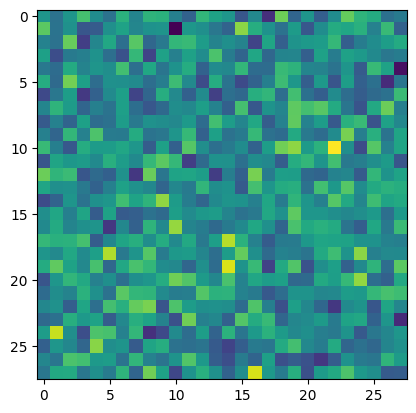

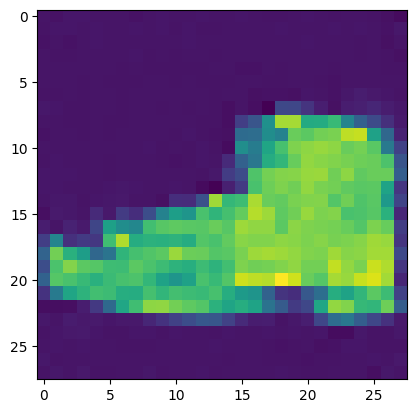

Epoch: 0   Loss: tensor(0.7802, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3900, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.8379, device='cuda:0', grad_fn=<AddBackward0>)


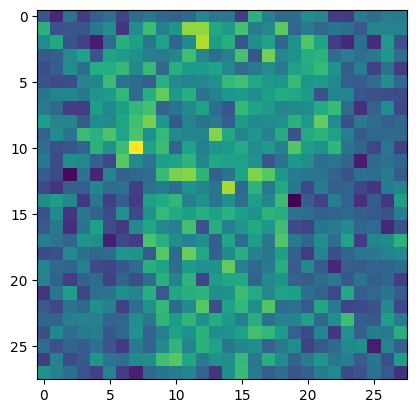

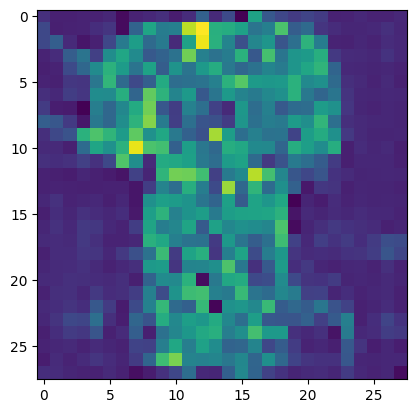

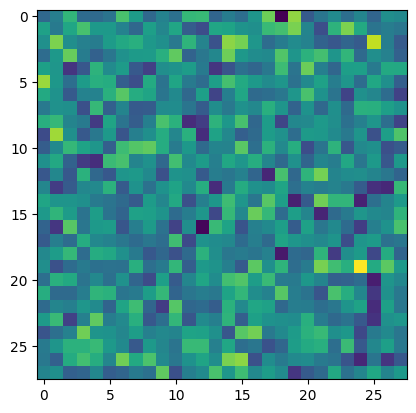

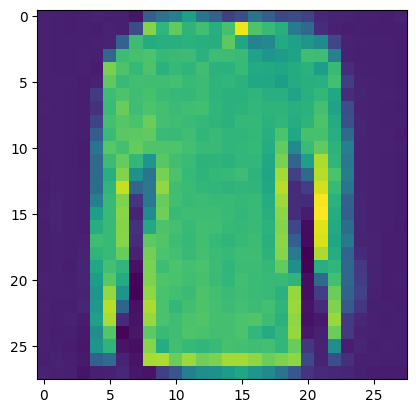

Epoch: 0   Loss: tensor(0.8431, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4205, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(0.2699, device='cuda:0', grad_fn=<AddBackward0>)


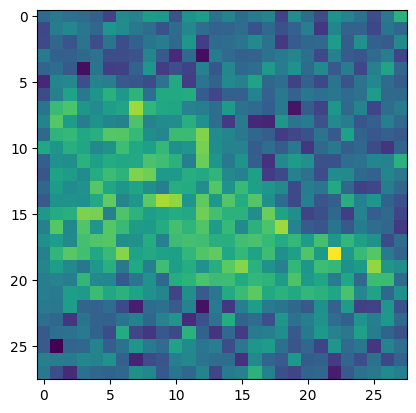

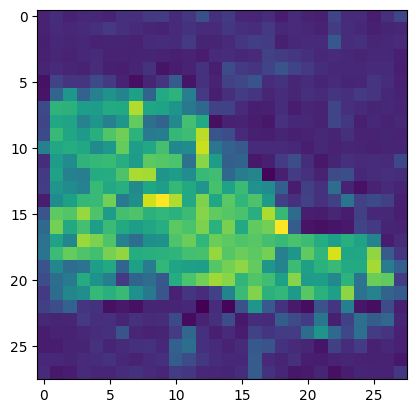

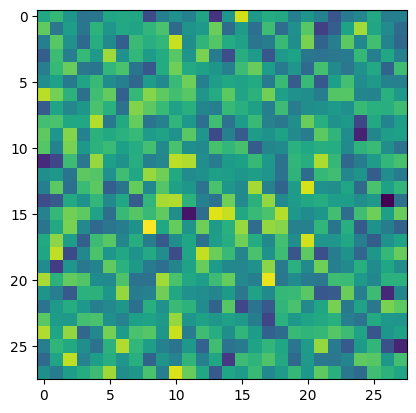

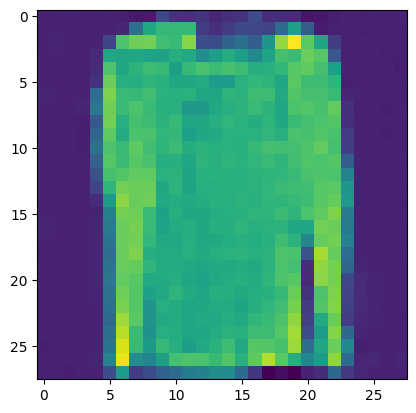

Epoch: 0   Loss: tensor(0.8995, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4015, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0965, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(0.1674, device='cuda:0', grad_fn=<AddBackward0>)


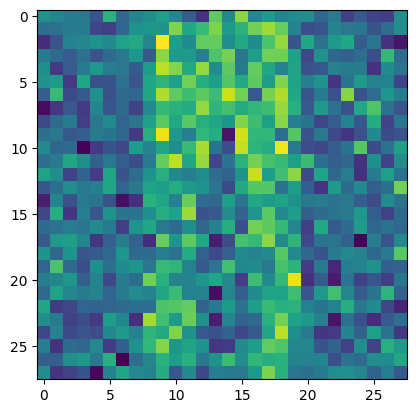

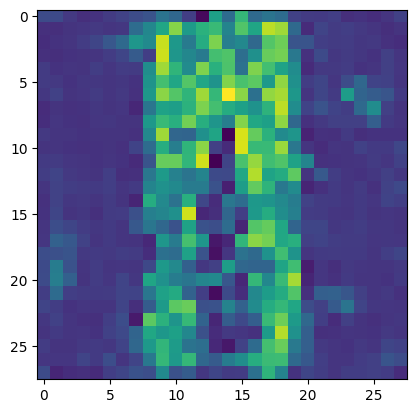

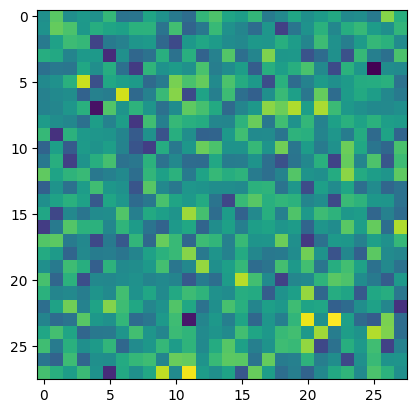

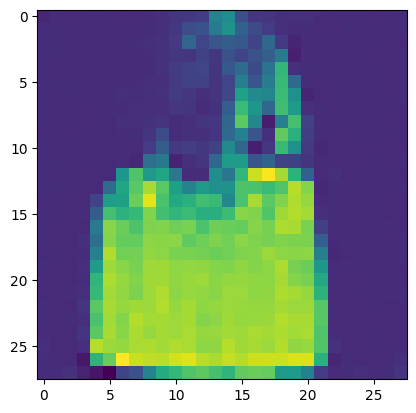

Epoch: 0   Loss: tensor(1.1693, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4068, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.3558, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(0.3051, device='cuda:0', grad_fn=<AddBackward0>)


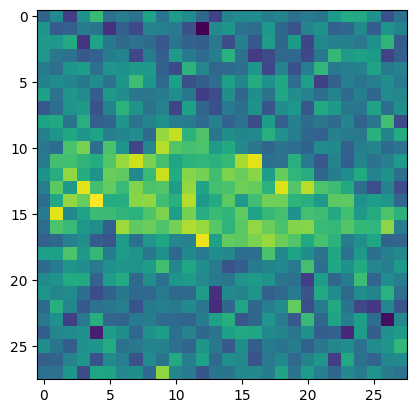

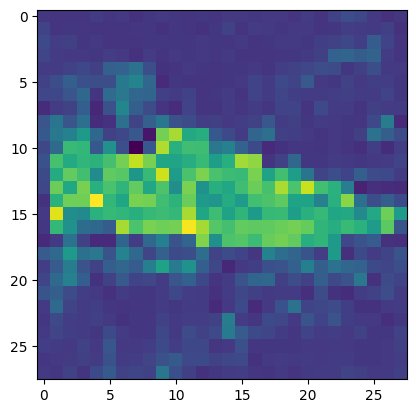

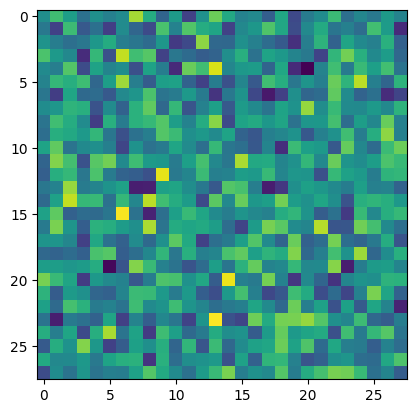

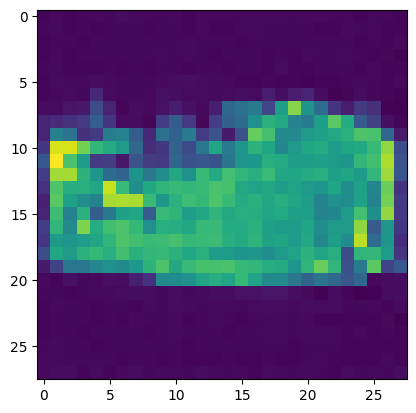

Epoch: 0   Loss: tensor(1.2096, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3896, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.4304, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(2.0680, device='cuda:0', grad_fn=<AddBackward0>)


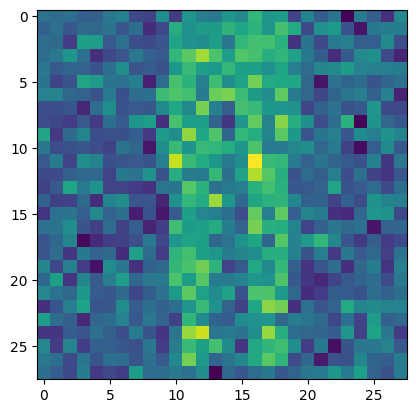

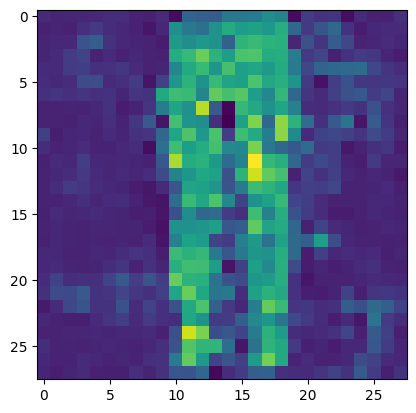

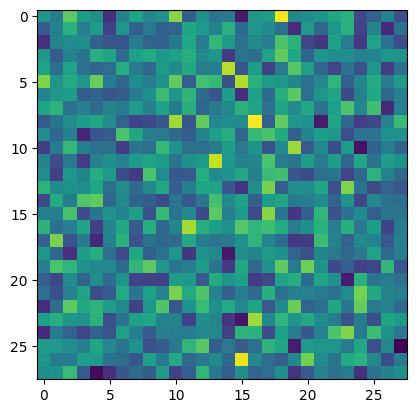

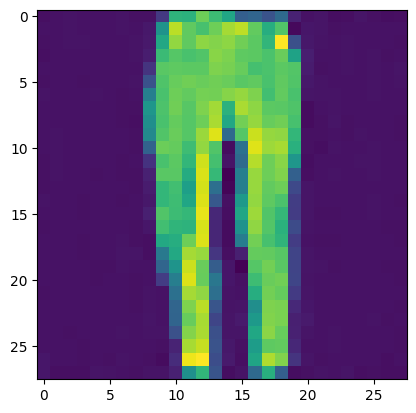

Epoch: 0   Loss: tensor(1.3736, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4008, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.5720, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(0.0833, device='cuda:0', grad_fn=<AddBackward0>)


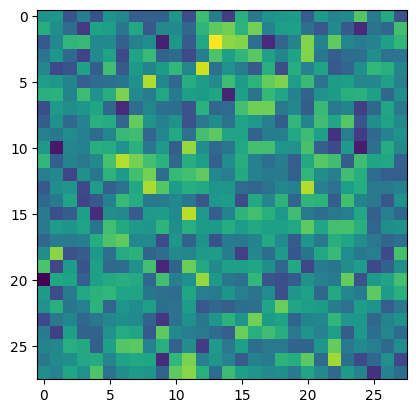

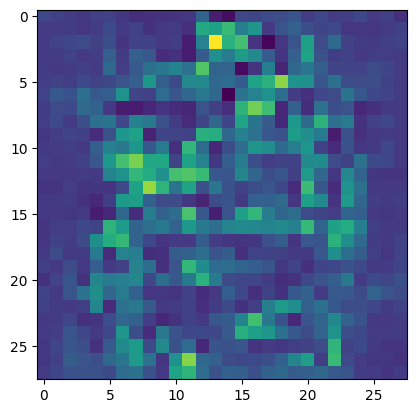

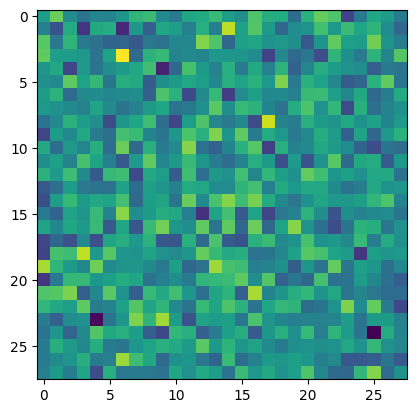

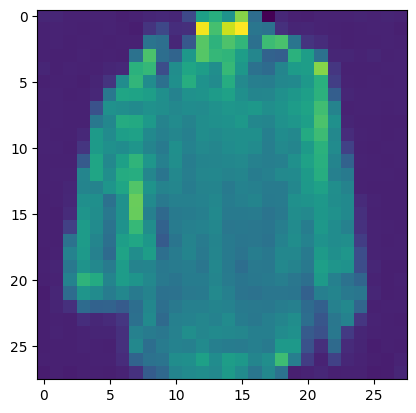

Epoch: 0   Loss: tensor(0.8212, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4034, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0145, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(0.0987, device='cuda:0', grad_fn=<AddBackward0>)


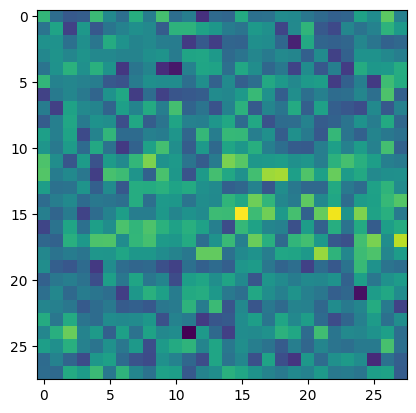

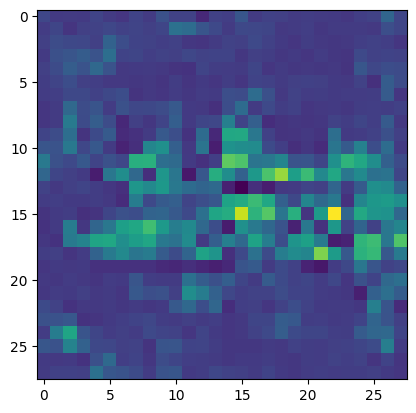

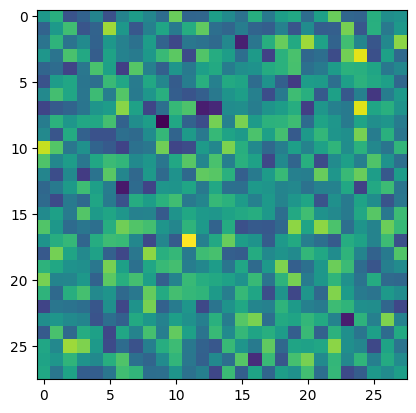

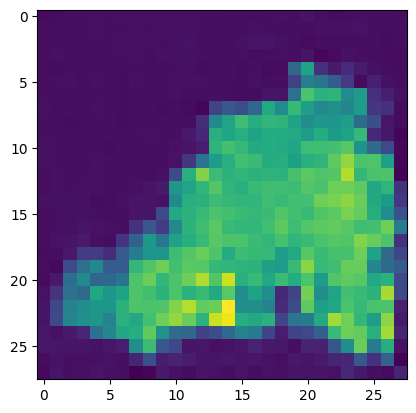

Epoch: 0   Loss: tensor(0.7967, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3974, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0020, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(0.0905, device='cuda:0', grad_fn=<AddBackward0>)


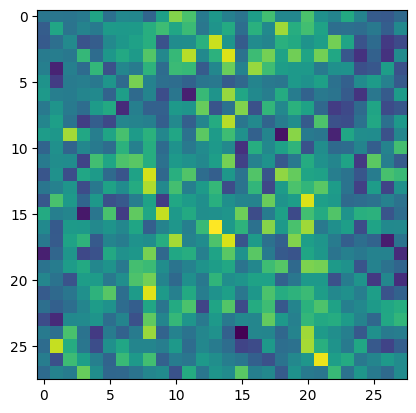

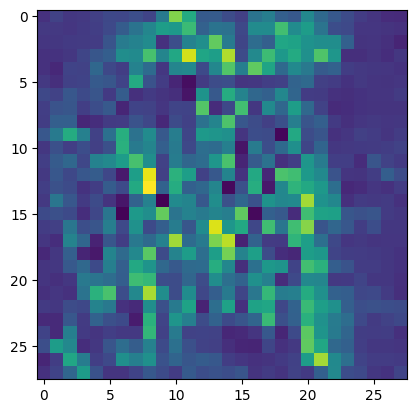

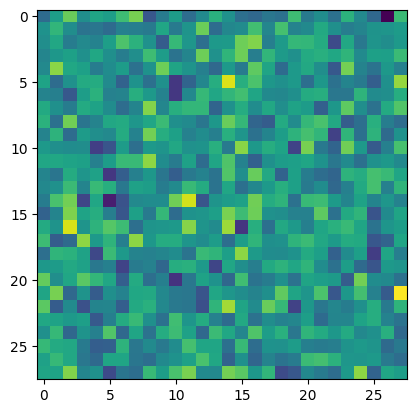

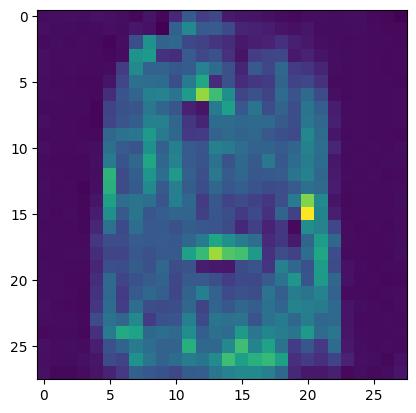

Epoch: 0   Loss: tensor(0.8398, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4175, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0049, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 0  Adversarial Loss:tensor(1.4695, device='cuda:0', grad_fn=<AddBackward0>)


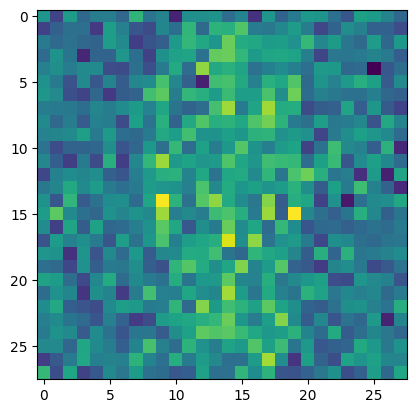

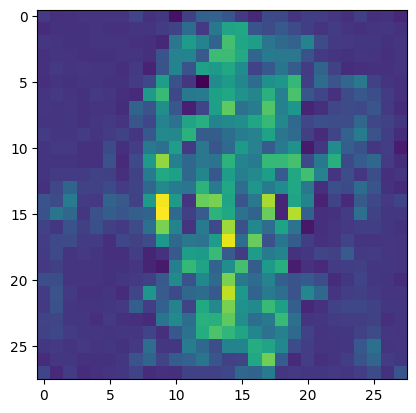

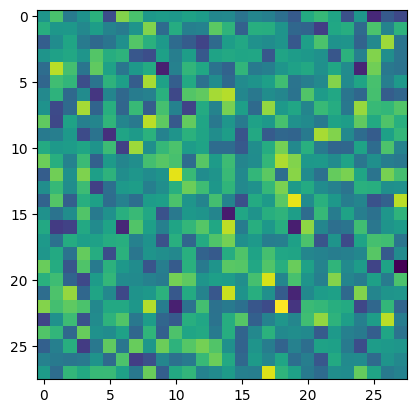

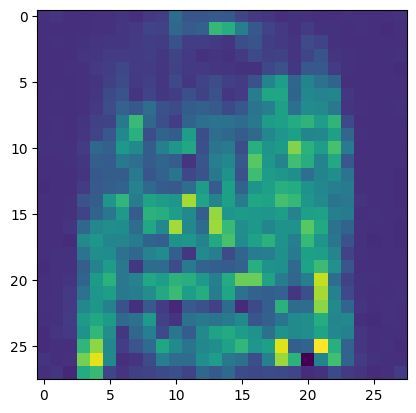

Epoch: 0   Loss: tensor(0.8245, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4104, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0037, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(0.2294, device='cuda:0', grad_fn=<AddBackward0>)


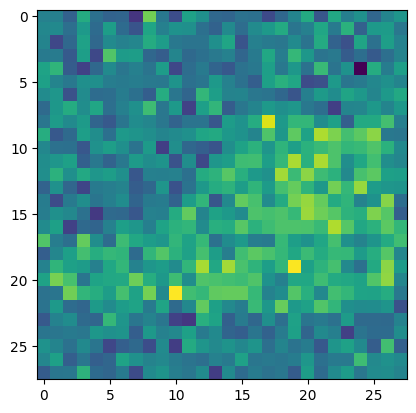

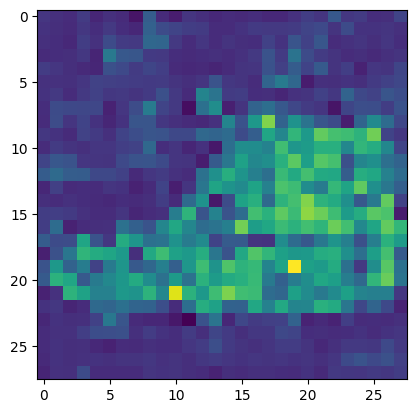

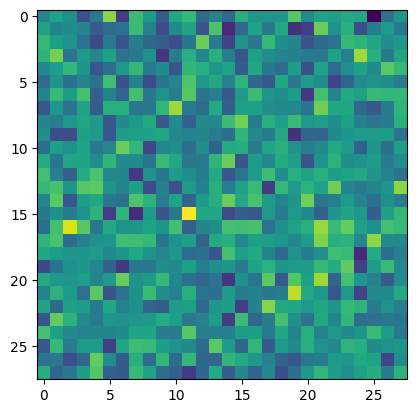

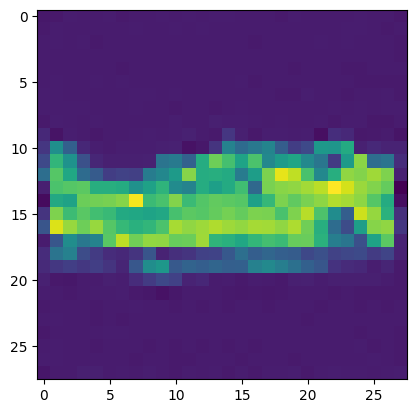

Epoch: 1   Loss: tensor(0.8371, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4063, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0245, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(0.0792, device='cuda:0', grad_fn=<AddBackward0>)


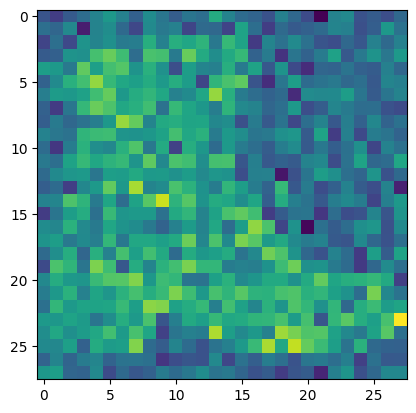

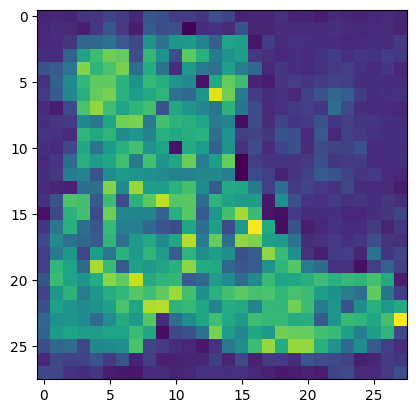

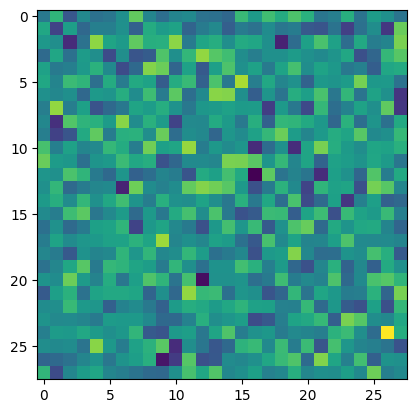

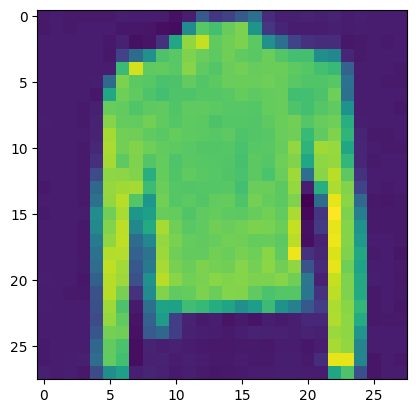

Epoch: 1   Loss: tensor(0.9522, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4186, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1150, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(0.1011, device='cuda:0', grad_fn=<AddBackward0>)


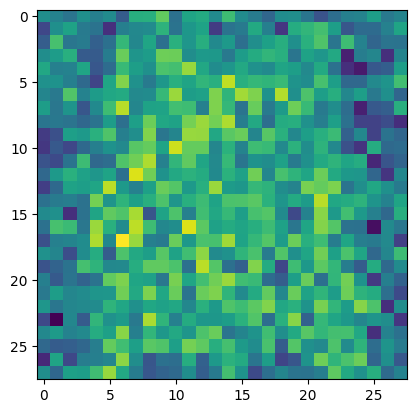

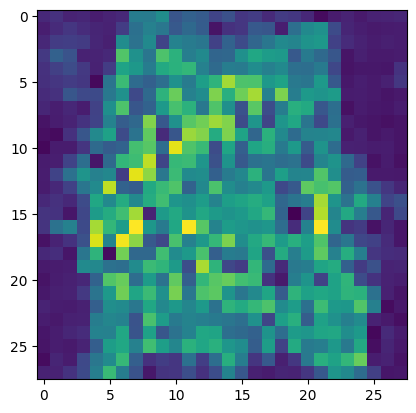

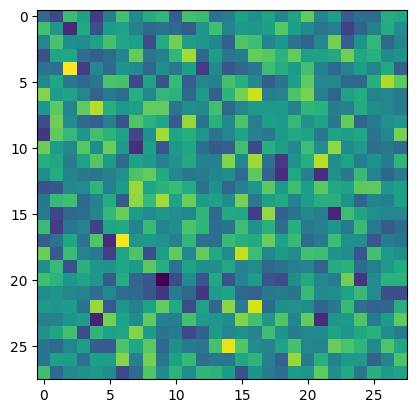

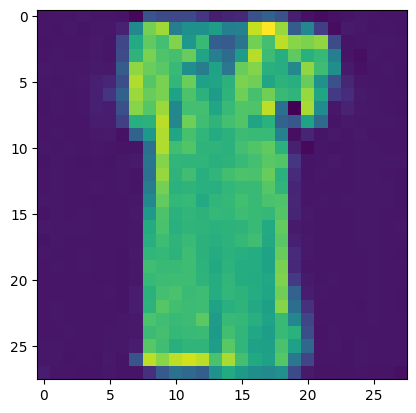

Epoch: 1   Loss: tensor(0.9269, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3924, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1421, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(0.0899, device='cuda:0', grad_fn=<AddBackward0>)


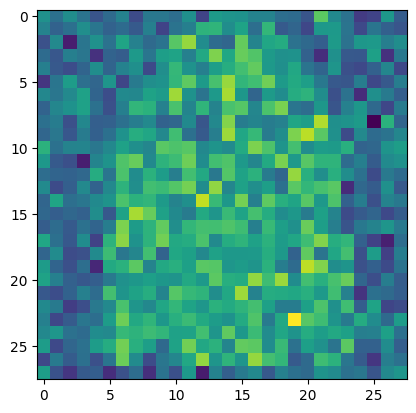

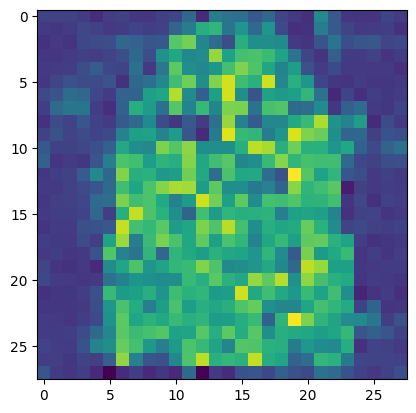

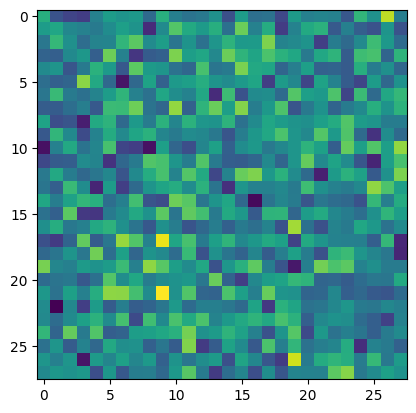

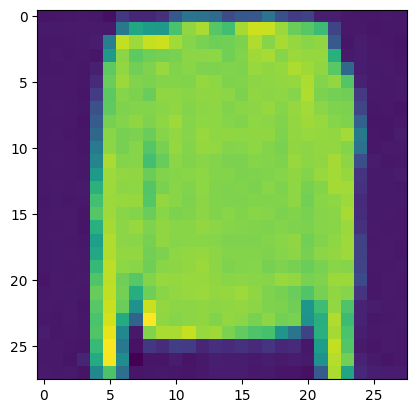

Epoch: 1   Loss: tensor(0.9684, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4234, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1215, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(0.2937, device='cuda:0', grad_fn=<AddBackward0>)


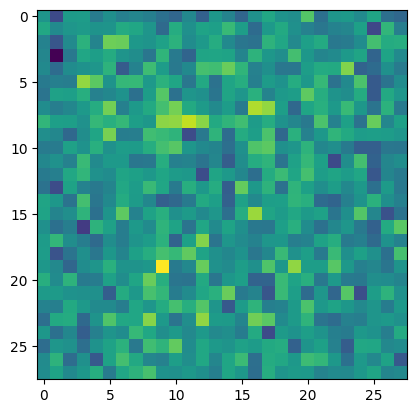

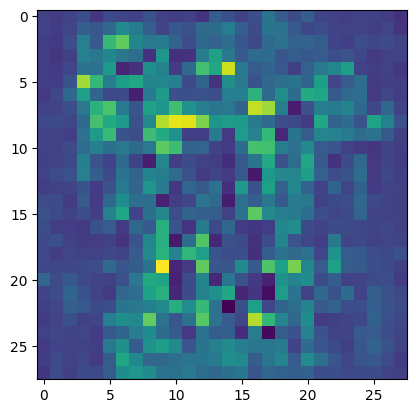

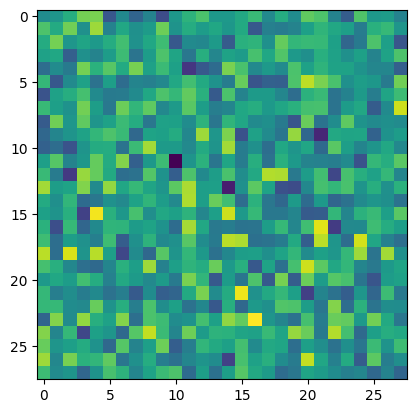

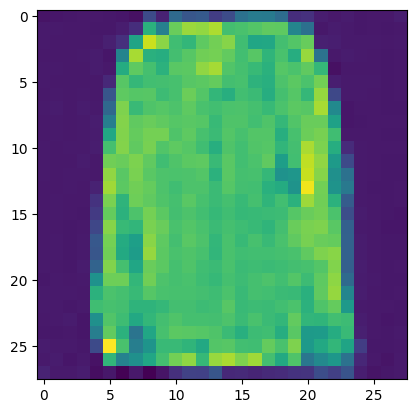

Epoch: 1   Loss: tensor(1.1435, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4048, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.3339, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(0.1993, device='cuda:0', grad_fn=<AddBackward0>)


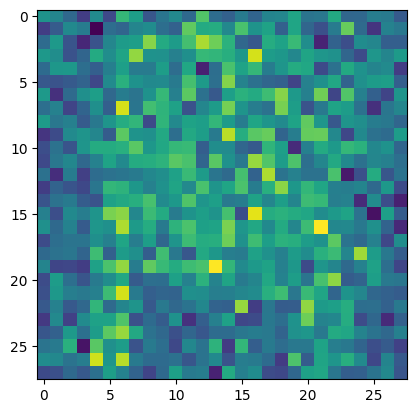

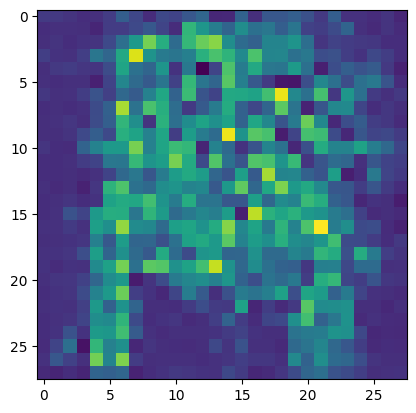

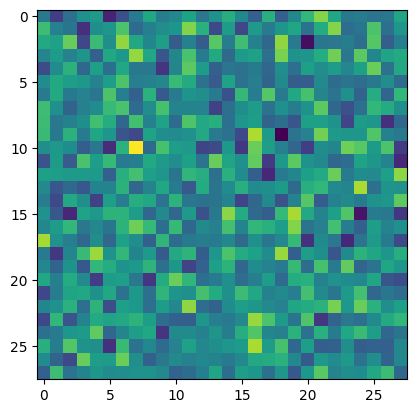

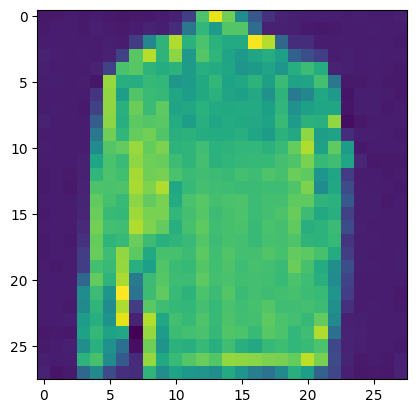

Epoch: 1   Loss: tensor(0.9674, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4003, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1669, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(0.1541, device='cuda:0', grad_fn=<AddBackward0>)


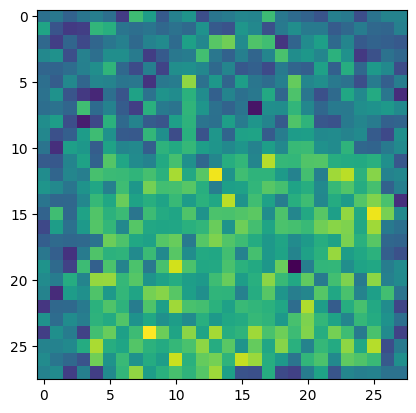

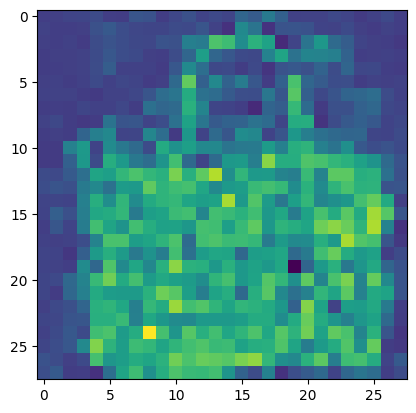

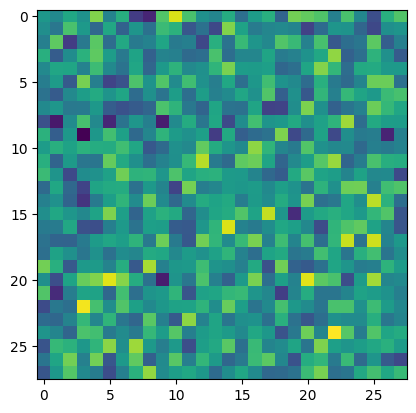

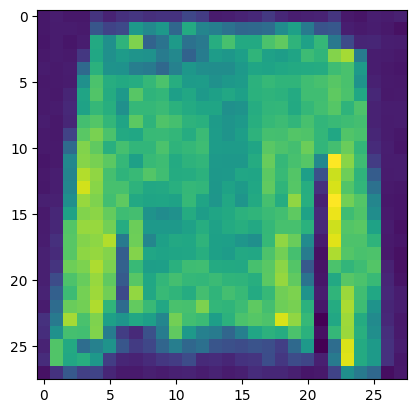

Epoch: 1   Loss: tensor(0.8988, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4037, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0913, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(0.2303, device='cuda:0', grad_fn=<AddBackward0>)


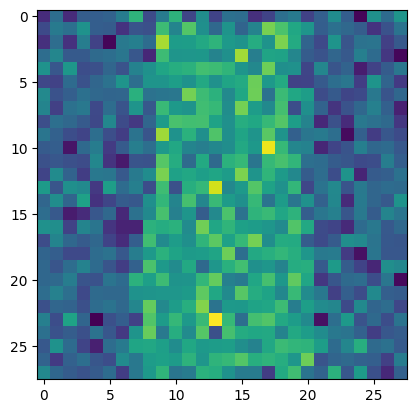

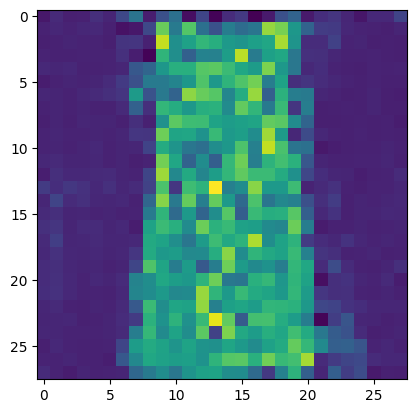

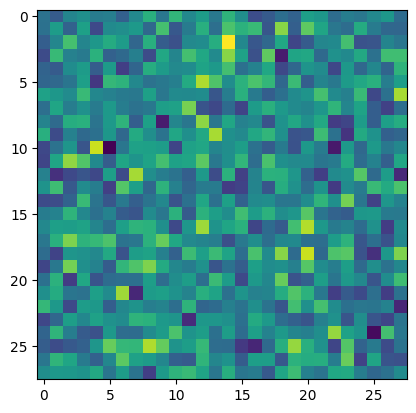

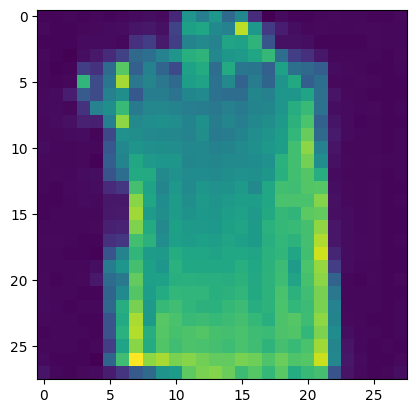

Epoch: 1   Loss: tensor(0.8765, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3986, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0794, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(0.0563, device='cuda:0', grad_fn=<AddBackward0>)


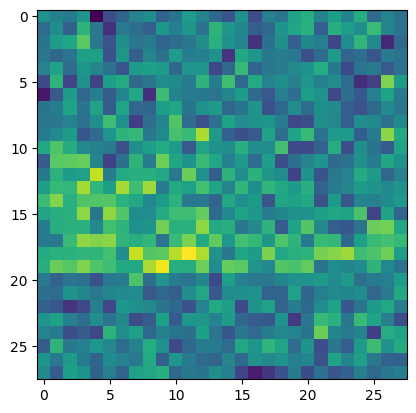

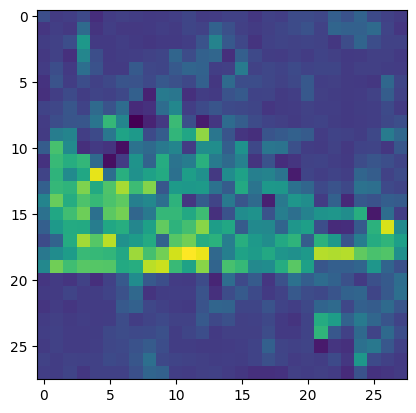

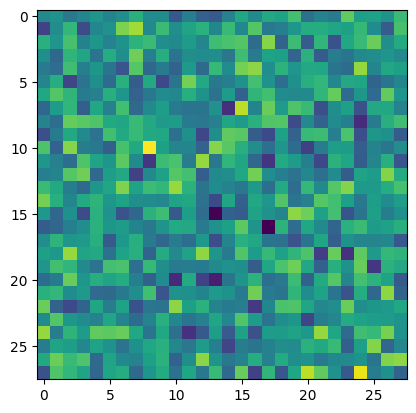

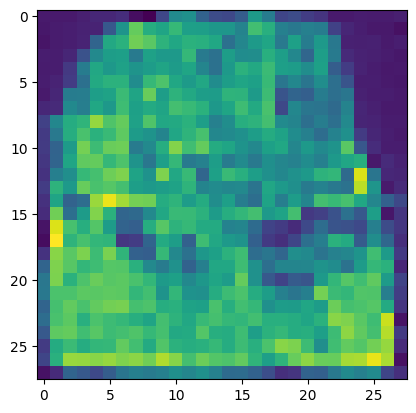

Epoch: 1   Loss: tensor(0.7983, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3908, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 1  Adversarial Loss:tensor(0.2021, device='cuda:0', grad_fn=<AddBackward0>)


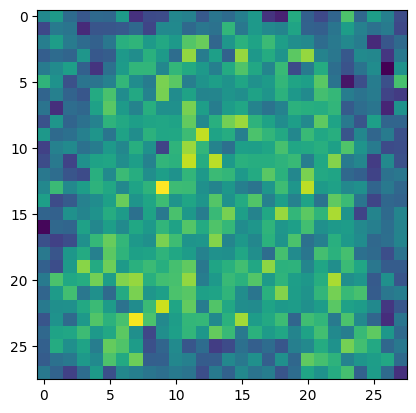

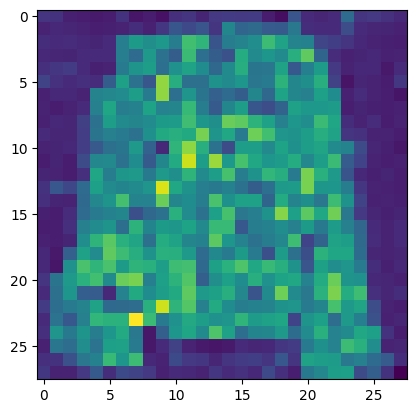

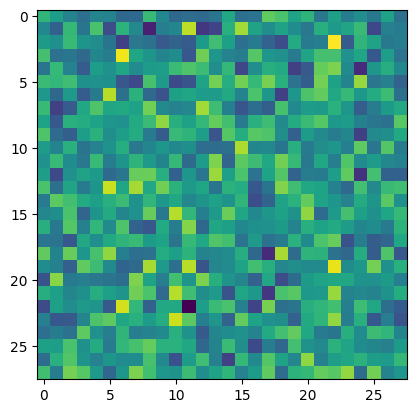

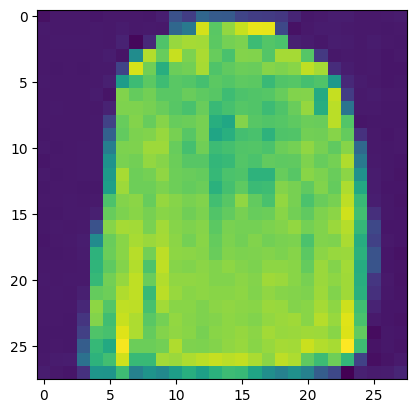

Epoch: 1   Loss: tensor(0.7893, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3916, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(0.1876, device='cuda:0', grad_fn=<AddBackward0>)


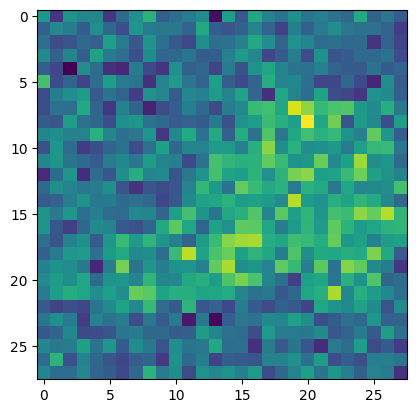

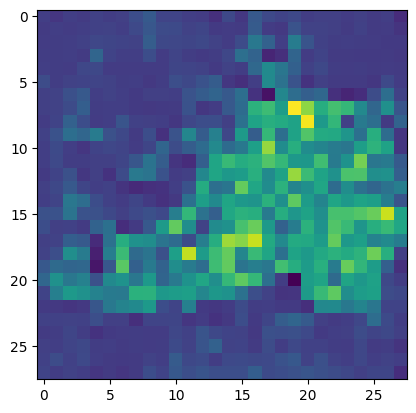

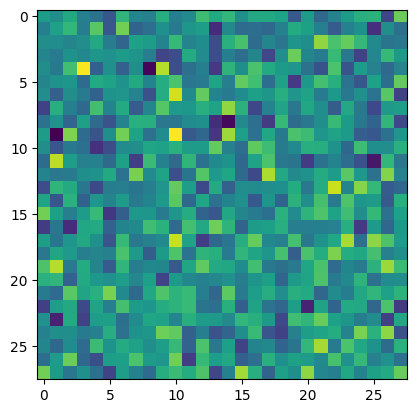

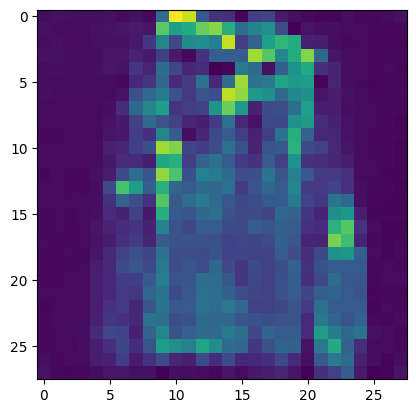

Epoch: 2   Loss: tensor(0.7712, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3815, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0082, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(0.7227, device='cuda:0', grad_fn=<AddBackward0>)


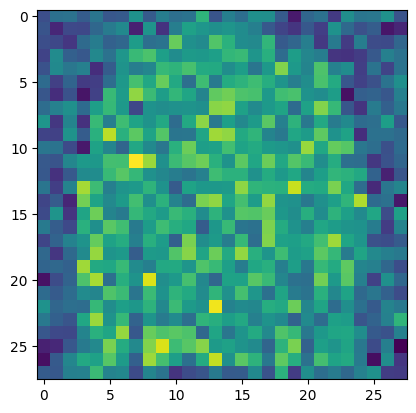

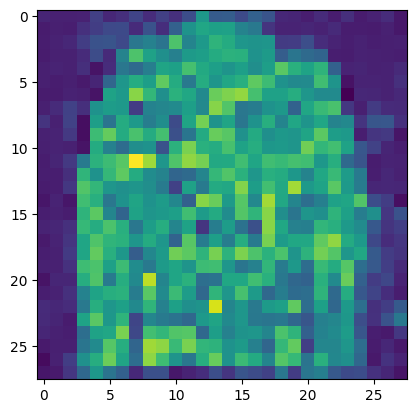

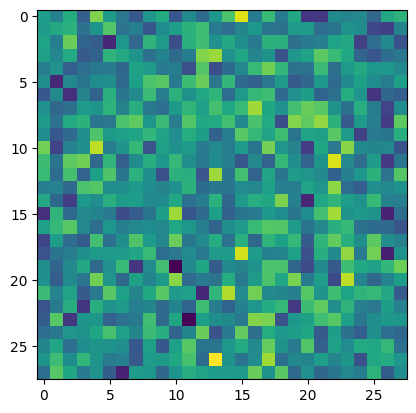

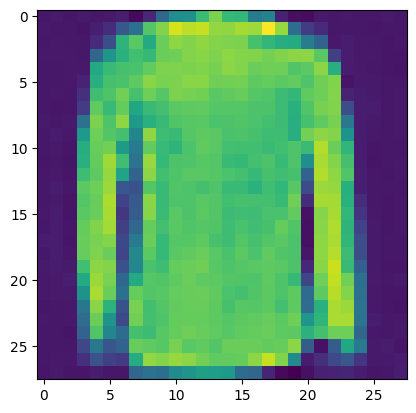

Epoch: 2   Loss: tensor(0.8048, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3992, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0065, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(0.2776, device='cuda:0', grad_fn=<AddBackward0>)


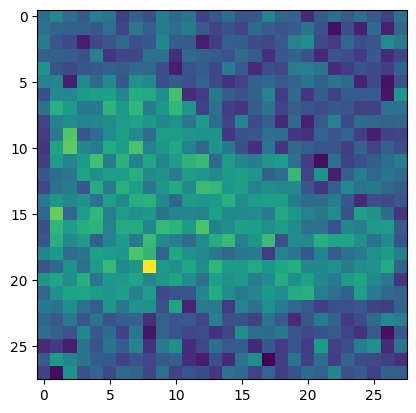

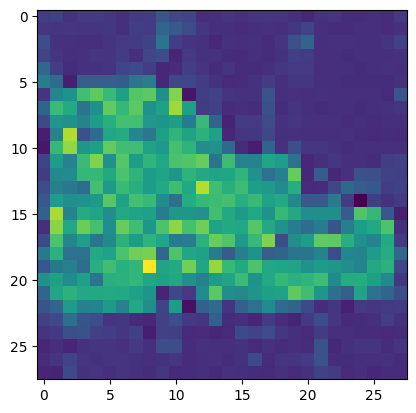

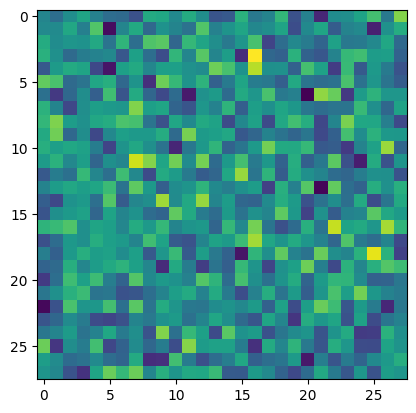

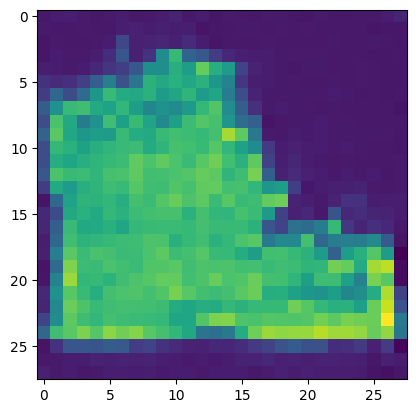

Epoch: 2   Loss: tensor(1.2219, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3762, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.4695, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(0.0424, device='cuda:0', grad_fn=<AddBackward0>)


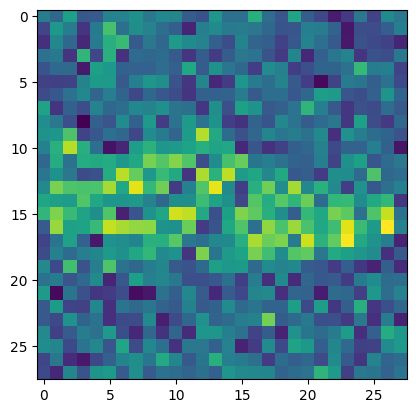

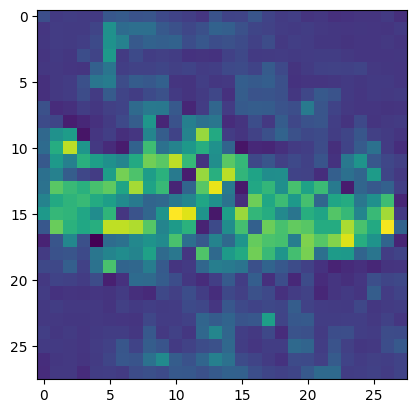

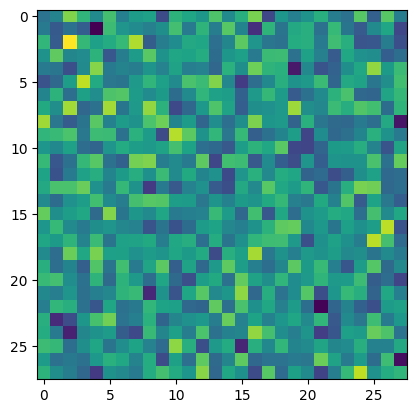

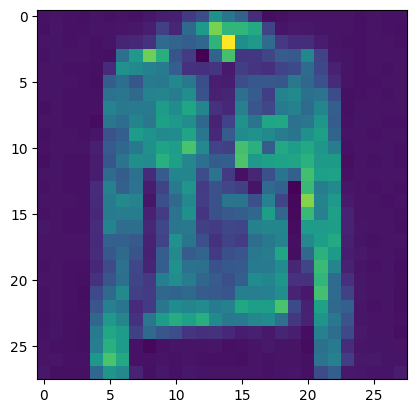

Epoch: 2   Loss: tensor(0.8864, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4159, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0545, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(0.0483, device='cuda:0', grad_fn=<AddBackward0>)


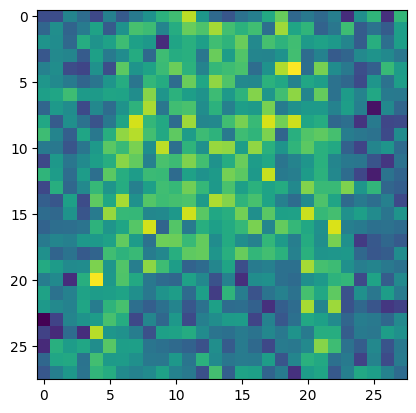

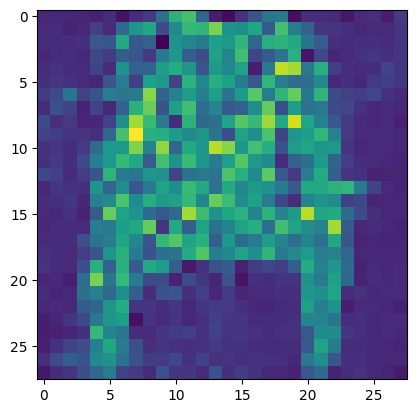

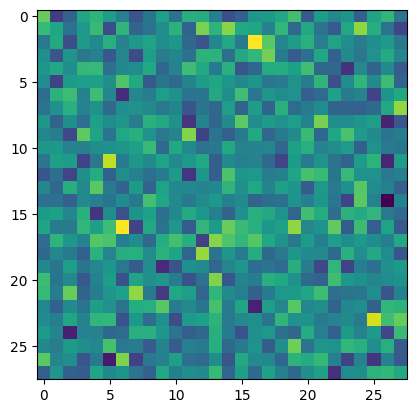

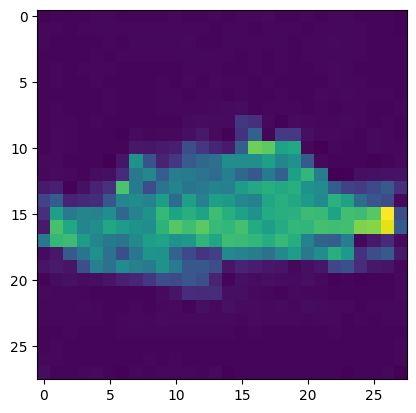

Epoch: 2   Loss: tensor(0.9251, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4408, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0435, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(0.2768, device='cuda:0', grad_fn=<AddBackward0>)


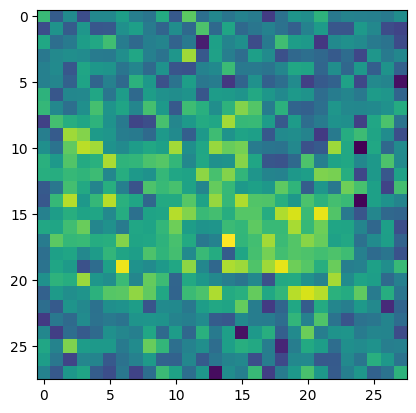

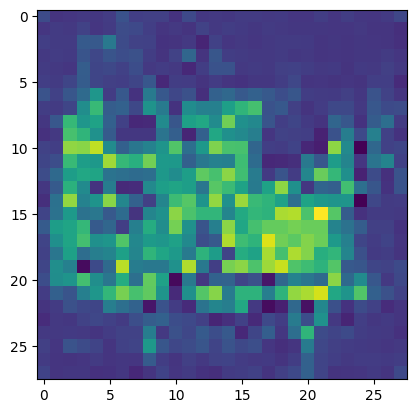

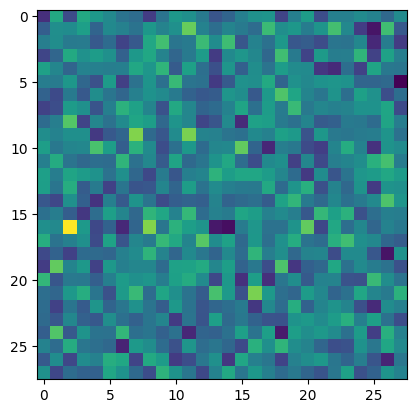

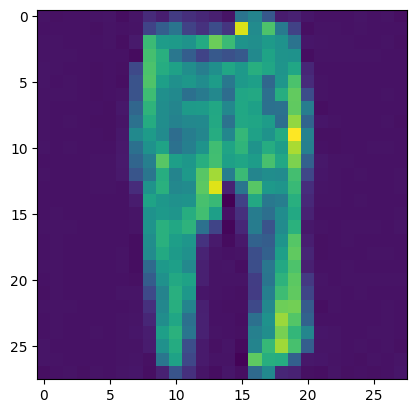

Epoch: 2   Loss: tensor(0.9076, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3802, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1473, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)


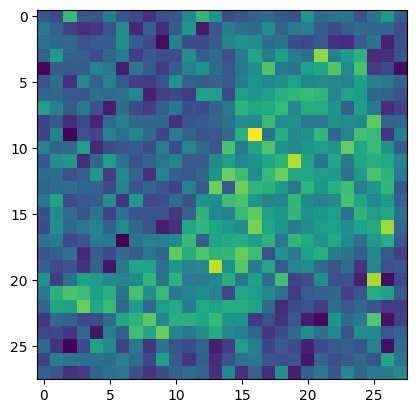

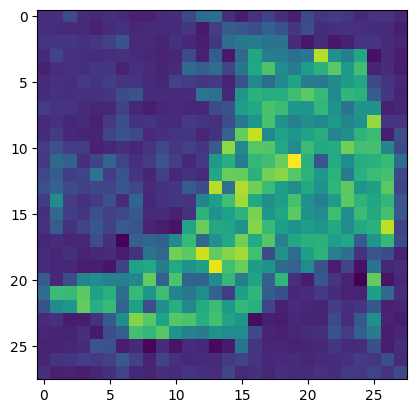

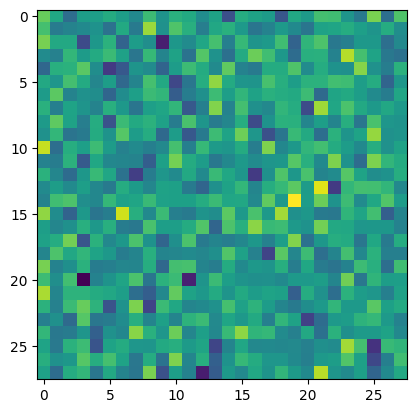

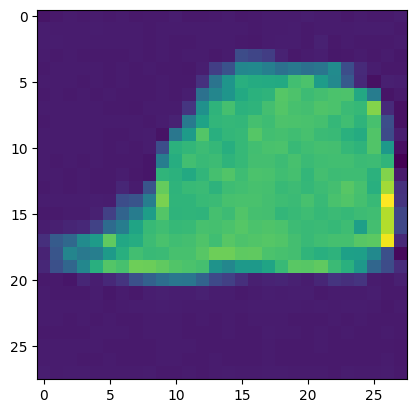

Epoch: 2   Loss: tensor(0.8469, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4177, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0116, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(0.2630, device='cuda:0', grad_fn=<AddBackward0>)


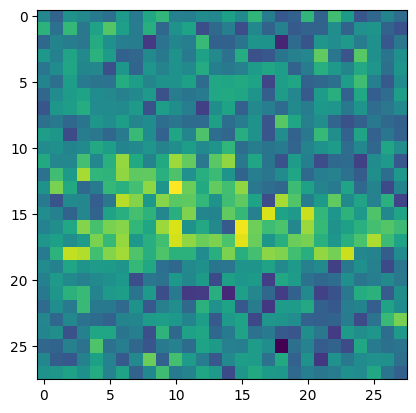

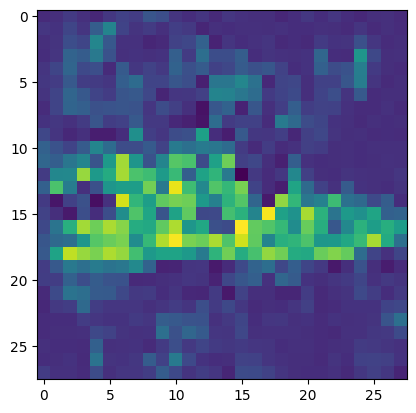

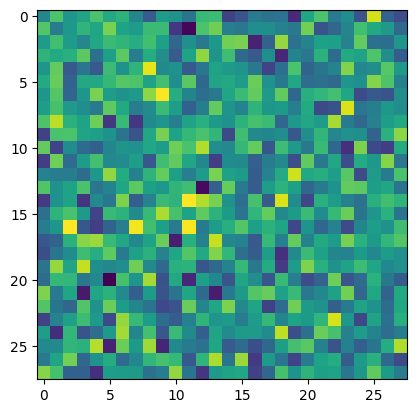

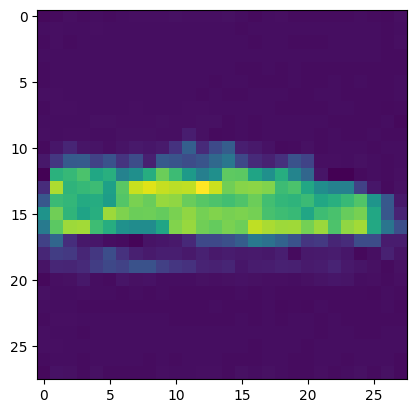

Epoch: 2   Loss: tensor(0.8645, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4074, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0498, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(0.0174, device='cuda:0', grad_fn=<AddBackward0>)


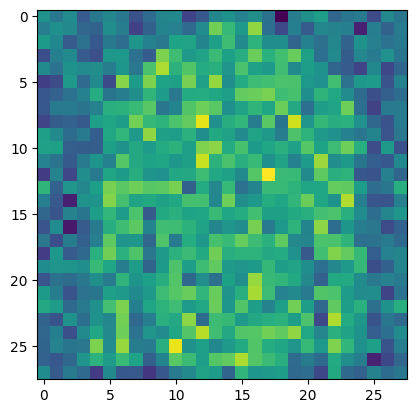

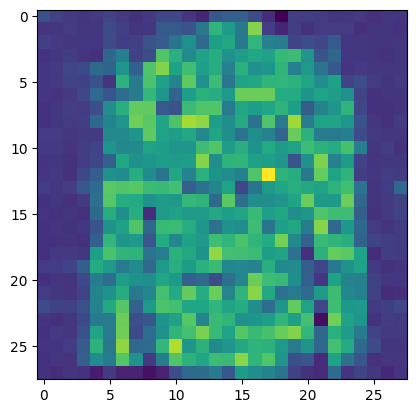

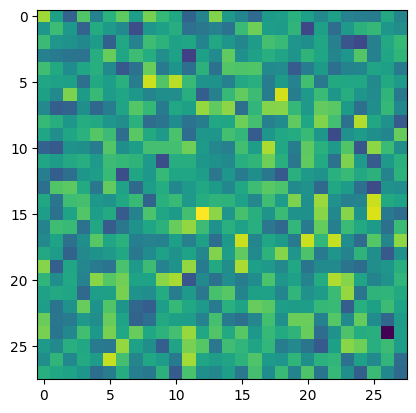

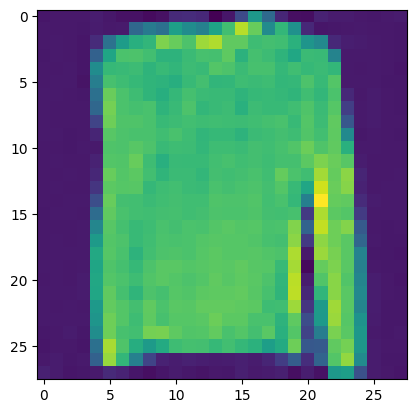

Epoch: 2   Loss: tensor(0.7988, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3986, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0017, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 2  Adversarial Loss:tensor(0.0296, device='cuda:0', grad_fn=<AddBackward0>)


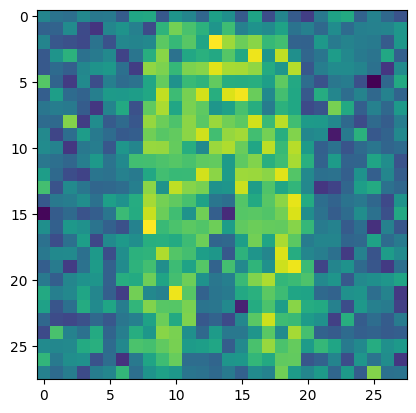

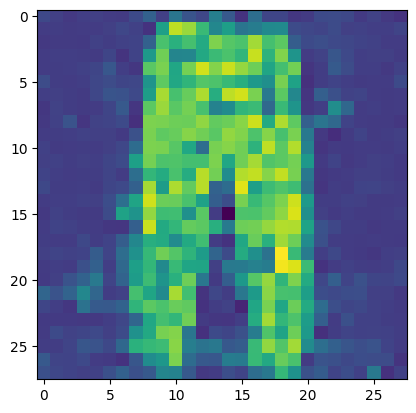

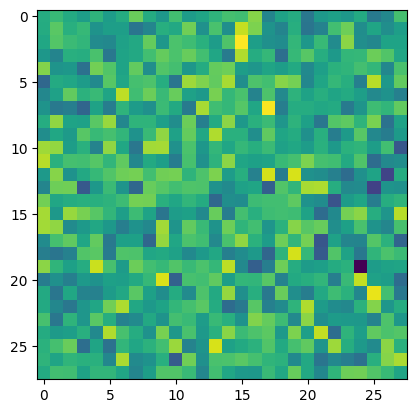

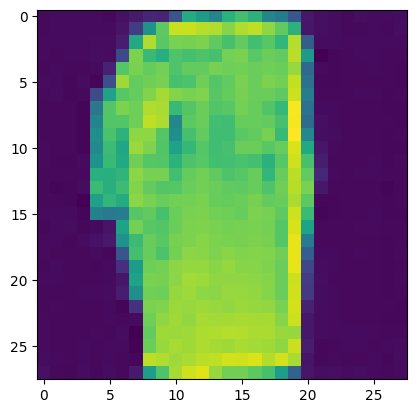

Epoch: 2   Loss: tensor(0.7886, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3929, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0027, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(0.2593, device='cuda:0', grad_fn=<AddBackward0>)


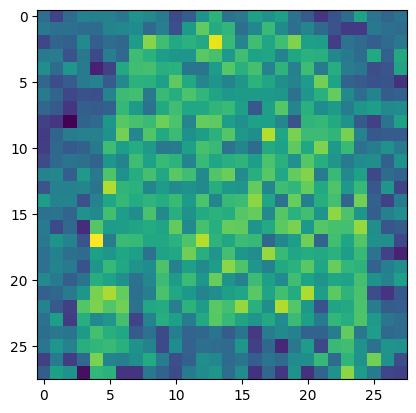

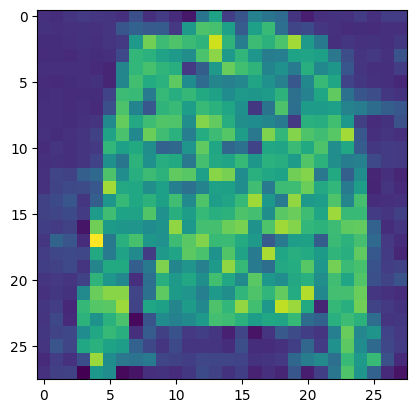

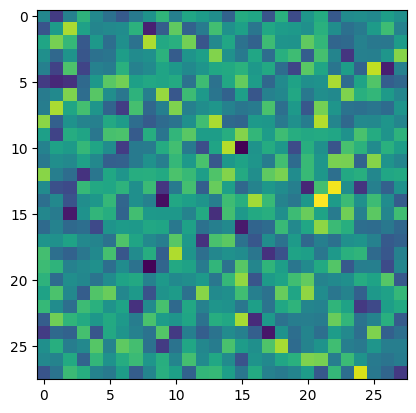

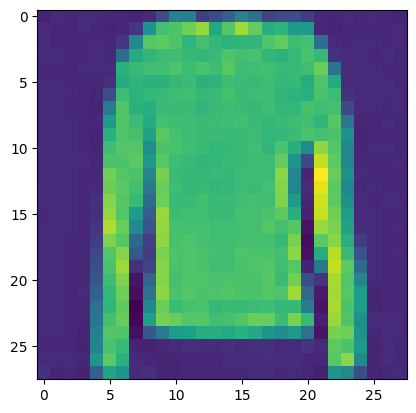

Epoch: 3   Loss: tensor(0.7954, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3975, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(0.0284, device='cuda:0', grad_fn=<AddBackward0>)


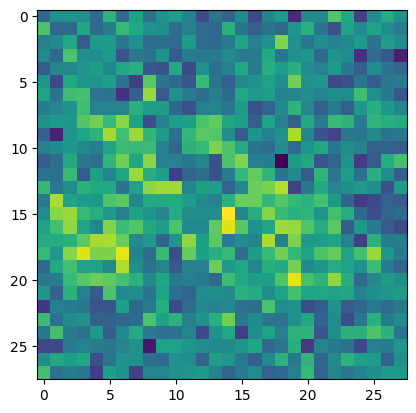

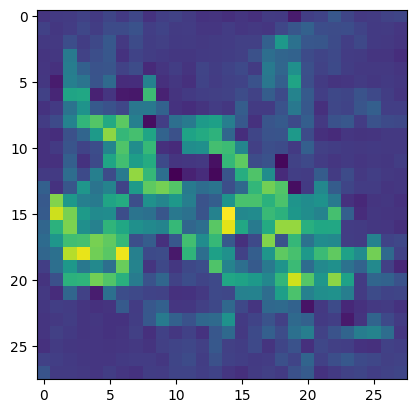

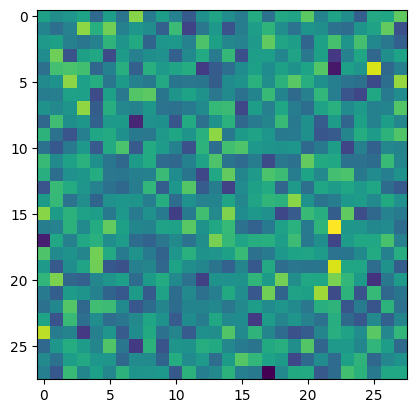

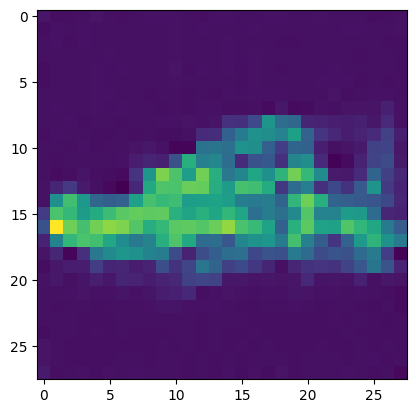

Epoch: 3   Loss: tensor(0.8245, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4118, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0009, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(0.0332, device='cuda:0', grad_fn=<AddBackward0>)


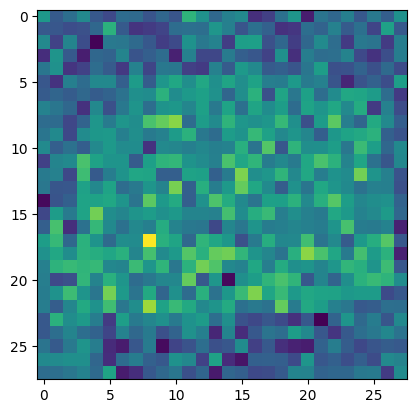

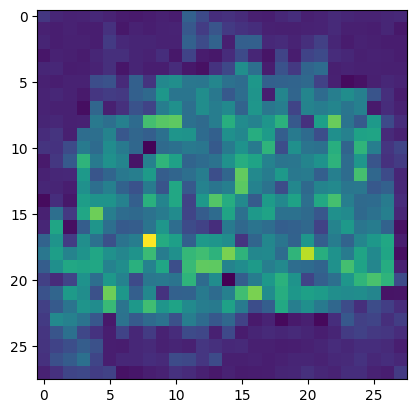

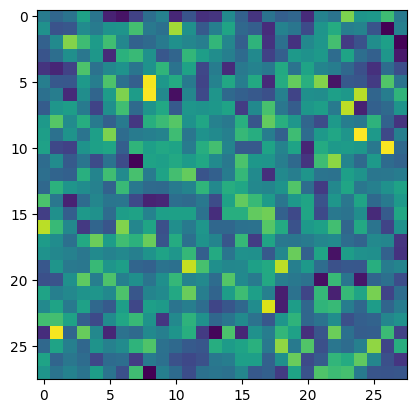

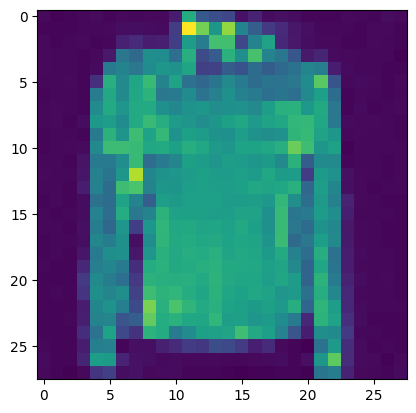

Epoch: 3   Loss: tensor(0.7978, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3982, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0014, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(0.0164, device='cuda:0', grad_fn=<AddBackward0>)


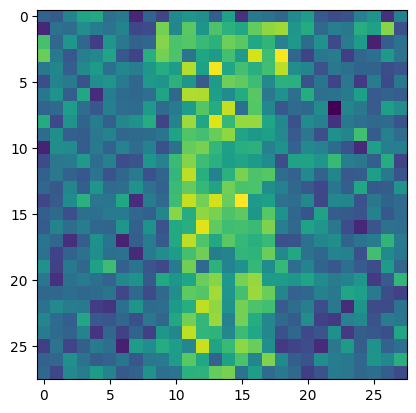

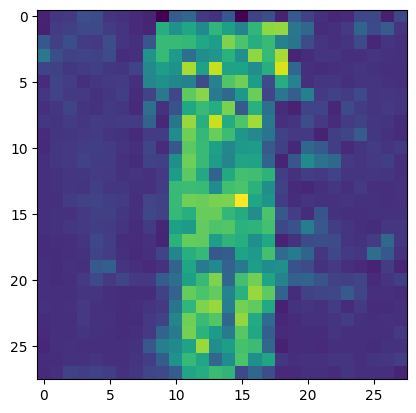

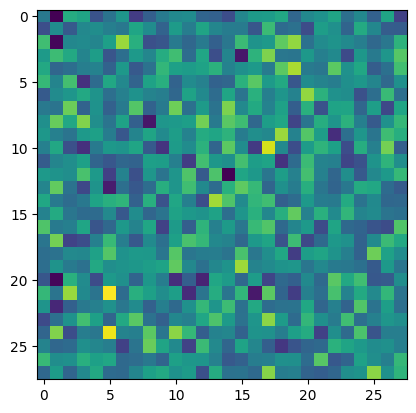

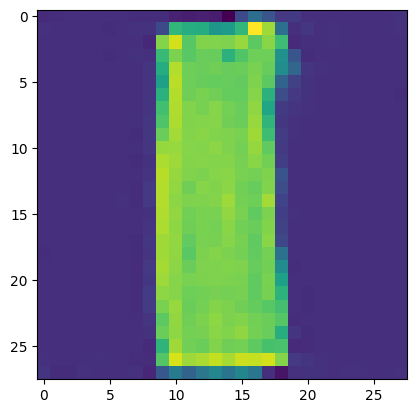

Epoch: 3   Loss: tensor(0.7659, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3814, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0031, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(0.0280, device='cuda:0', grad_fn=<AddBackward0>)


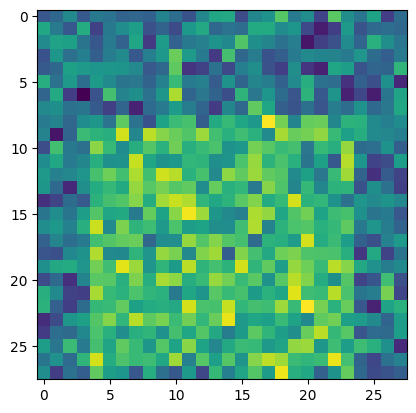

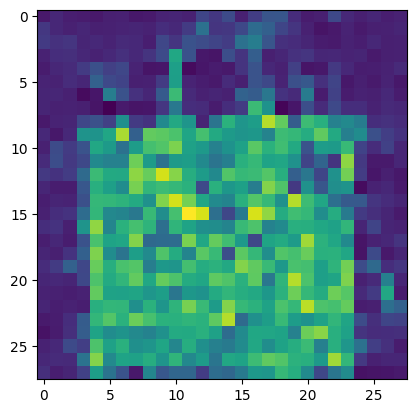

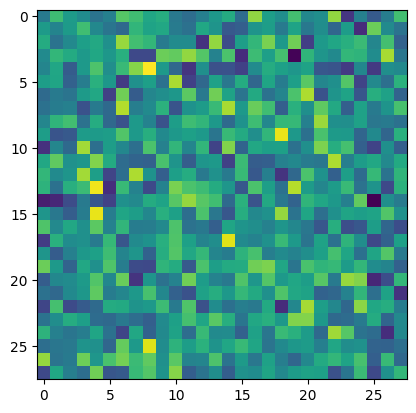

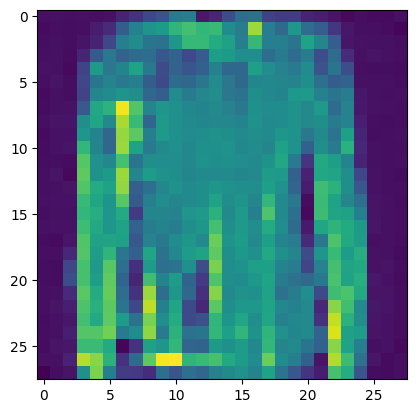

Epoch: 3   Loss: tensor(0.7993, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3977, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0038, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(0.0945, device='cuda:0', grad_fn=<AddBackward0>)


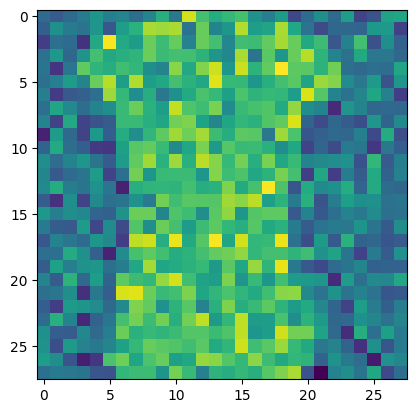

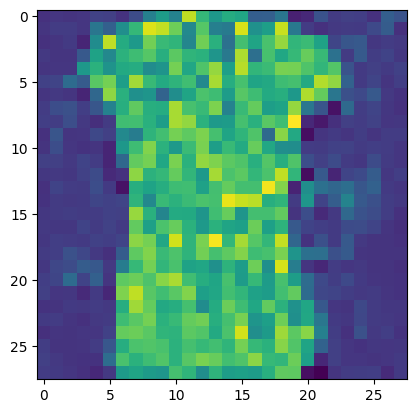

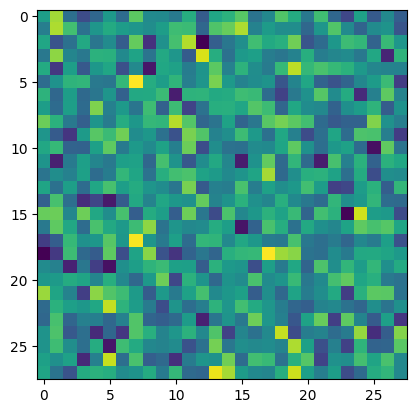

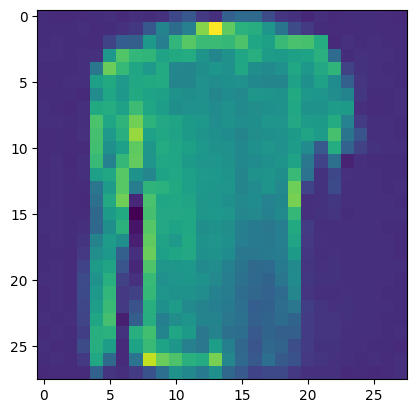

Epoch: 3   Loss: tensor(0.7974, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3842, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0290, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)


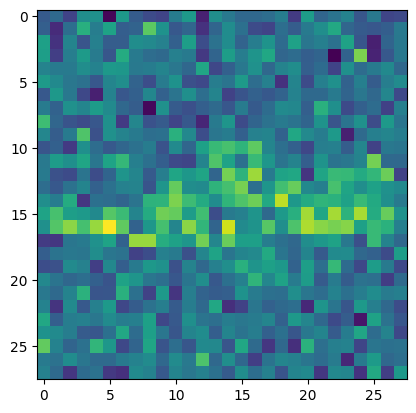

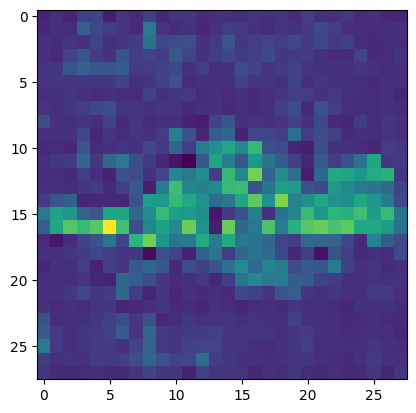

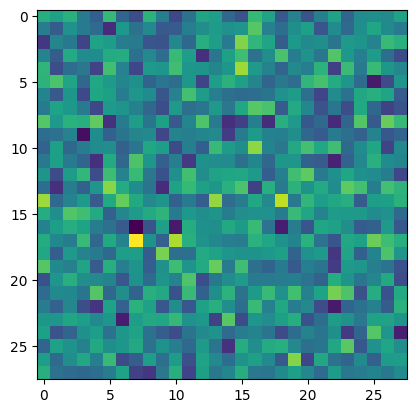

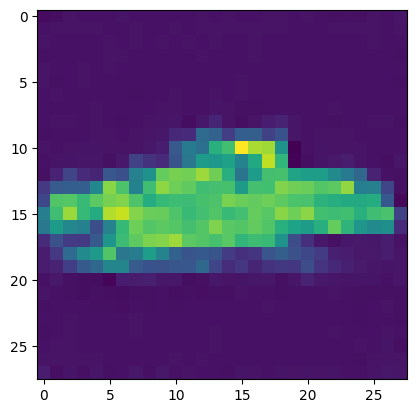

Epoch: 3   Loss: tensor(0.8750, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4352, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0045, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(0.0114, device='cuda:0', grad_fn=<AddBackward0>)


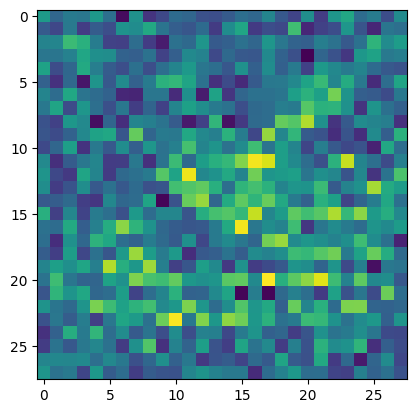

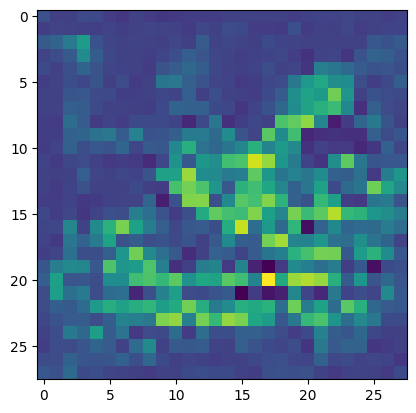

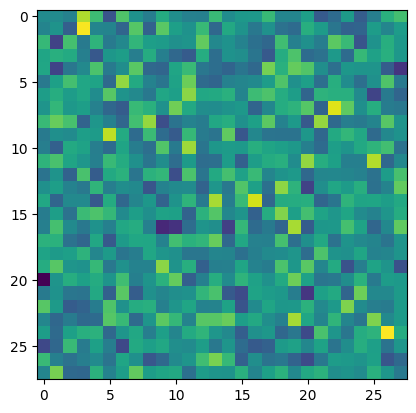

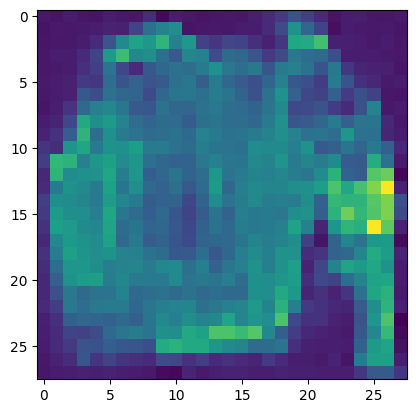

Epoch: 3   Loss: tensor(0.8287, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4120, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(0.0354, device='cuda:0', grad_fn=<AddBackward0>)


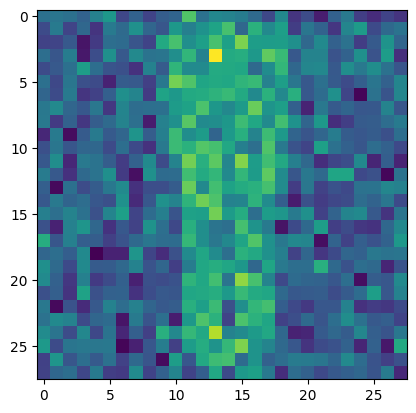

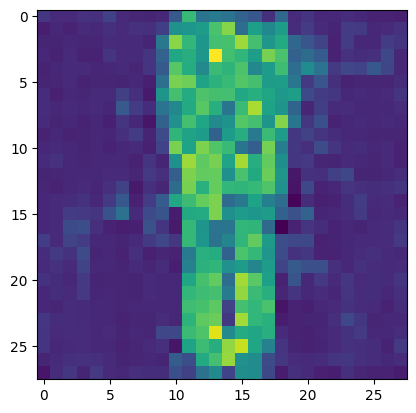

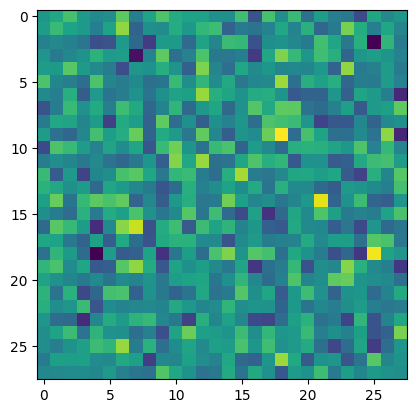

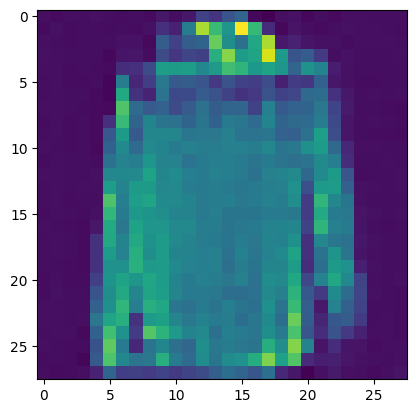

Epoch: 3   Loss: tensor(0.8547, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4069, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 3  Adversarial Loss:tensor(0.4946, device='cuda:0', grad_fn=<AddBackward0>)


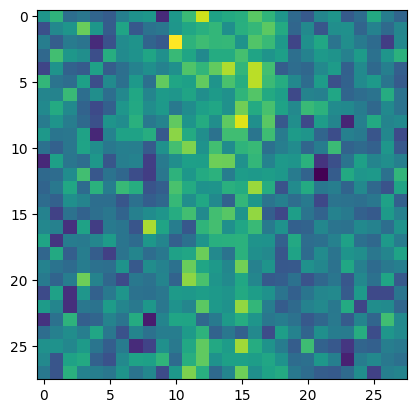

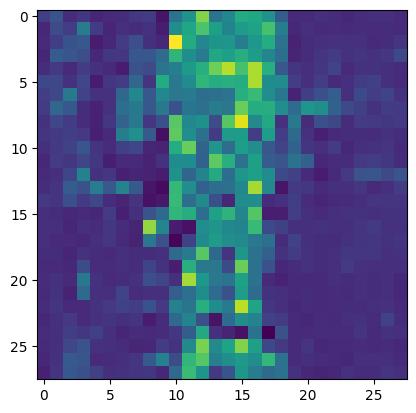

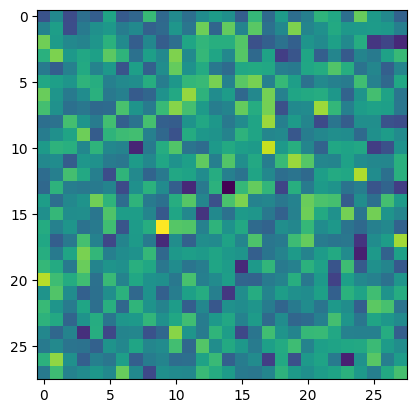

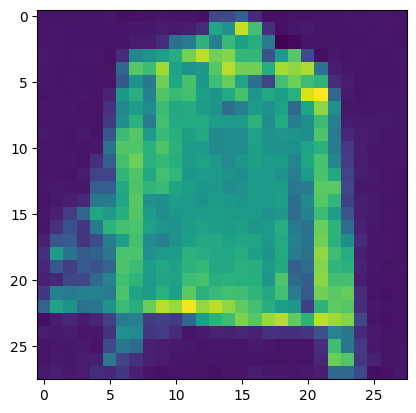

Epoch: 3   Loss: tensor(0.8930, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4240, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0449, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(0.0134, device='cuda:0', grad_fn=<AddBackward0>)


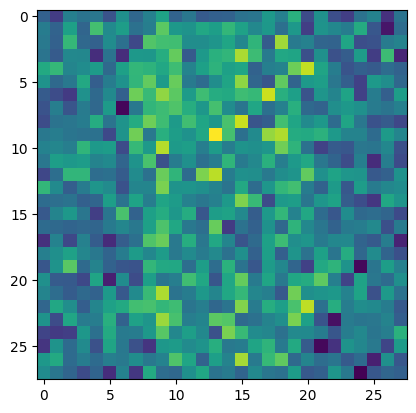

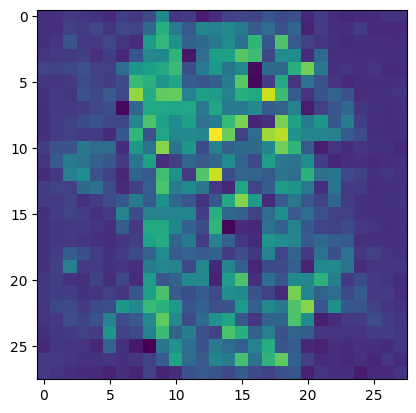

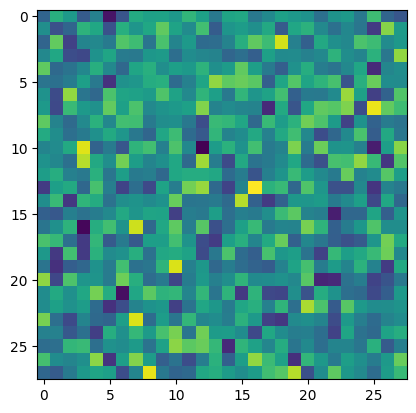

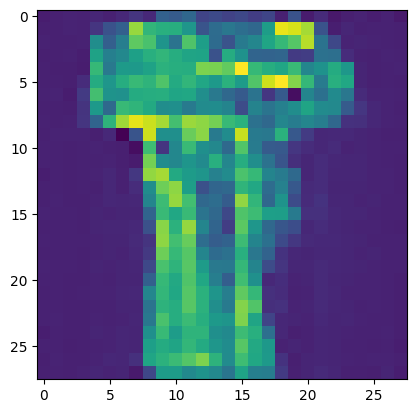

Epoch: 4   Loss: tensor(0.8195, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4097, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(8.8513e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(0.0048, device='cuda:0', grad_fn=<AddBackward0>)


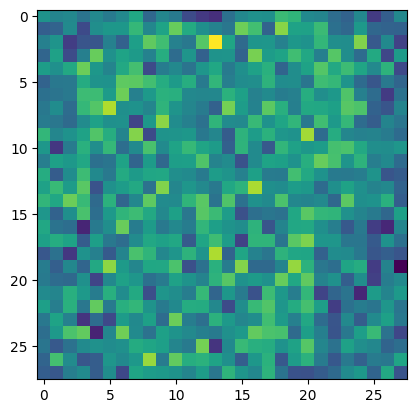

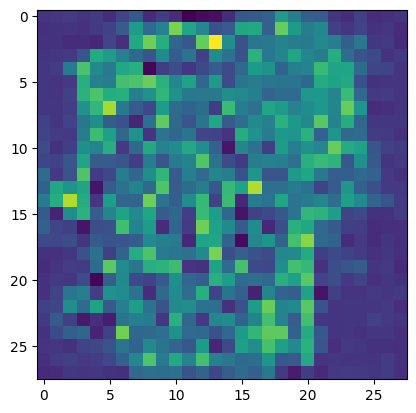

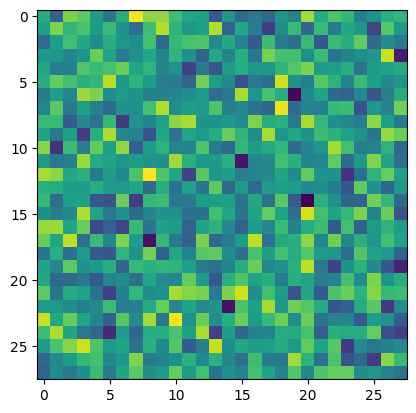

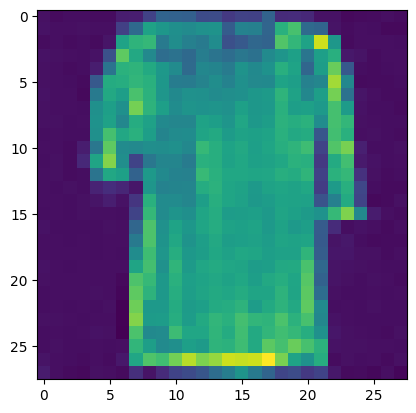

Epoch: 4   Loss: tensor(0.7421, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3710, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(0.1051, device='cuda:0', grad_fn=<AddBackward0>)


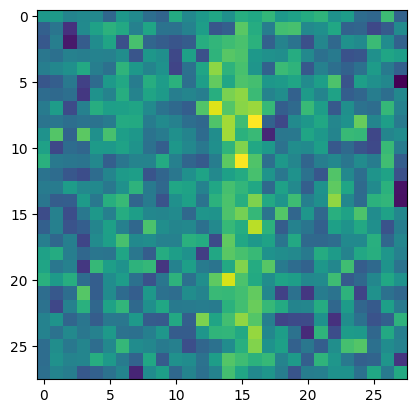

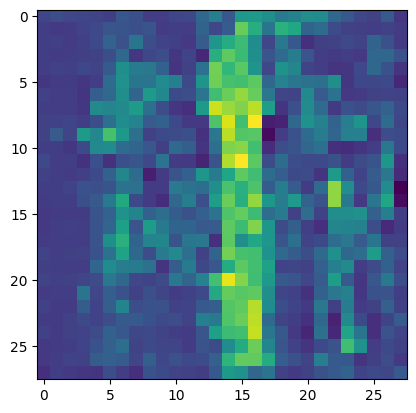

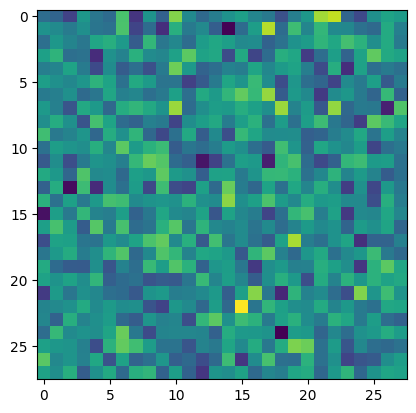

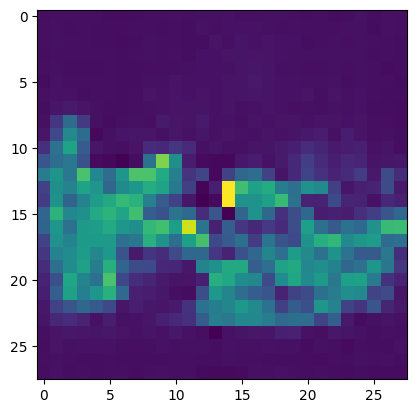

Epoch: 4   Loss: tensor(0.7496, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3748, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(7.2947e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(1.3848, device='cuda:0', grad_fn=<AddBackward0>)


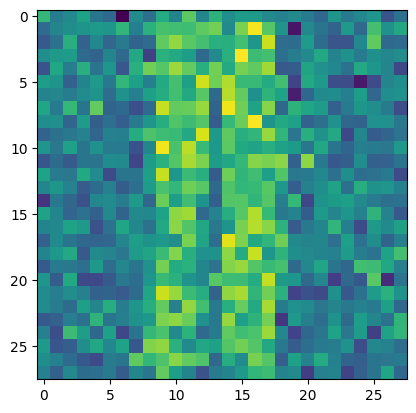

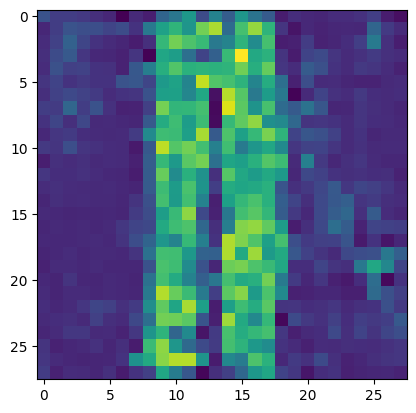

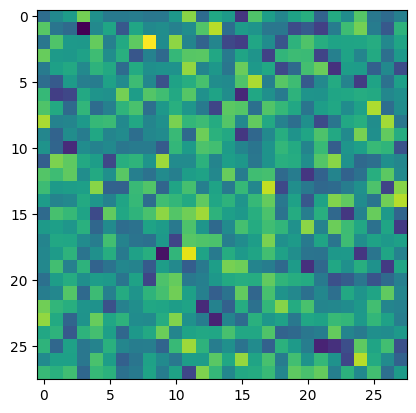

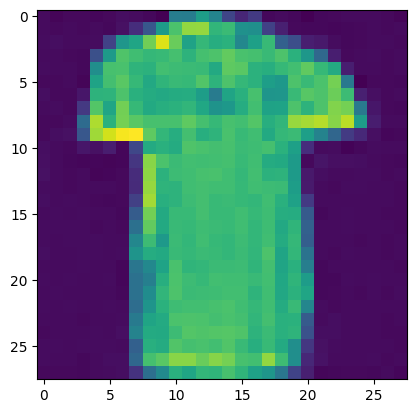

Epoch: 4   Loss: tensor(0.8249, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4121, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0007, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(0.2900, device='cuda:0', grad_fn=<AddBackward0>)


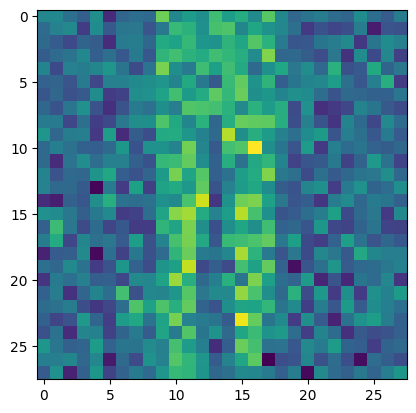

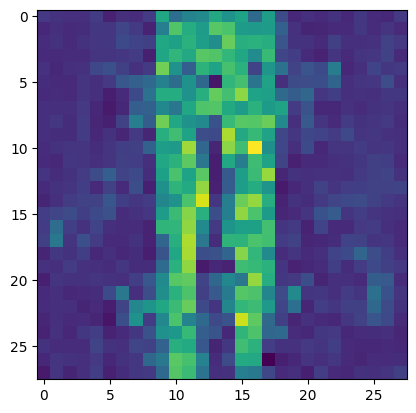

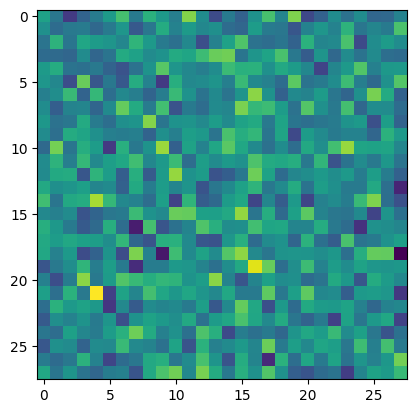

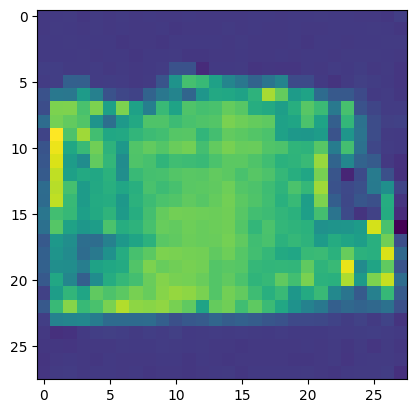

Epoch: 4   Loss: tensor(0.8338, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4139, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0061, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(0.0043, device='cuda:0', grad_fn=<AddBackward0>)


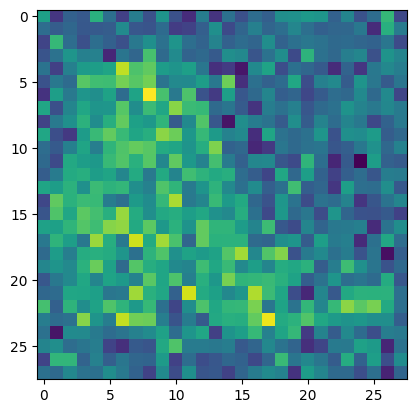

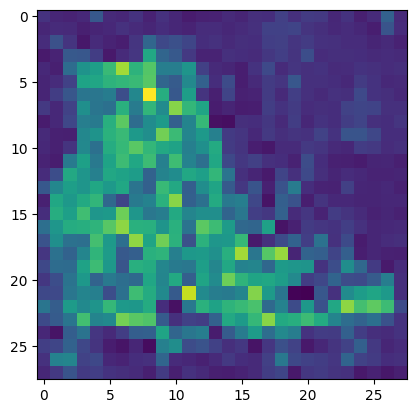

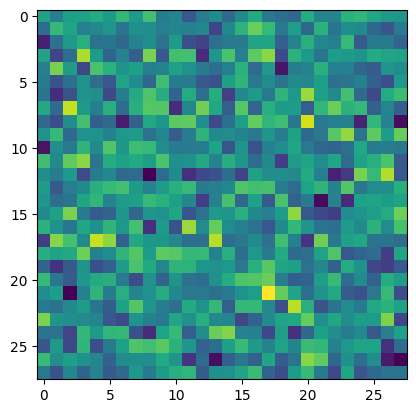

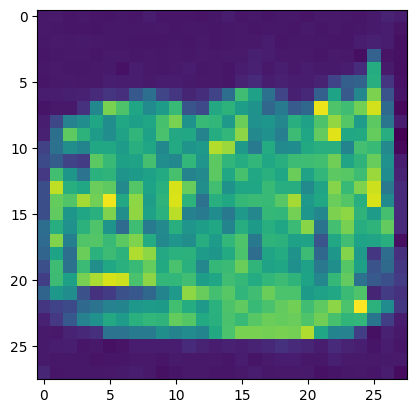

Epoch: 4   Loss: tensor(1.2930, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4178, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.4573, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(1.3634, device='cuda:0', grad_fn=<AddBackward0>)


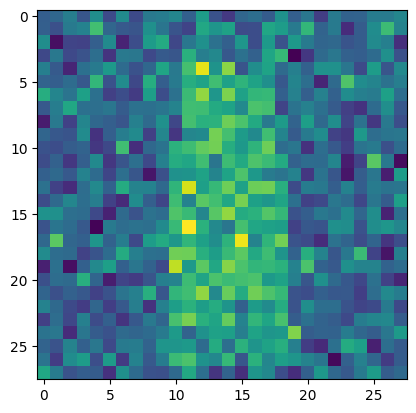

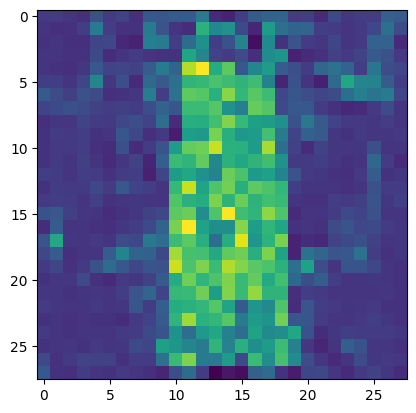

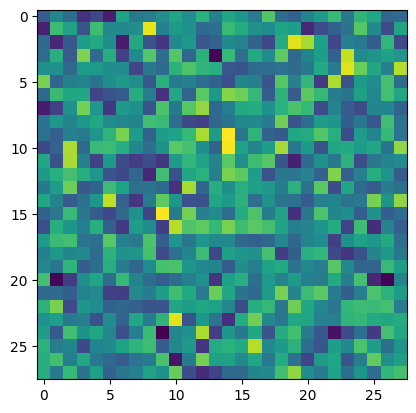

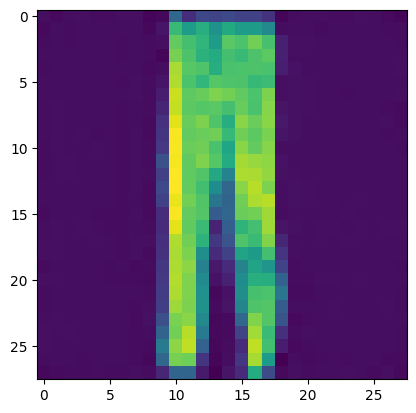

Epoch: 4   Loss: tensor(1.3330, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4095, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.5140, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(3.8792, device='cuda:0', grad_fn=<AddBackward0>)


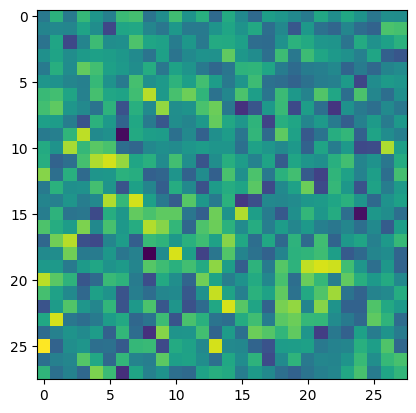

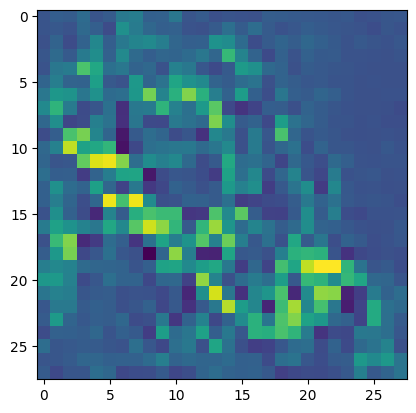

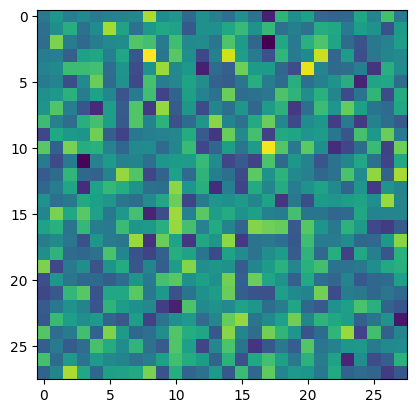

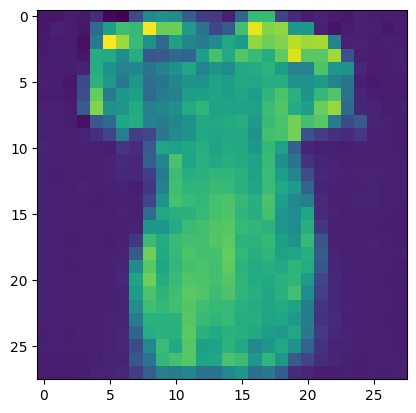

Epoch: 4   Loss: tensor(0.8447, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3879, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0689, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(0.0053, device='cuda:0', grad_fn=<AddBackward0>)


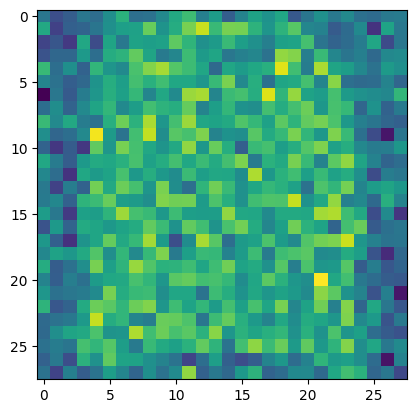

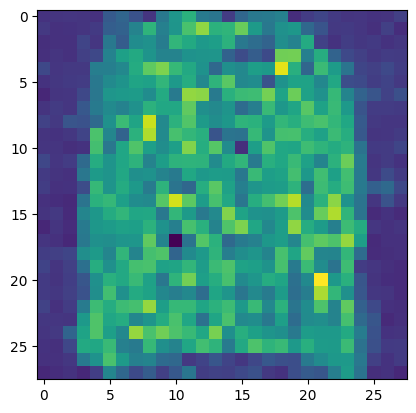

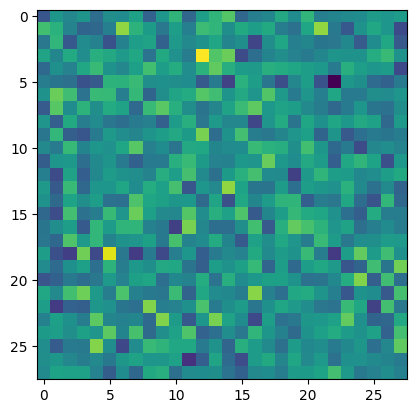

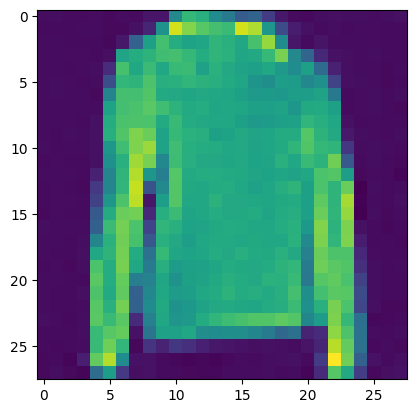

Epoch: 4   Loss: tensor(0.7834, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3916, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 4  Adversarial Loss:tensor(0.2584, device='cuda:0', grad_fn=<AddBackward0>)


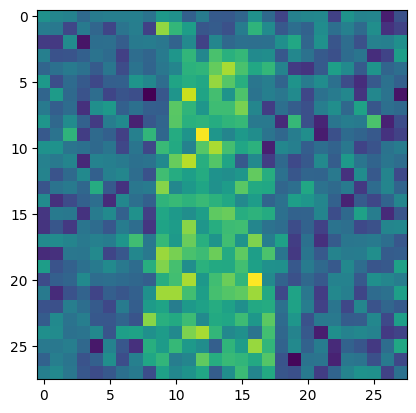

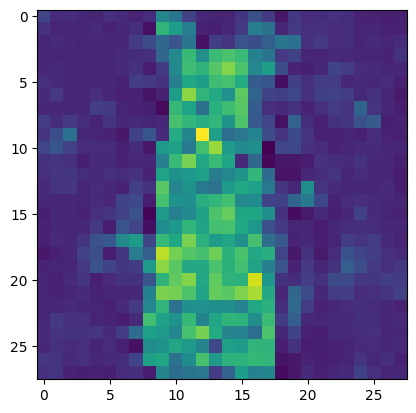

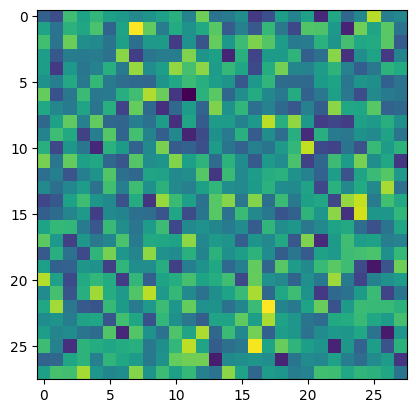

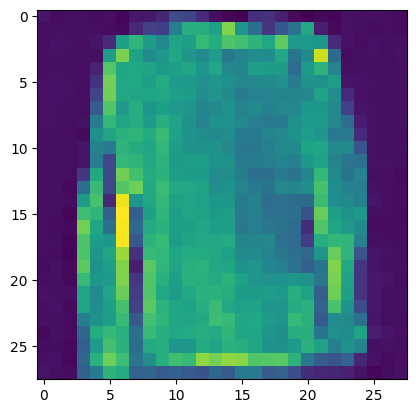

Epoch: 4   Loss: tensor(0.7915, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3957, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(5.6614e-05, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(1.9576, device='cuda:0', grad_fn=<AddBackward0>)


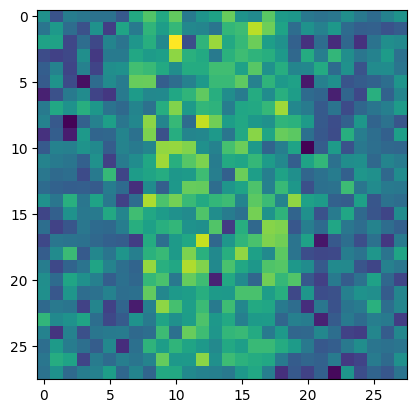

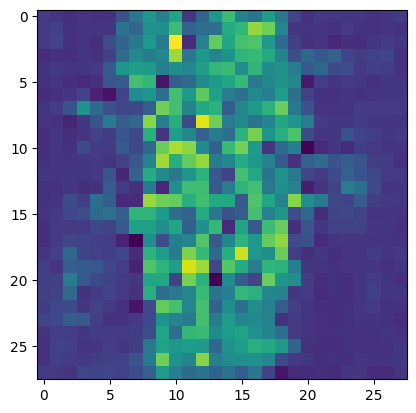

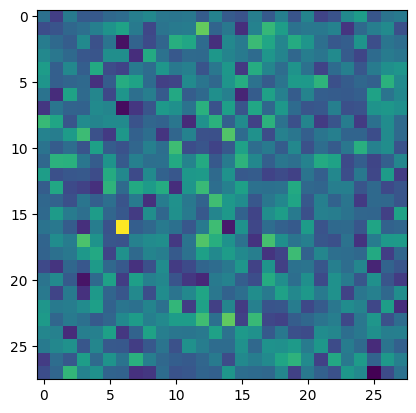

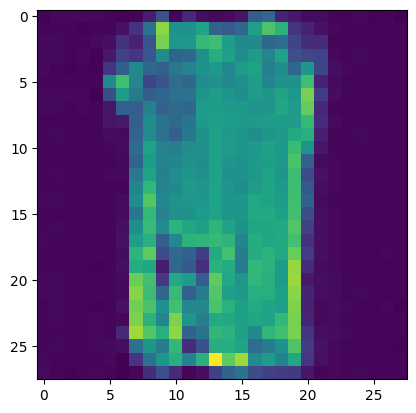

Epoch: 5   Loss: tensor(0.8151, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4075, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(1.6081, device='cuda:0', grad_fn=<AddBackward0>)


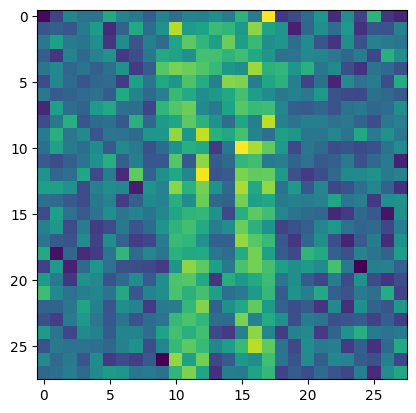

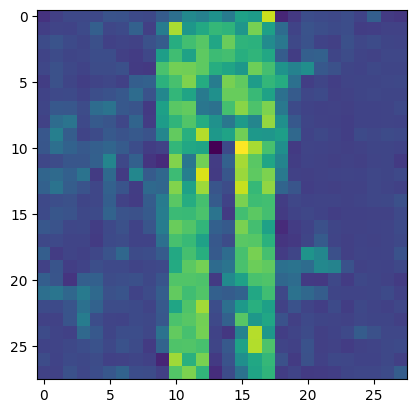

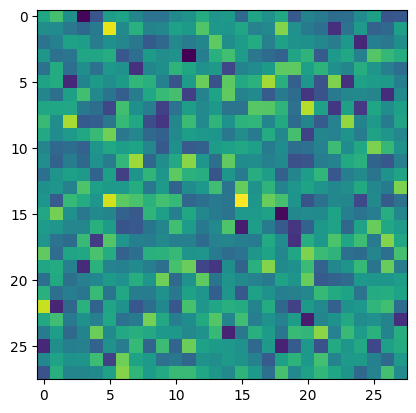

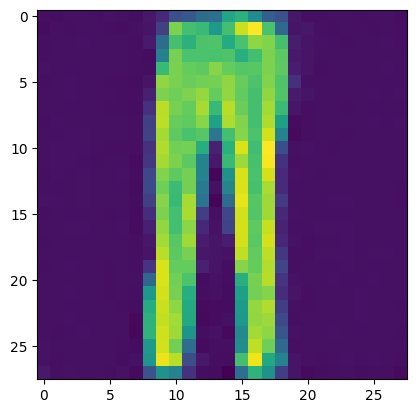

Epoch: 5   Loss: tensor(0.7877, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3933, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(0.1245, device='cuda:0', grad_fn=<AddBackward0>)


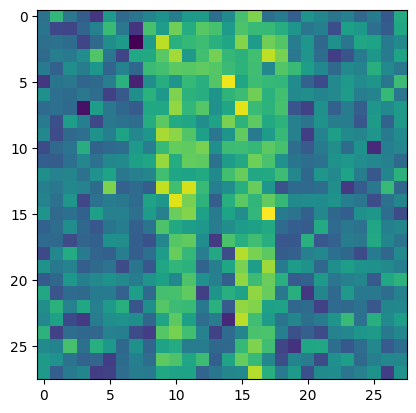

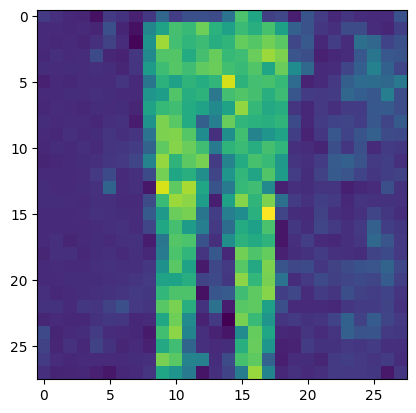

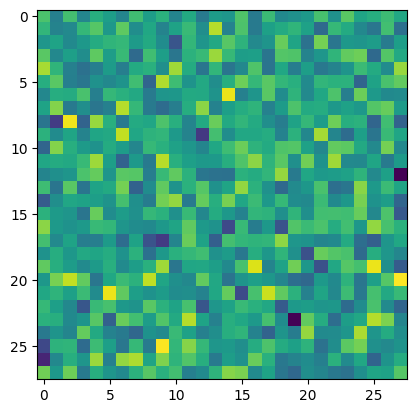

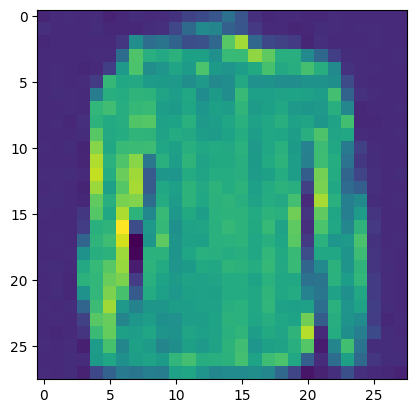

Epoch: 5   Loss: tensor(0.8355, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4012, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0332, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)


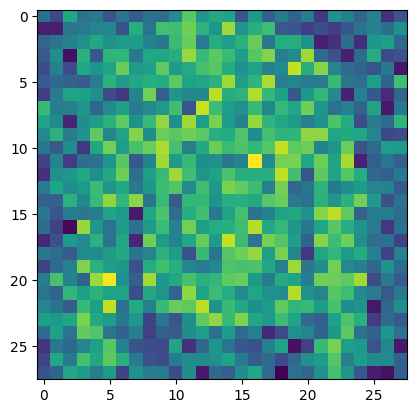

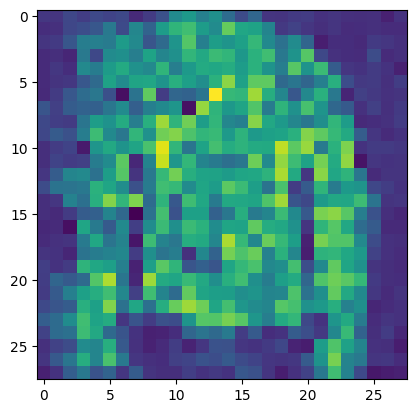

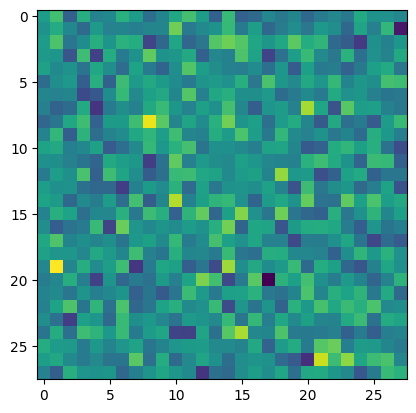

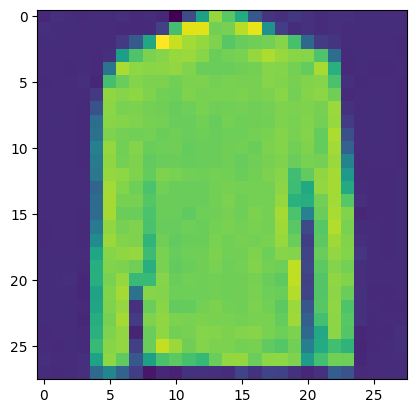

Epoch: 5   Loss: tensor(1.3471, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3975, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.5522, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(0.7471, device='cuda:0', grad_fn=<AddBackward0>)


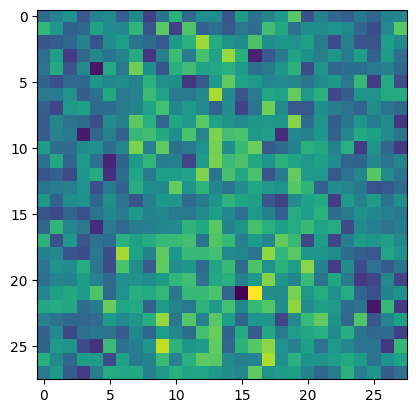

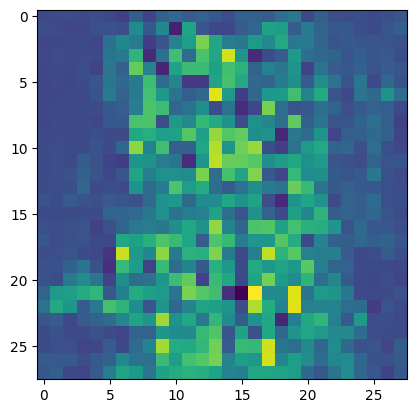

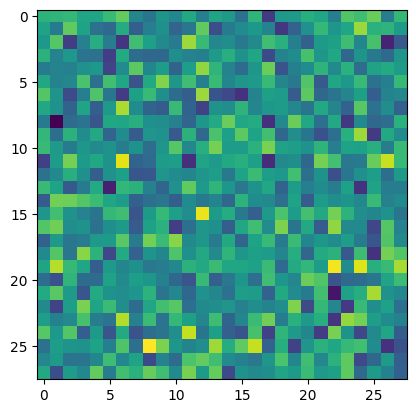

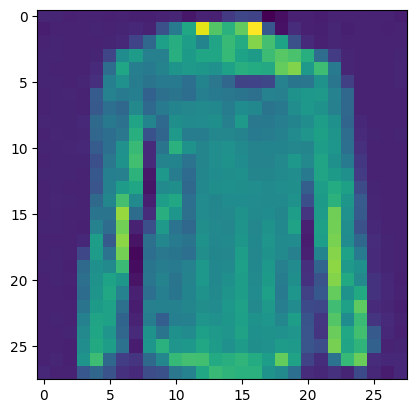

Epoch: 5   Loss: tensor(1.7069, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4001, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.9068, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(0.6543, device='cuda:0', grad_fn=<AddBackward0>)


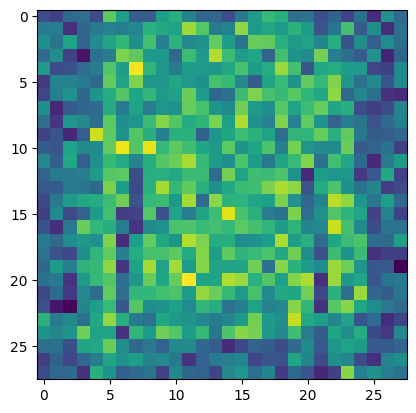

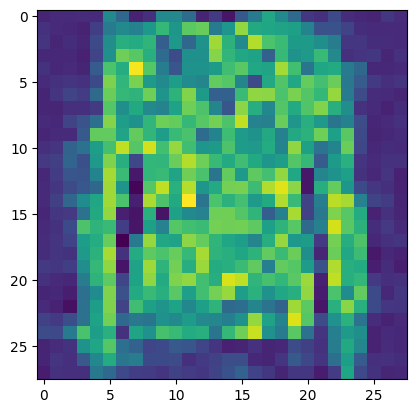

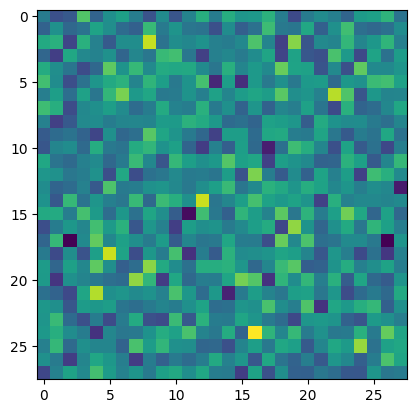

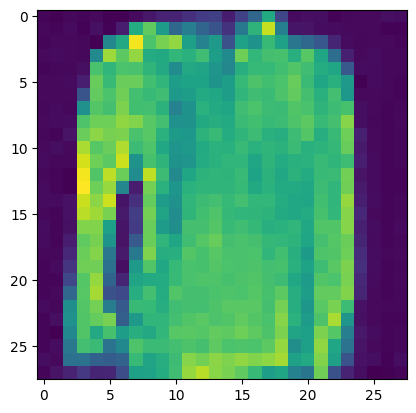

Epoch: 5   Loss: tensor(1.0103, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3968, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.2167, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(0.7901, device='cuda:0', grad_fn=<AddBackward0>)


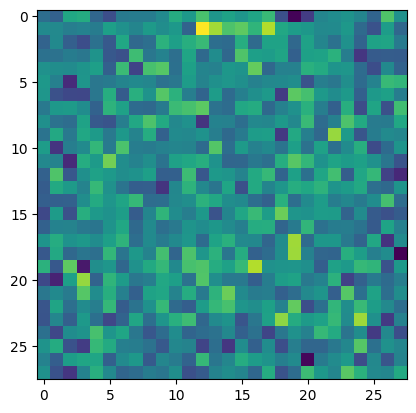

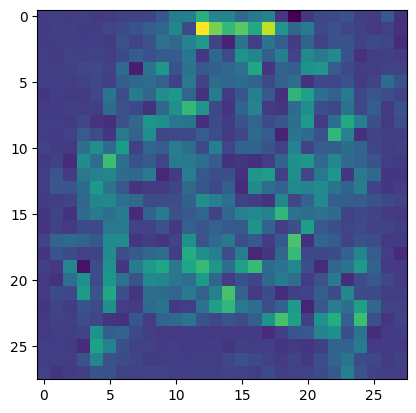

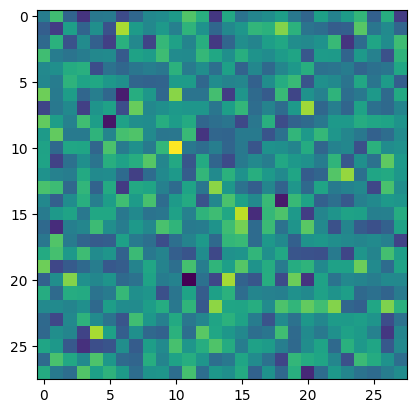

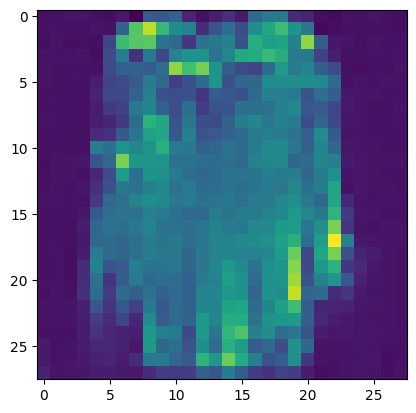

Epoch: 5   Loss: tensor(0.8697, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4158, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0381, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(0.0712, device='cuda:0', grad_fn=<AddBackward0>)


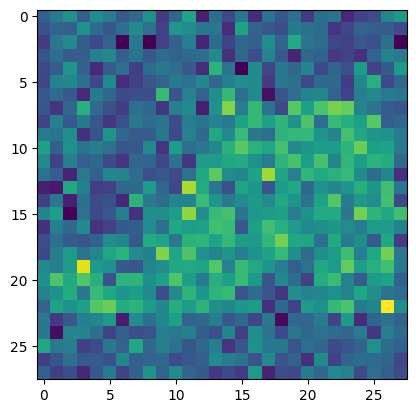

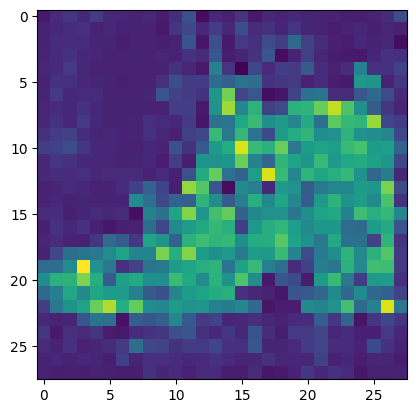

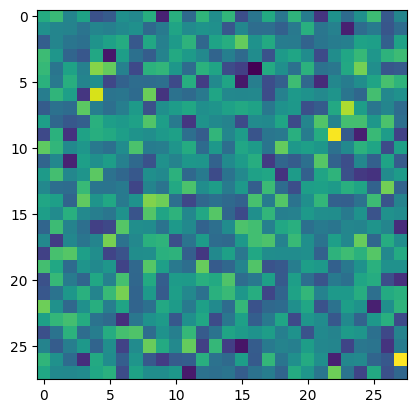

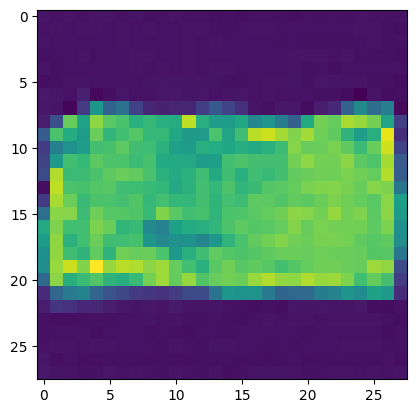

Epoch: 5   Loss: tensor(0.8084, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4032, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0021, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(0.5374, device='cuda:0', grad_fn=<AddBackward0>)


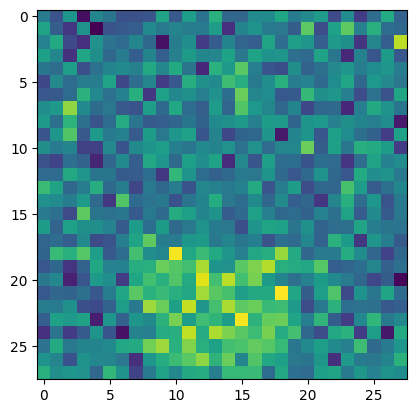

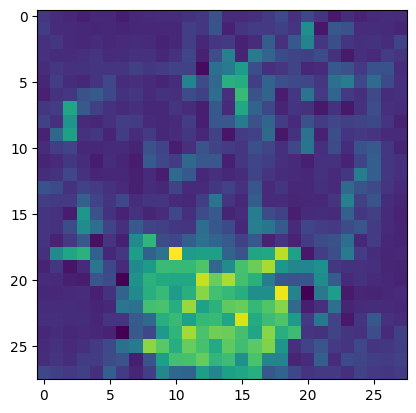

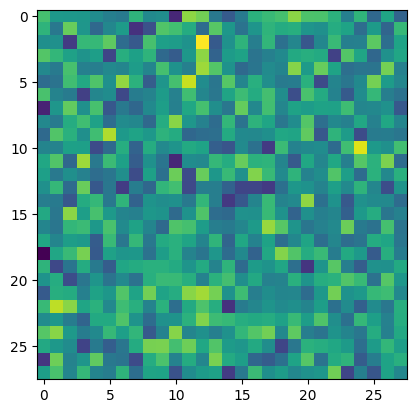

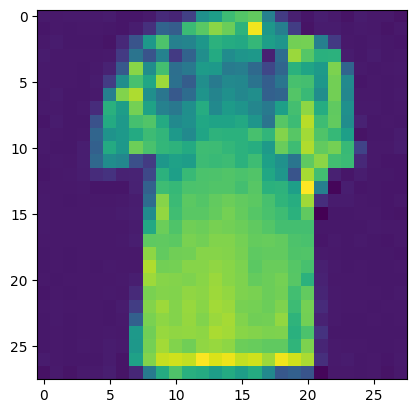

Epoch: 5   Loss: tensor(0.8098, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4047, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 5  Adversarial Loss:tensor(0.3866, device='cuda:0', grad_fn=<AddBackward0>)


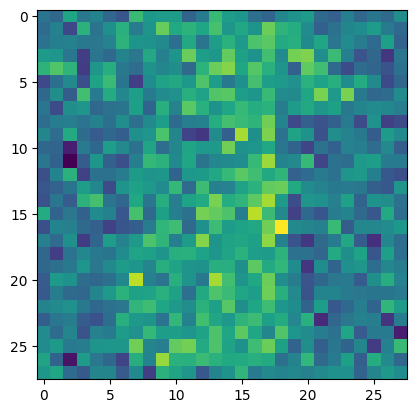

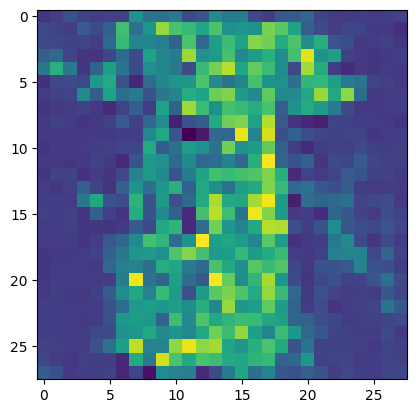

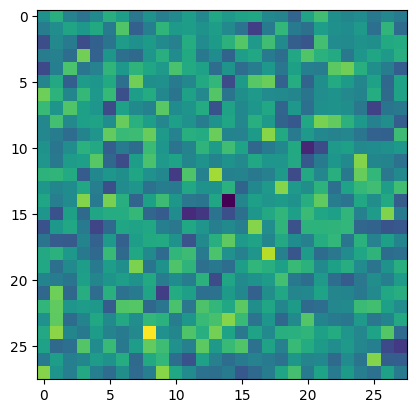

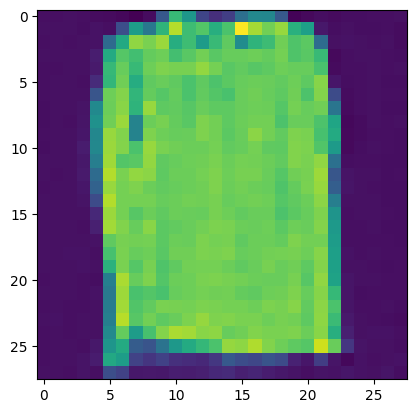

Epoch: 5   Loss: tensor(0.7792, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3884, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0024, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(0.0571, device='cuda:0', grad_fn=<AddBackward0>)


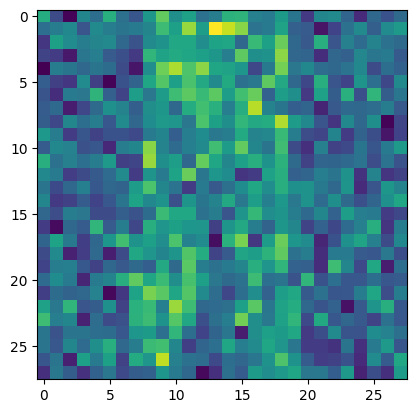

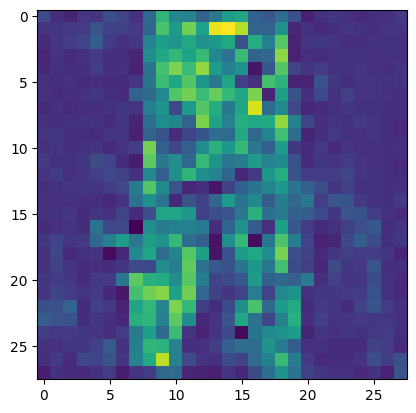

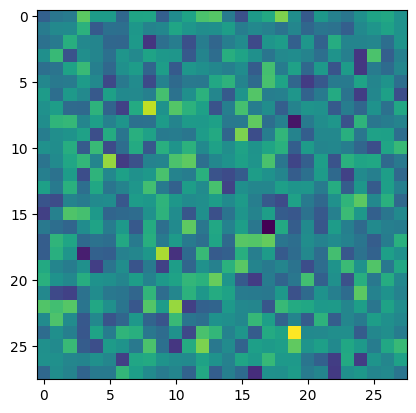

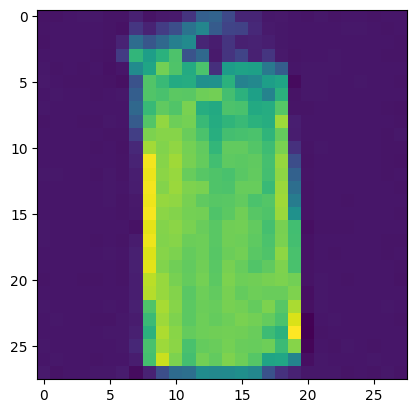

Epoch: 6   Loss: tensor(0.7877, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3913, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0050, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(0.3268, device='cuda:0', grad_fn=<AddBackward0>)


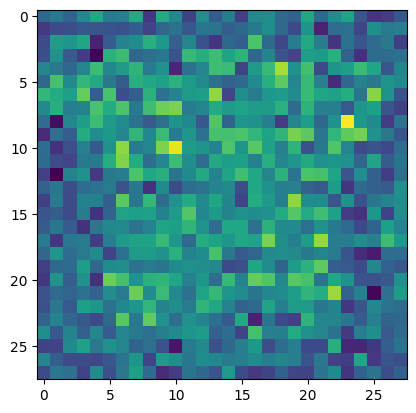

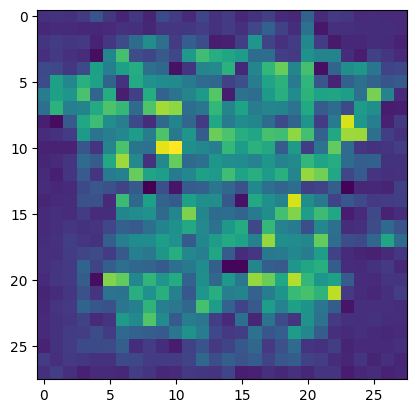

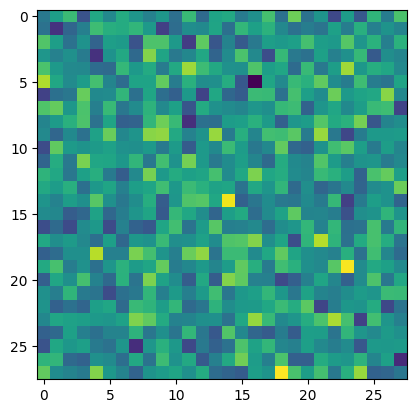

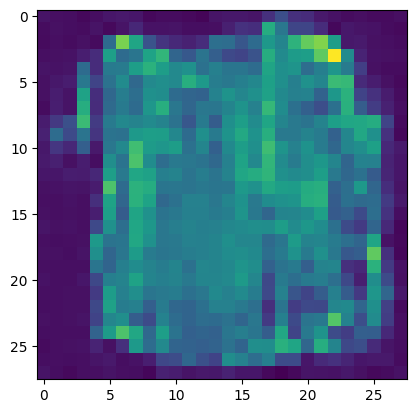

Epoch: 6   Loss: tensor(0.8249, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4122, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(0.0267, device='cuda:0', grad_fn=<AddBackward0>)


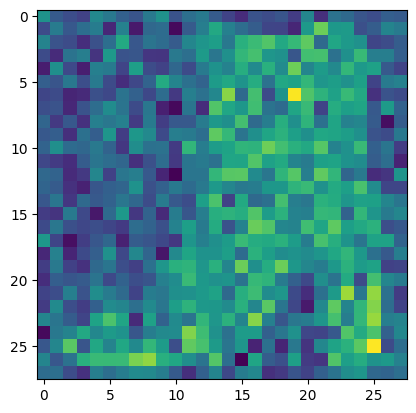

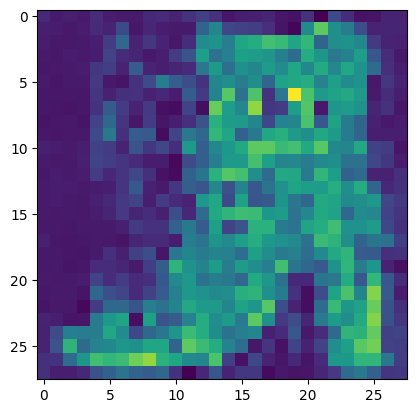

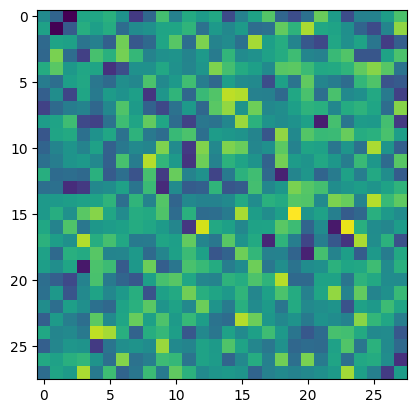

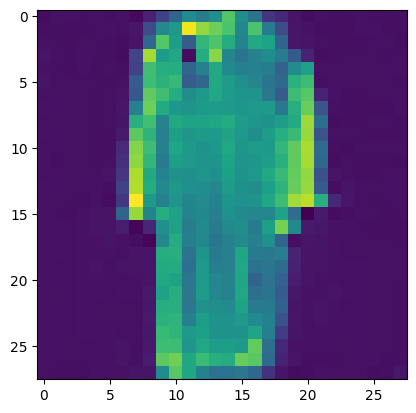

Epoch: 6   Loss: tensor(0.8433, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4008, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0417, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(0.0207, device='cuda:0', grad_fn=<AddBackward0>)


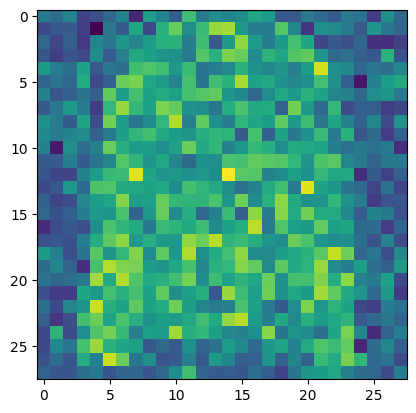

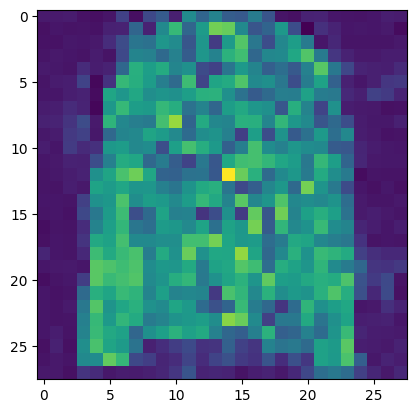

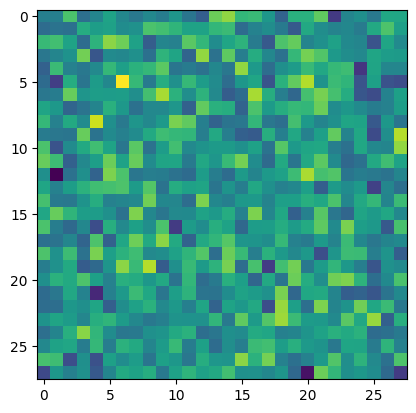

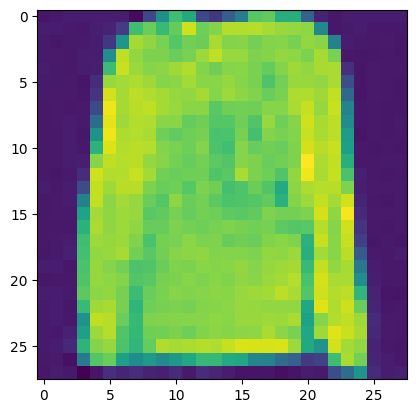

Epoch: 6   Loss: tensor(0.8429, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4059, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0312, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(0.0315, device='cuda:0', grad_fn=<AddBackward0>)


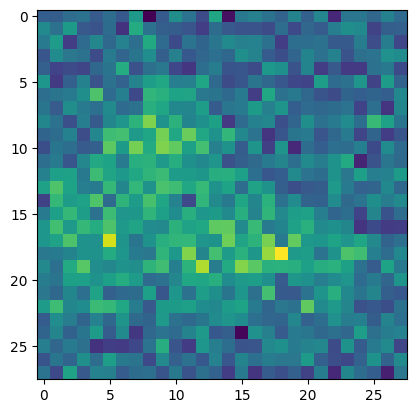

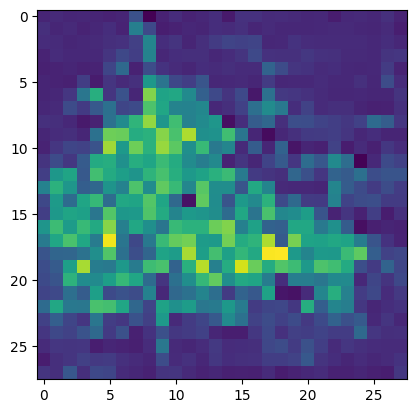

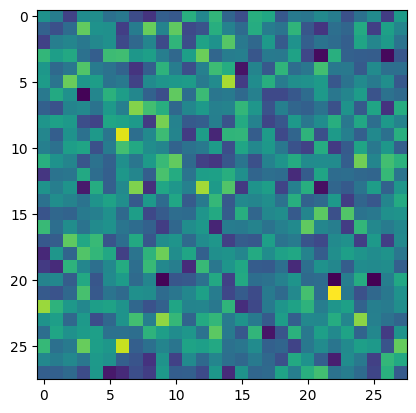

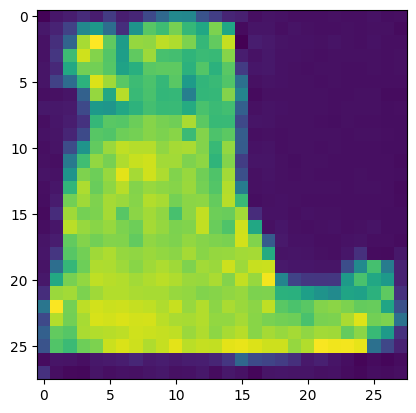

Epoch: 6   Loss: tensor(0.8525, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4149, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0228, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(0.0249, device='cuda:0', grad_fn=<AddBackward0>)


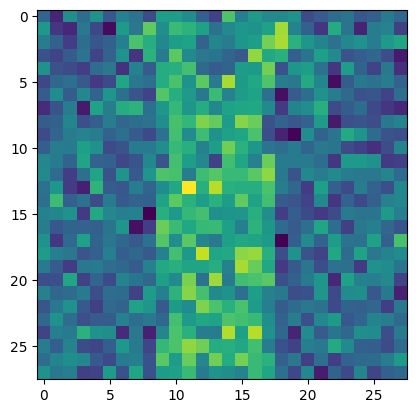

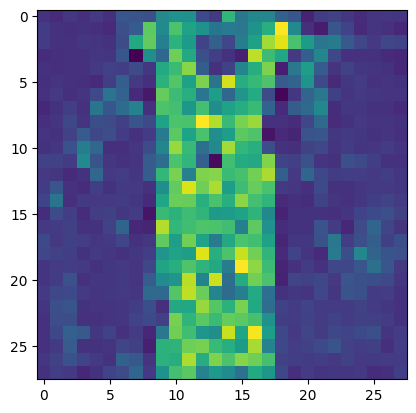

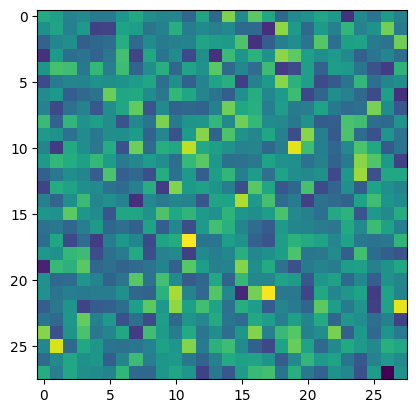

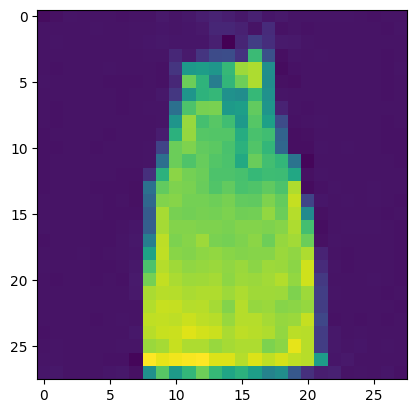

Epoch: 6   Loss: tensor(0.8158, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4010, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(0.0167, device='cuda:0', grad_fn=<AddBackward0>)


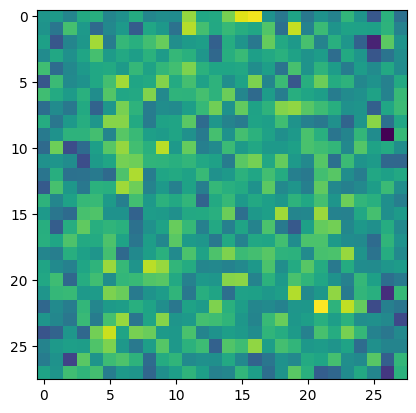

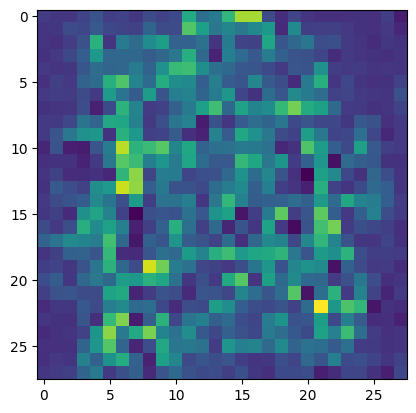

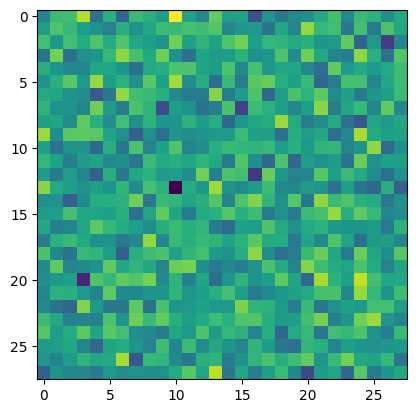

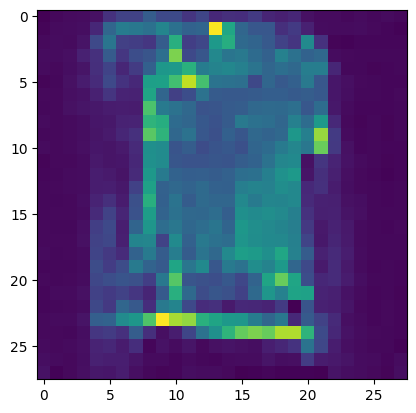

Epoch: 6   Loss: tensor(0.8193, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3984, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0225, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(0.1873, device='cuda:0', grad_fn=<AddBackward0>)


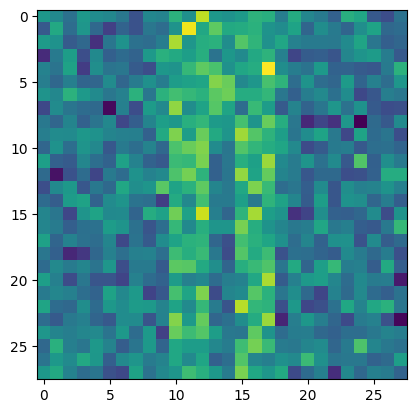

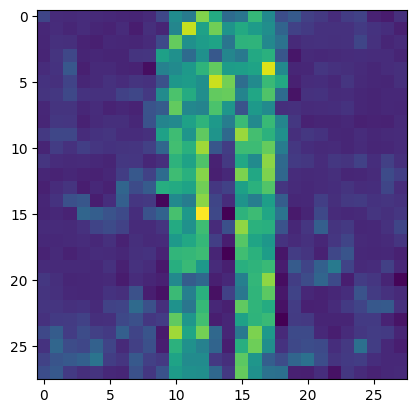

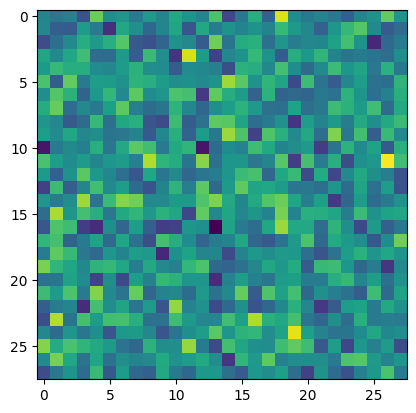

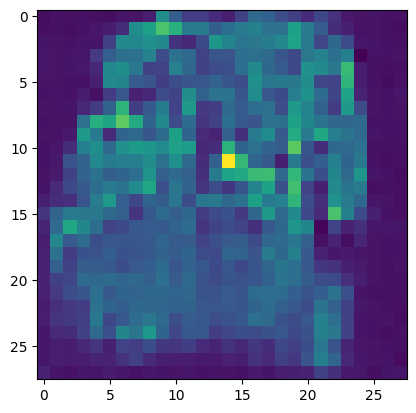

Epoch: 6   Loss: tensor(0.8926, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3913, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1100, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(0.1346, device='cuda:0', grad_fn=<AddBackward0>)


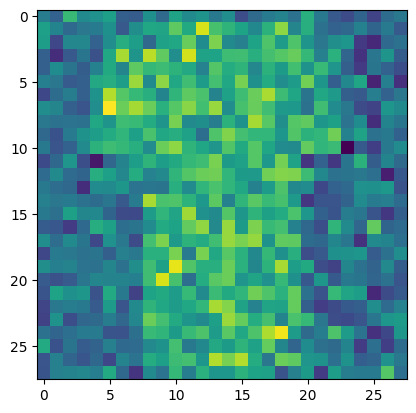

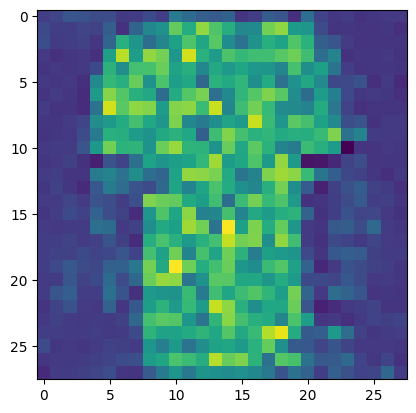

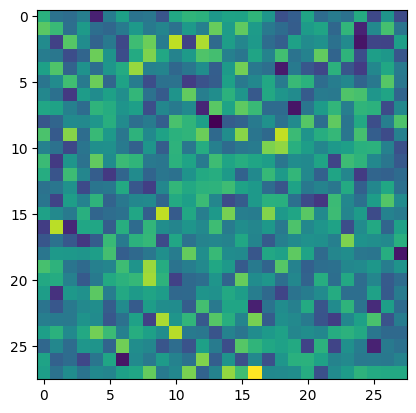

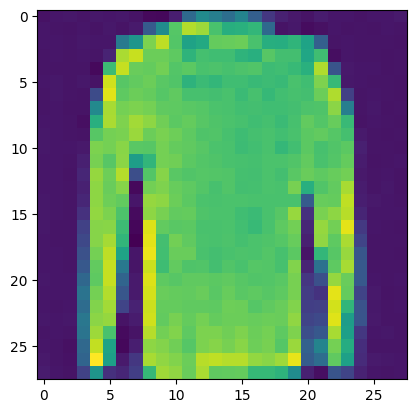

Epoch: 6   Loss: tensor(0.8505, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4043, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 6  Adversarial Loss:tensor(0.0502, device='cuda:0', grad_fn=<AddBackward0>)


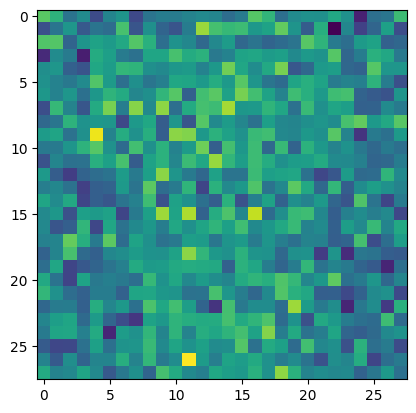

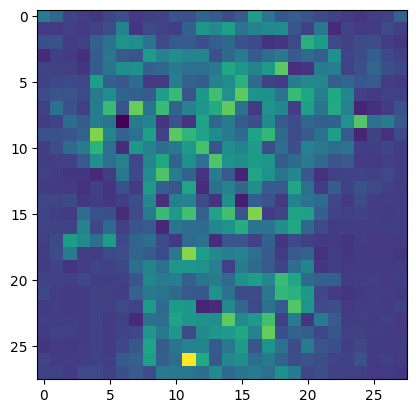

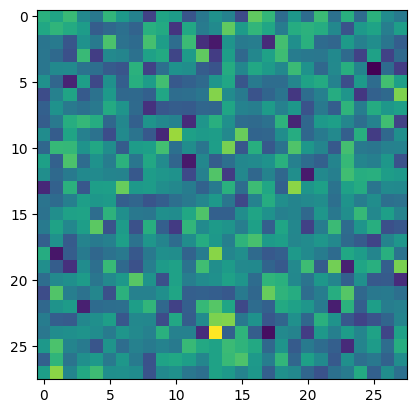

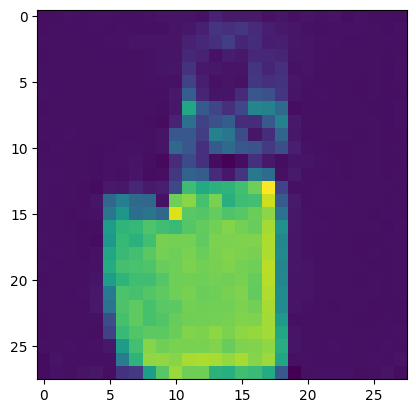

Epoch: 6   Loss: tensor(0.8199, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3890, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0419, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(0.0624, device='cuda:0', grad_fn=<AddBackward0>)


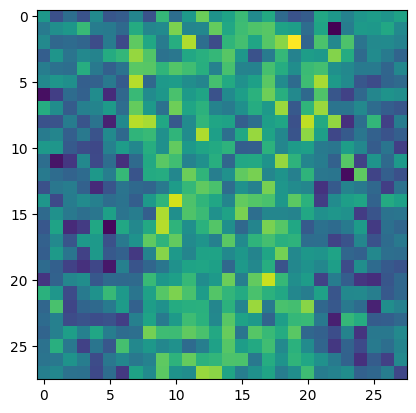

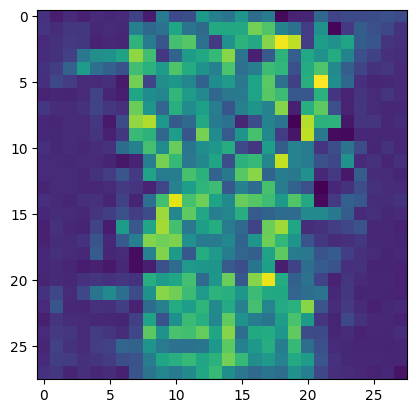

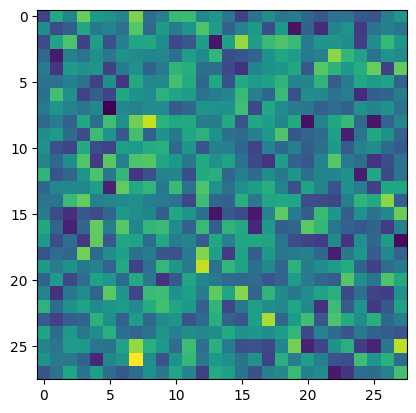

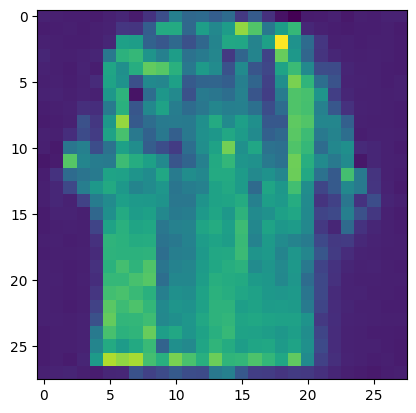

Epoch: 7   Loss: tensor(0.8249, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3903, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0444, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(0.1212, device='cuda:0', grad_fn=<AddBackward0>)


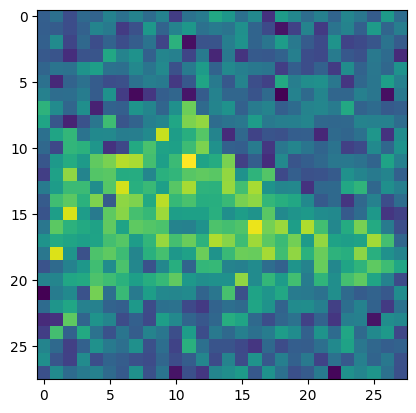

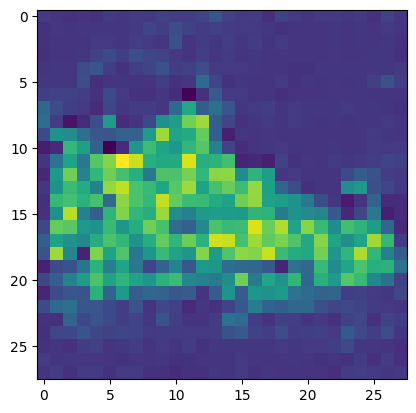

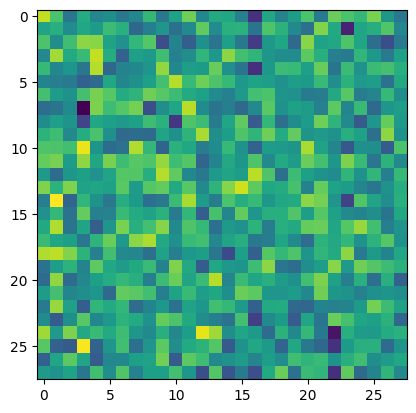

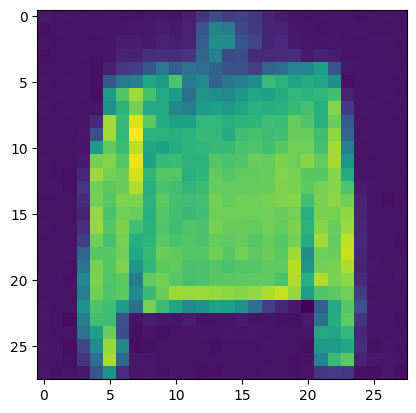

Epoch: 7   Loss: tensor(0.8449, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4155, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0138, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(0.3970, device='cuda:0', grad_fn=<AddBackward0>)


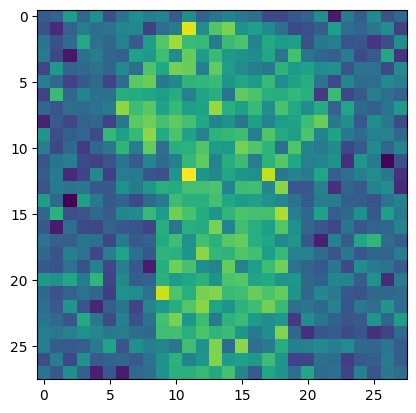

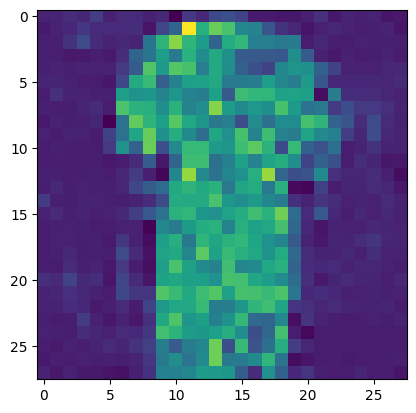

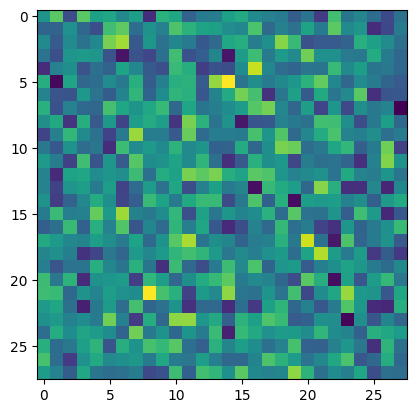

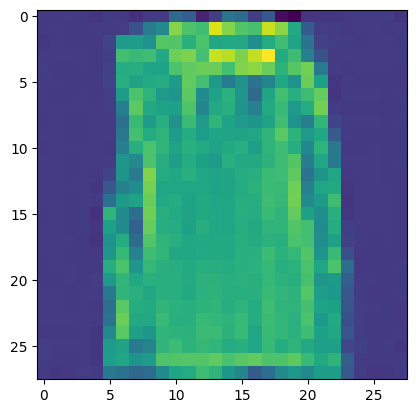

Epoch: 7   Loss: tensor(0.9203, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4054, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1094, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(0.1090, device='cuda:0', grad_fn=<AddBackward0>)


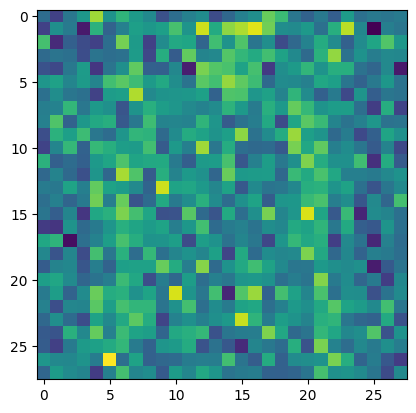

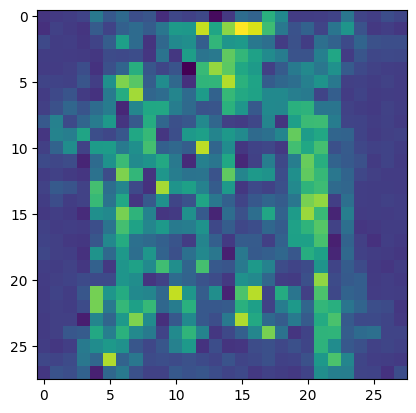

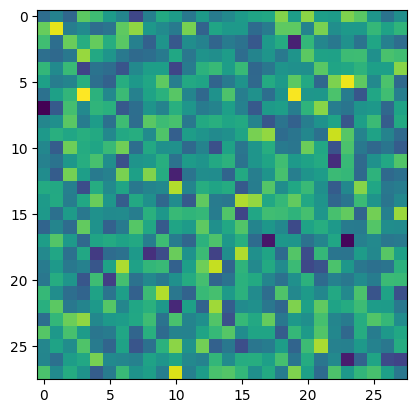

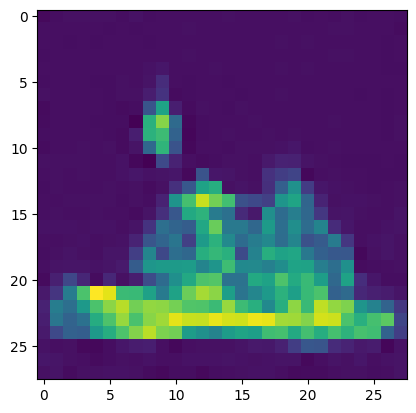

Epoch: 7   Loss: tensor(0.8167, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3905, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0358, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(0.1547, device='cuda:0', grad_fn=<AddBackward0>)


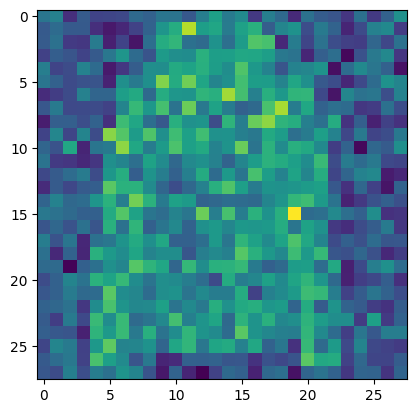

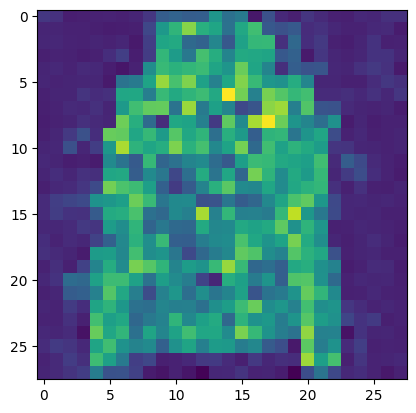

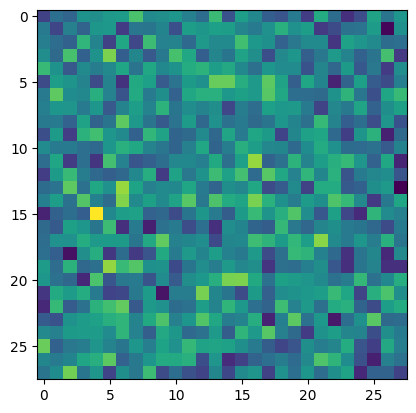

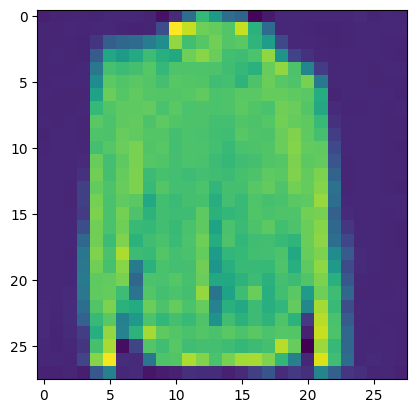

Epoch: 7   Loss: tensor(0.7982, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3985, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(1.1293, device='cuda:0', grad_fn=<AddBackward0>)


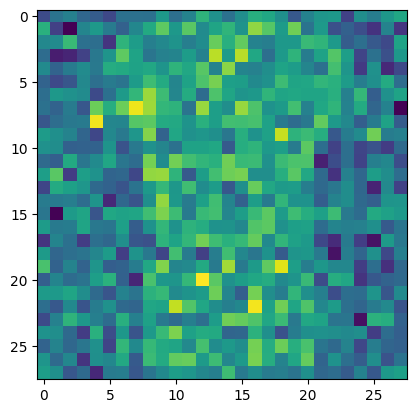

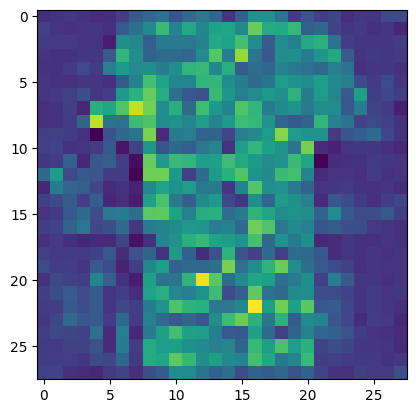

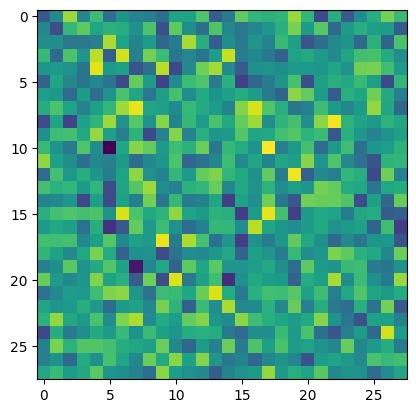

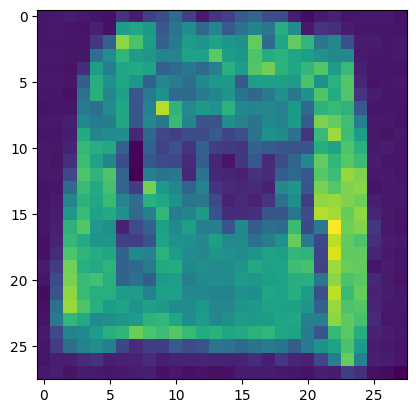

Epoch: 7   Loss: tensor(0.7922, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3937, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0048, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(0.0206, device='cuda:0', grad_fn=<AddBackward0>)


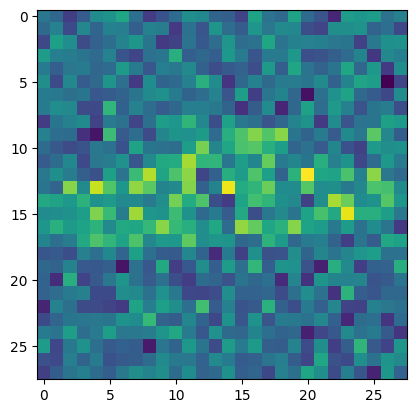

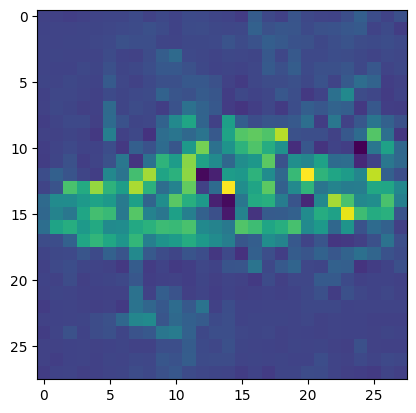

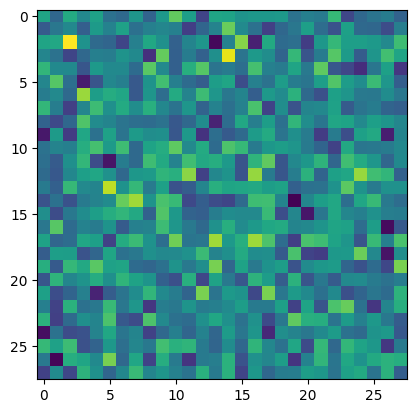

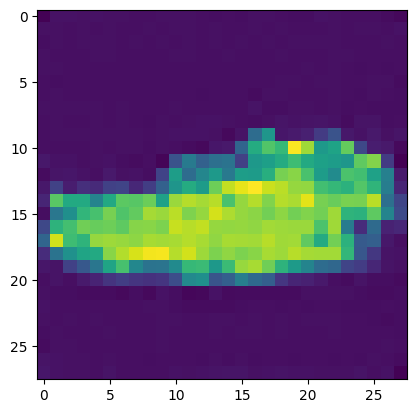

Epoch: 7   Loss: tensor(0.8242, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3917, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0409, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(0.0492, device='cuda:0', grad_fn=<AddBackward0>)


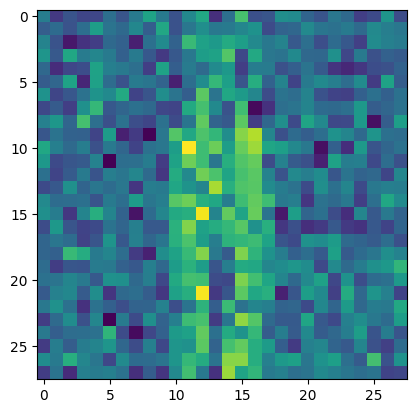

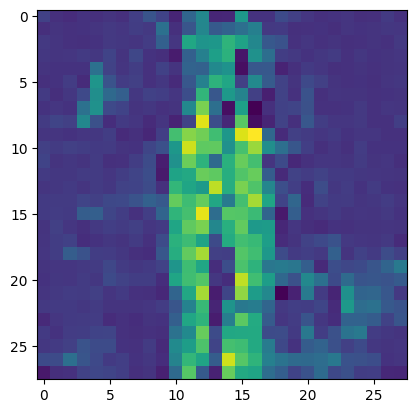

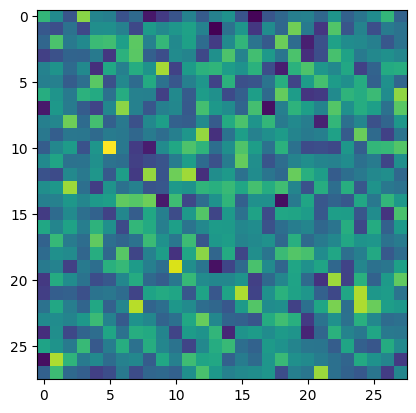

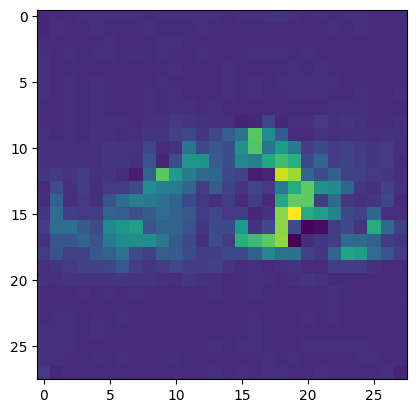

Epoch: 7   Loss: tensor(0.8864, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4092, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0680, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(0.2427, device='cuda:0', grad_fn=<AddBackward0>)


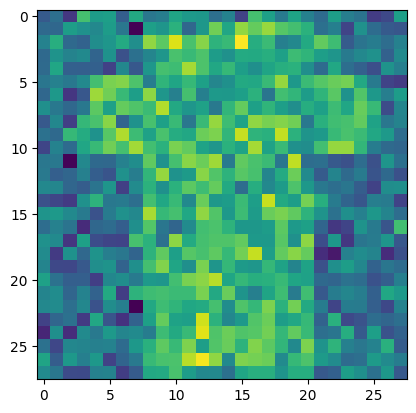

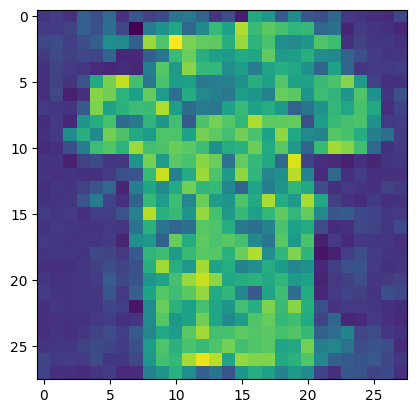

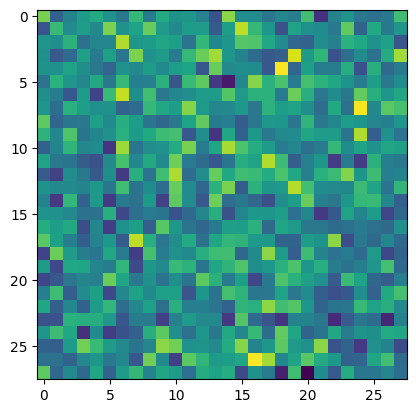

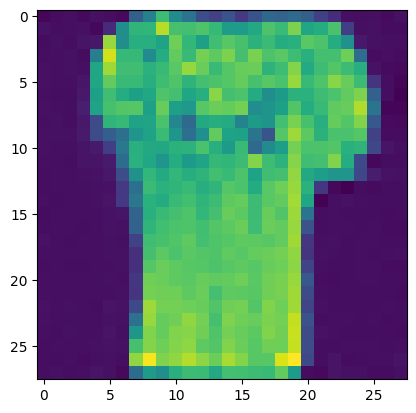

Epoch: 7   Loss: tensor(1.0544, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4020, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.2503, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 7  Adversarial Loss:tensor(0.0235, device='cuda:0', grad_fn=<AddBackward0>)


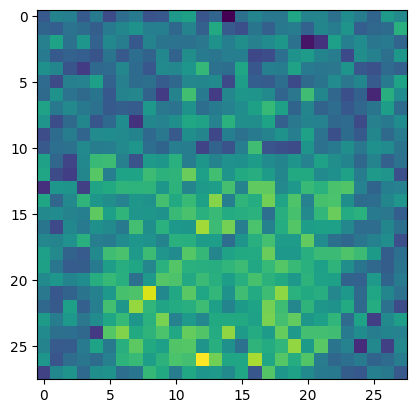

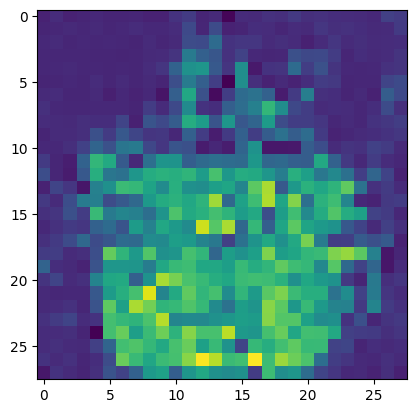

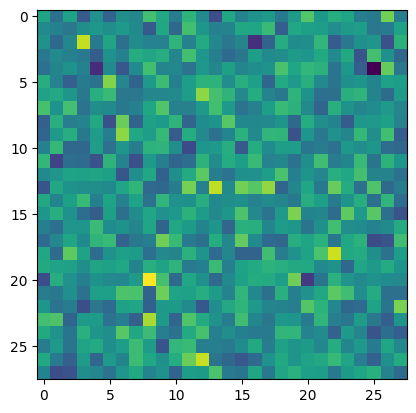

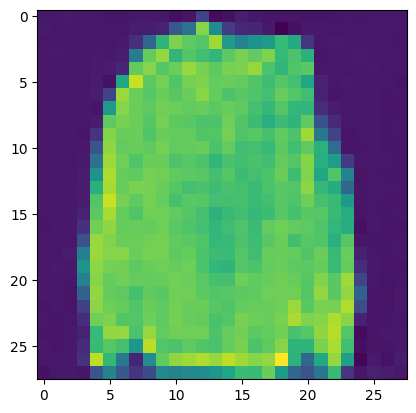

Epoch: 7   Loss: tensor(0.7960, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3886, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0187, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(0.1502, device='cuda:0', grad_fn=<AddBackward0>)


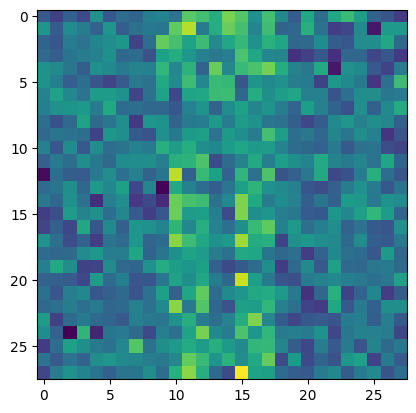

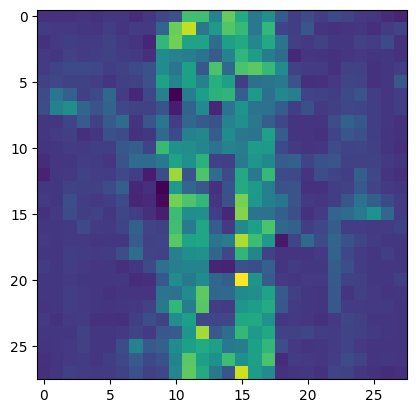

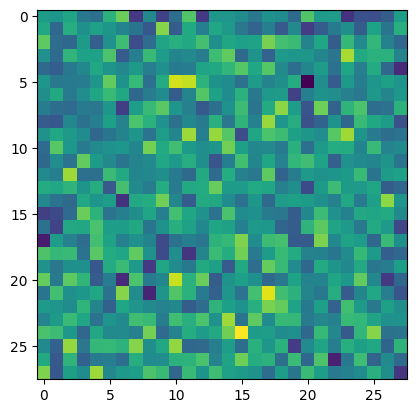

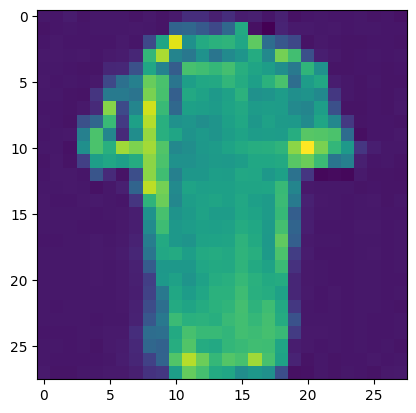

Epoch: 8   Loss: tensor(0.8373, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3784, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0804, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(0.0559, device='cuda:0', grad_fn=<AddBackward0>)


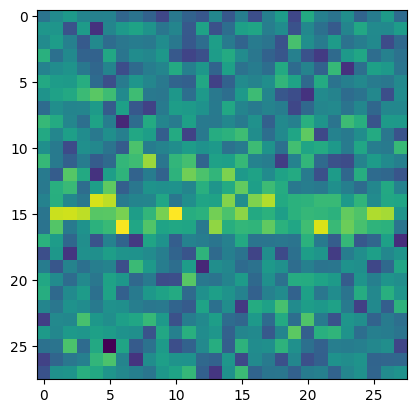

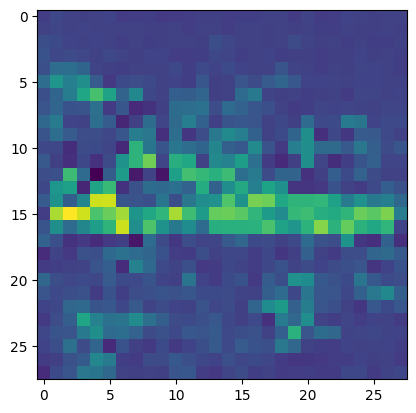

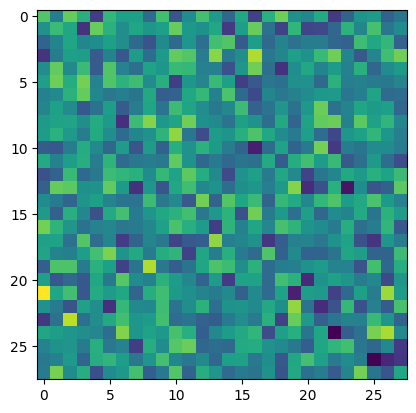

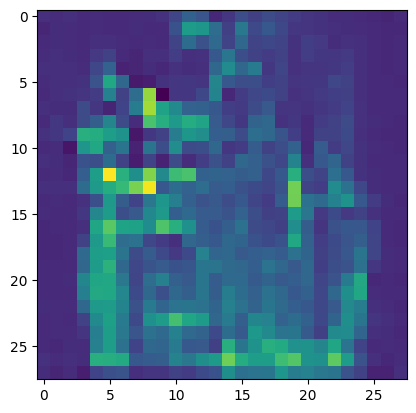

Epoch: 8   Loss: tensor(0.8449, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4059, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0330, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(0.2258, device='cuda:0', grad_fn=<AddBackward0>)


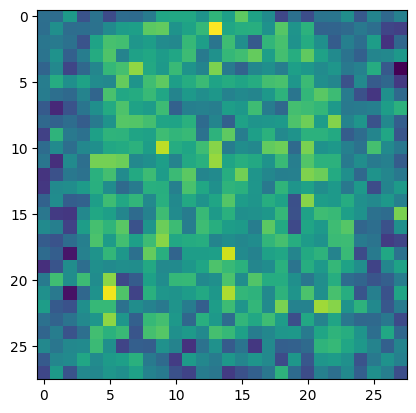

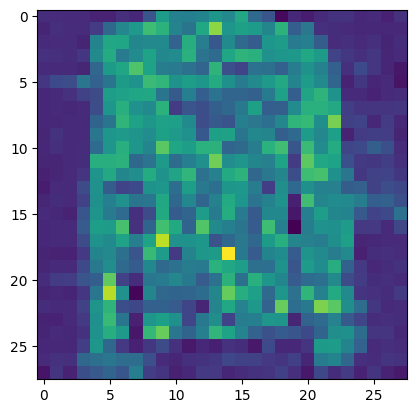

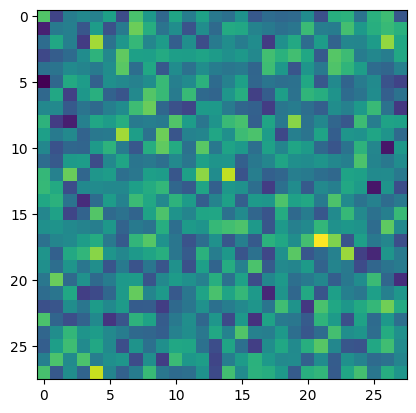

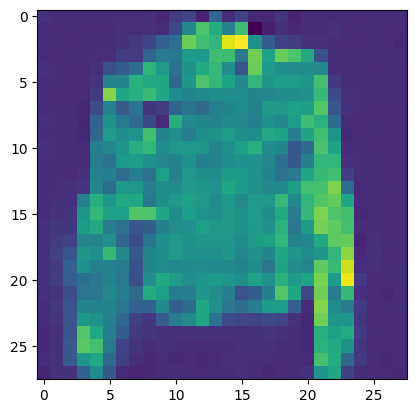

Epoch: 8   Loss: tensor(0.7933, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3874, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0185, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(0.0136, device='cuda:0', grad_fn=<AddBackward0>)


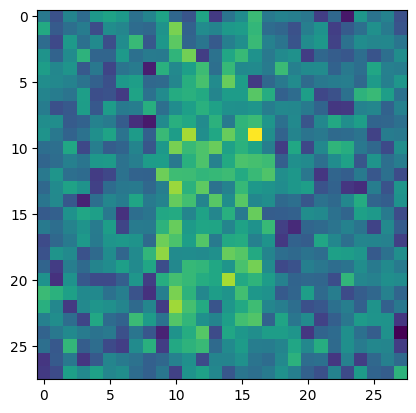

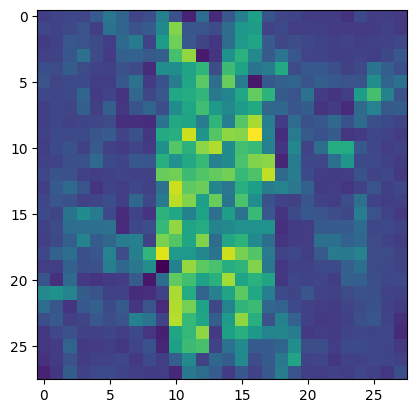

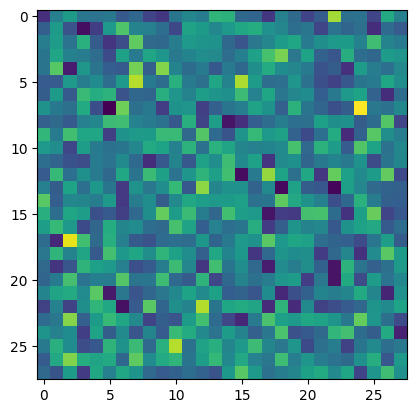

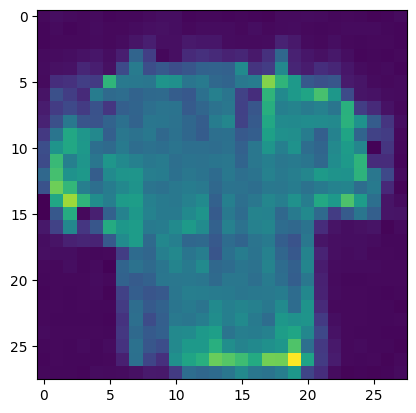

Epoch: 8   Loss: tensor(0.8091, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4043, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(0.0611, device='cuda:0', grad_fn=<AddBackward0>)


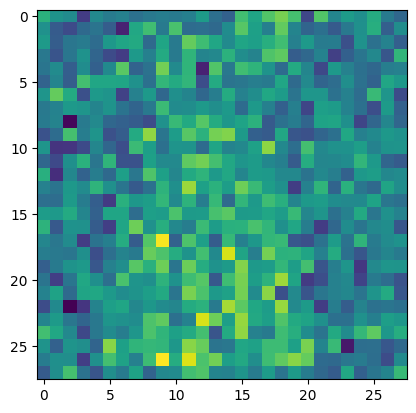

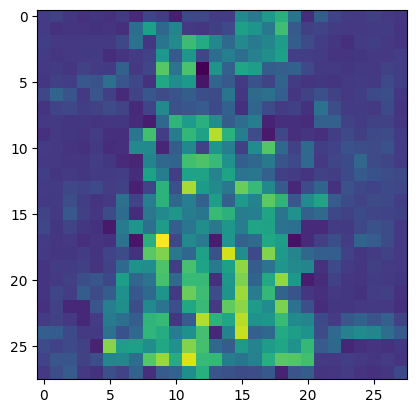

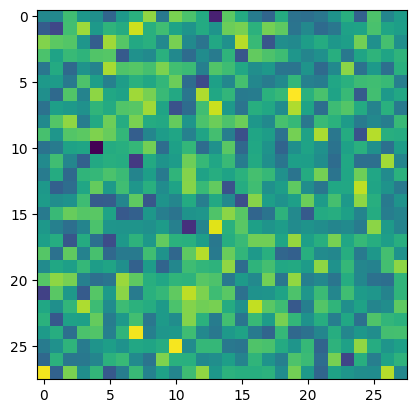

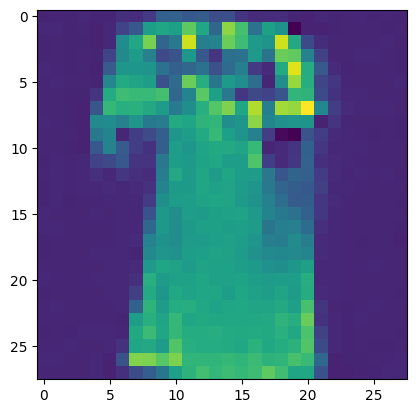

Epoch: 8   Loss: tensor(0.7871, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3935, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(0.0239, device='cuda:0', grad_fn=<AddBackward0>)


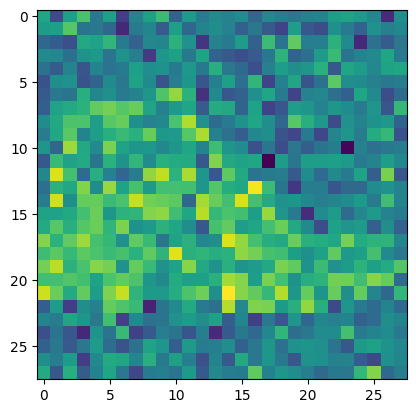

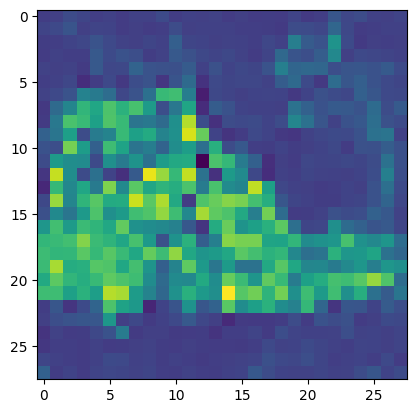

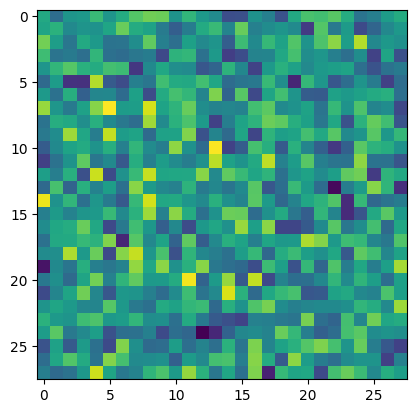

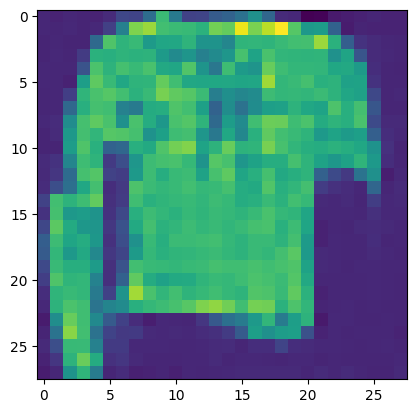

Epoch: 8   Loss: tensor(0.8424, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4210, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(0.0257, device='cuda:0', grad_fn=<AddBackward0>)


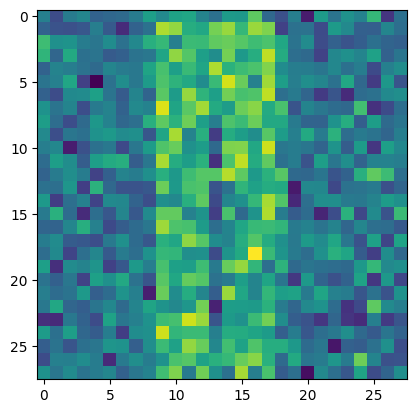

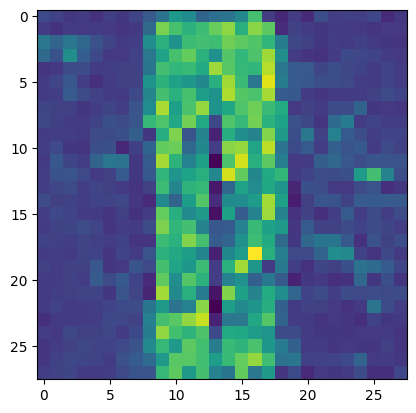

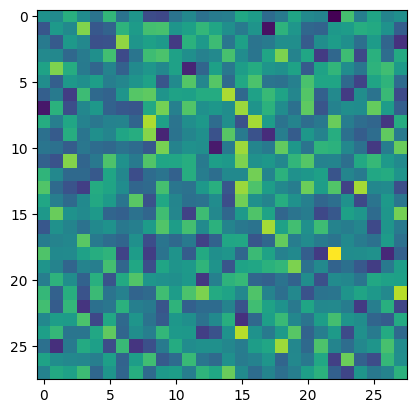

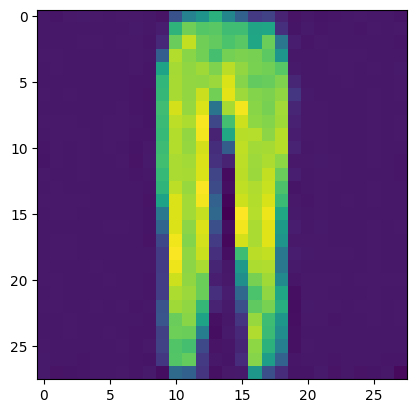

Epoch: 8   Loss: tensor(0.8169, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4083, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(1.8430, device='cuda:0', grad_fn=<AddBackward0>)


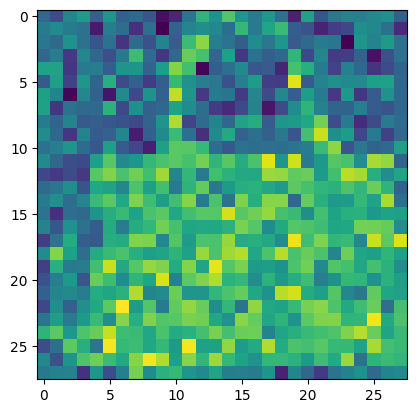

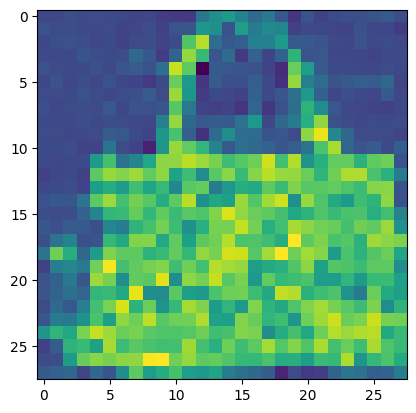

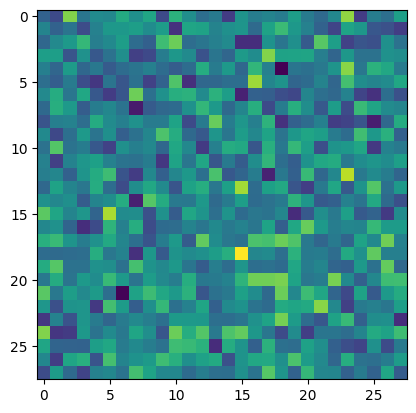

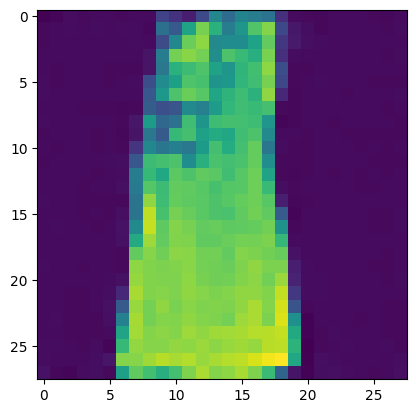

Epoch: 8   Loss: tensor(0.8077, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4036, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(0.0201, device='cuda:0', grad_fn=<AddBackward0>)


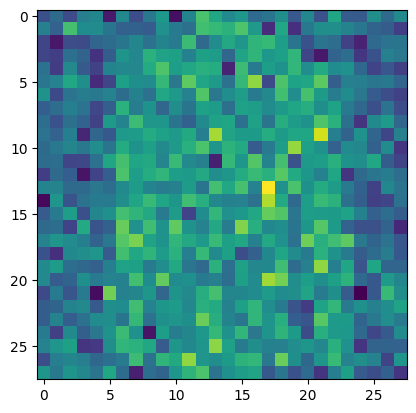

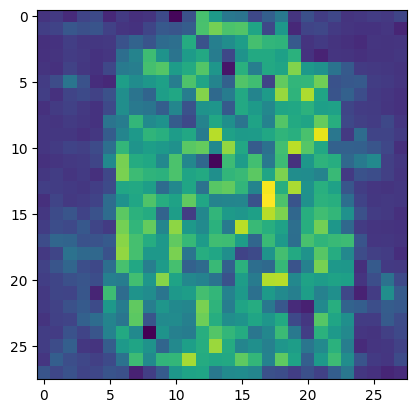

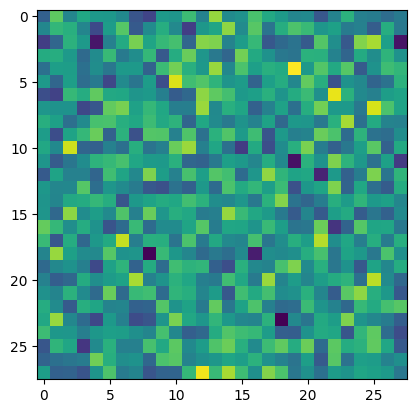

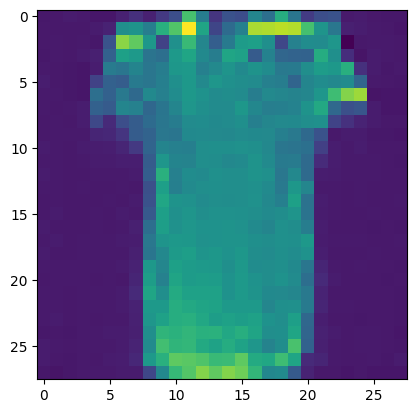

Epoch: 8   Loss: tensor(0.8009, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3977, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0055, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 8  Adversarial Loss:tensor(0.0109, device='cuda:0', grad_fn=<AddBackward0>)


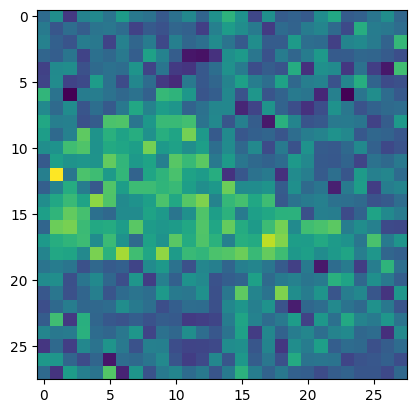

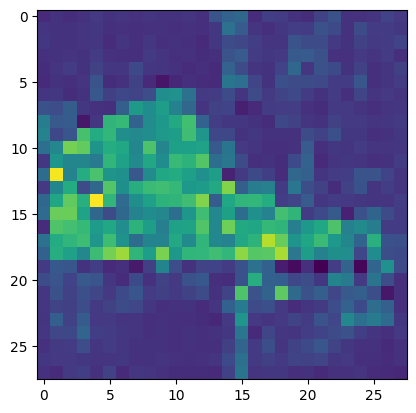

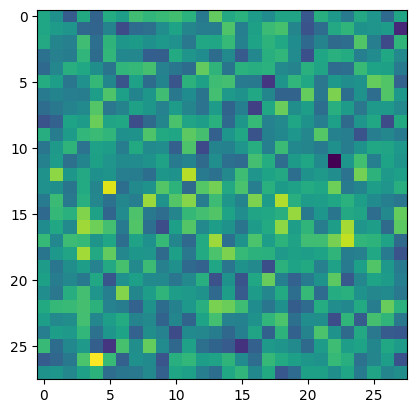

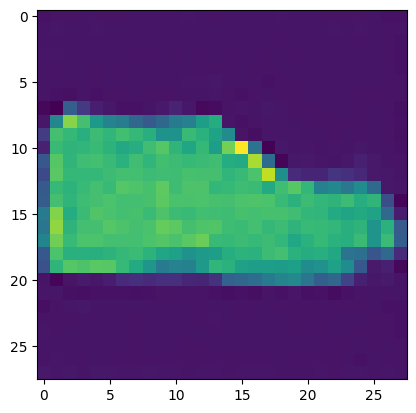

Epoch: 8   Loss: tensor(1.0032, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4087, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1858, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(0.0499, device='cuda:0', grad_fn=<AddBackward0>)


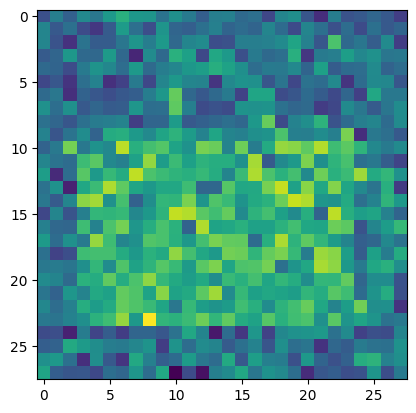

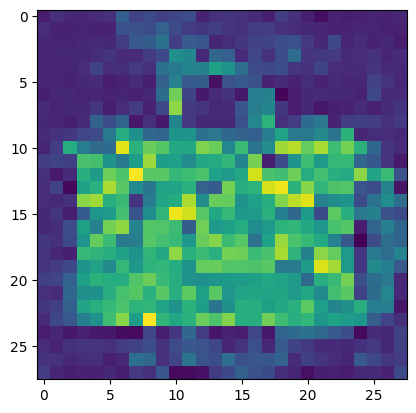

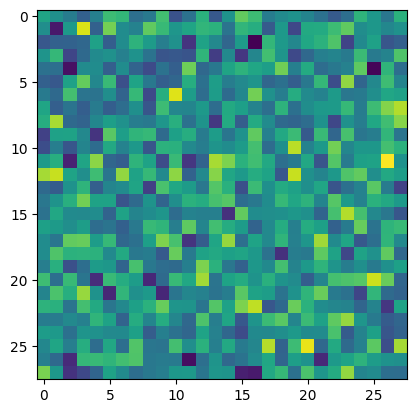

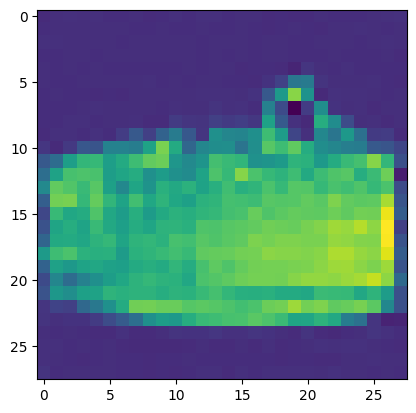

Epoch: 9   Loss: tensor(1.3456, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4058, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.5340, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(1.8294, device='cuda:0', grad_fn=<AddBackward0>)


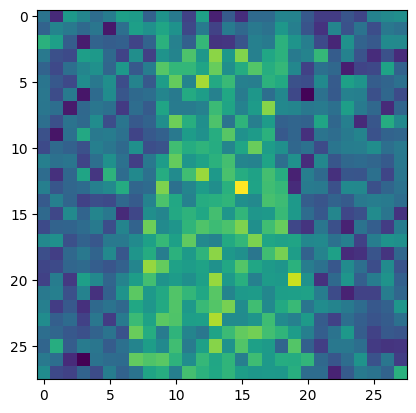

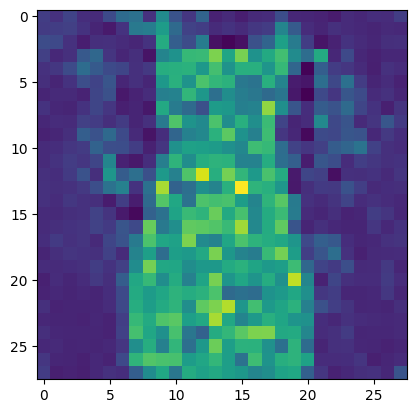

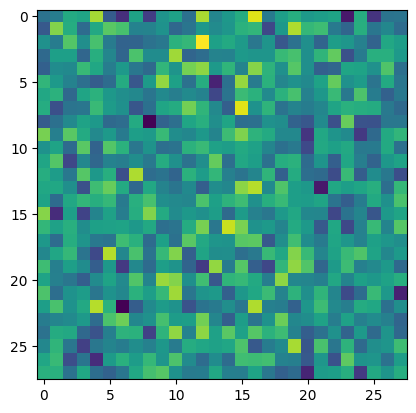

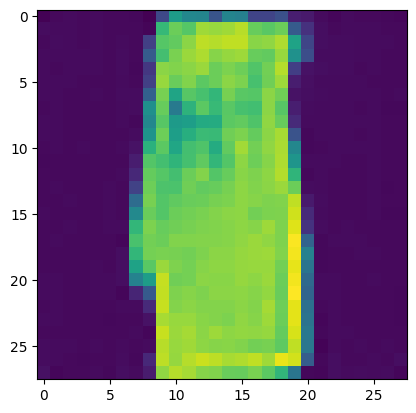

Epoch: 9   Loss: tensor(0.9473, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3972, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1529, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(0.2262, device='cuda:0', grad_fn=<AddBackward0>)


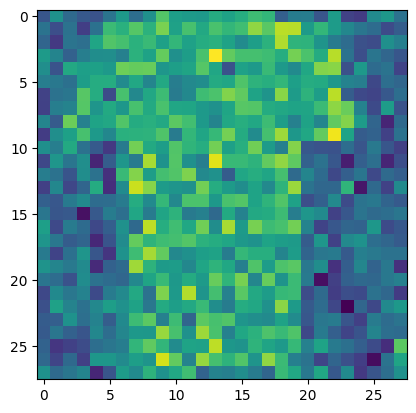

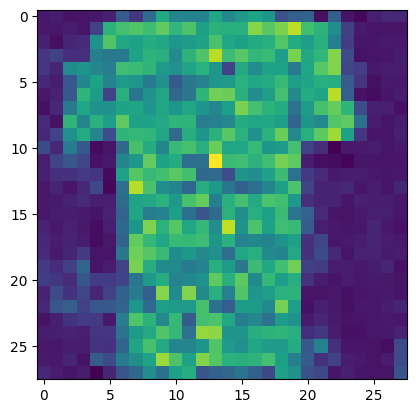

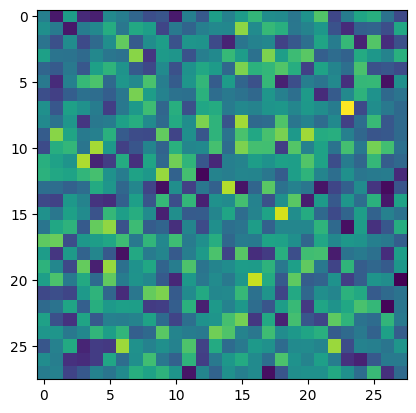

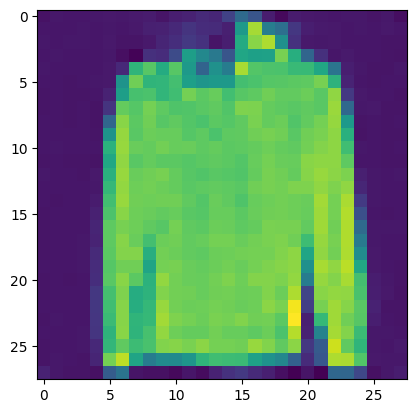

Epoch: 9   Loss: tensor(0.8440, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4186, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0067, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(0.0054, device='cuda:0', grad_fn=<AddBackward0>)


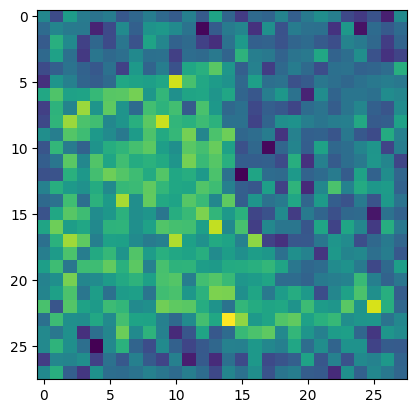

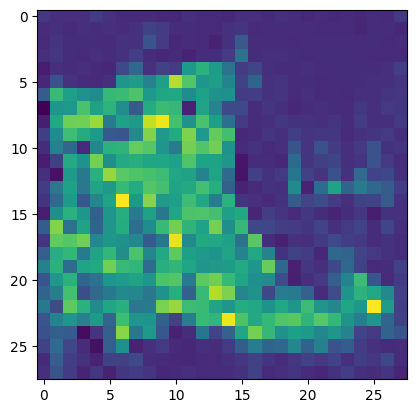

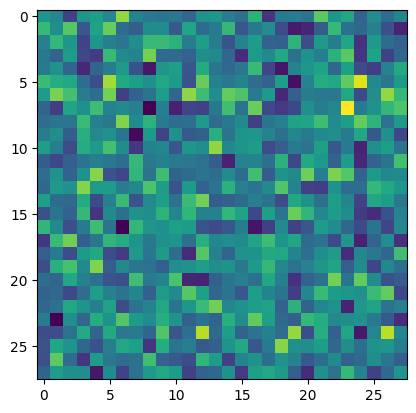

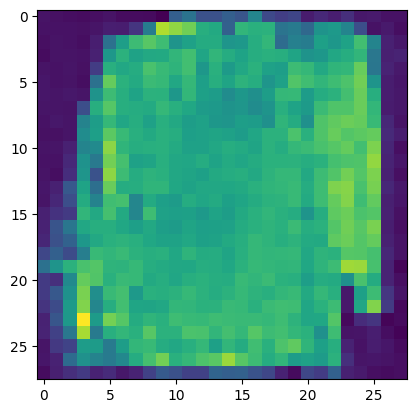

Epoch: 9   Loss: tensor(0.8315, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4156, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(0.0047, device='cuda:0', grad_fn=<AddBackward0>)


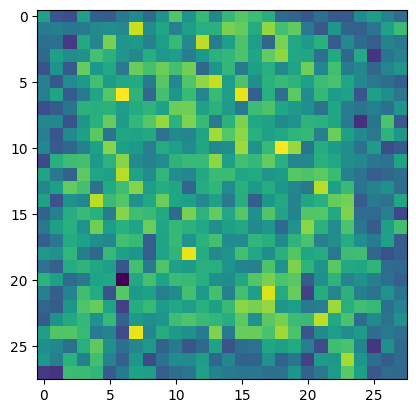

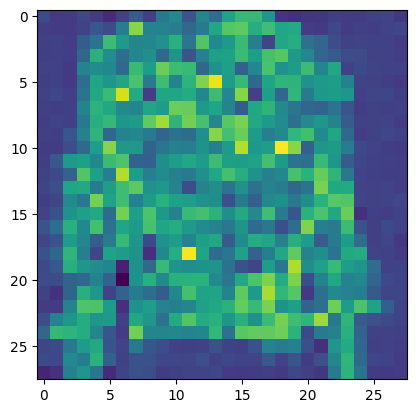

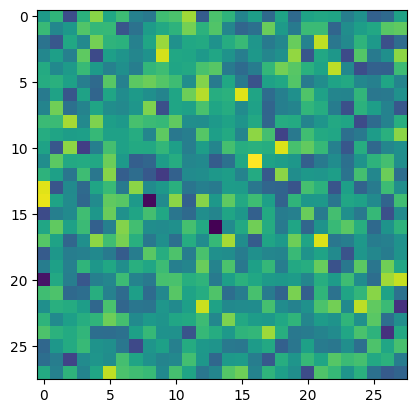

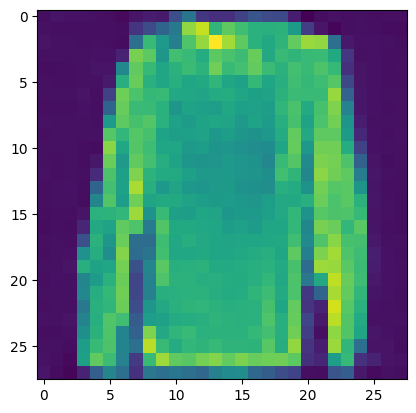

Epoch: 9   Loss: tensor(0.7831, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3913, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0005, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(0.0688, device='cuda:0', grad_fn=<AddBackward0>)


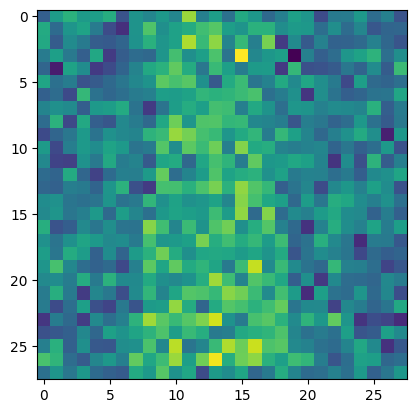

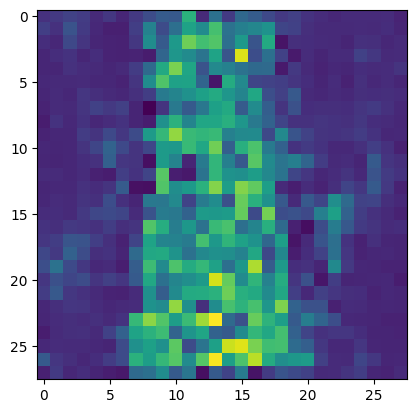

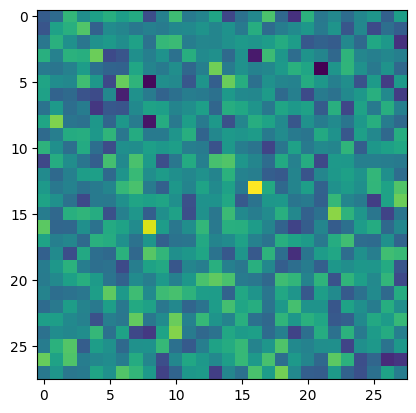

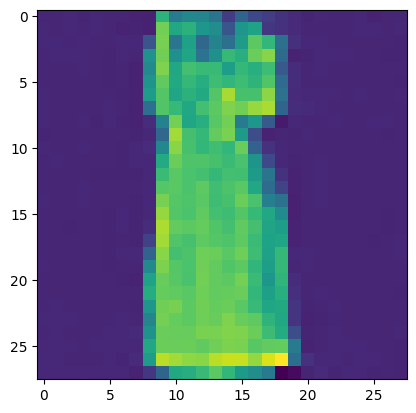

Epoch: 9   Loss: tensor(0.8016, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4007, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0001, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(2.4694, device='cuda:0', grad_fn=<AddBackward0>)


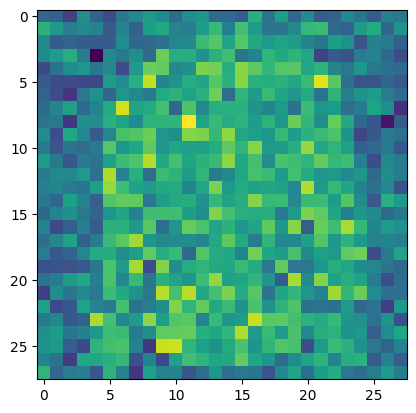

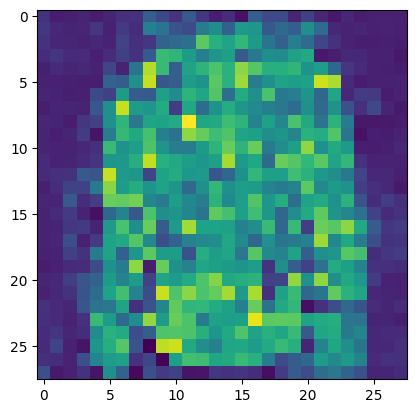

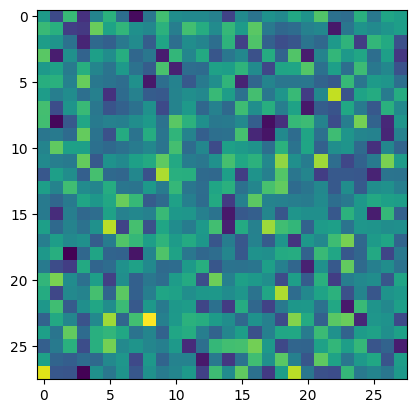

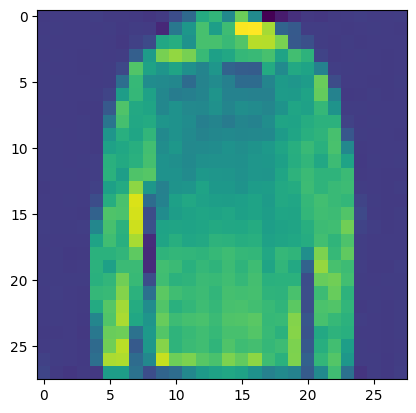

Epoch: 9   Loss: tensor(0.7868, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3932, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(0.2507, device='cuda:0', grad_fn=<AddBackward0>)


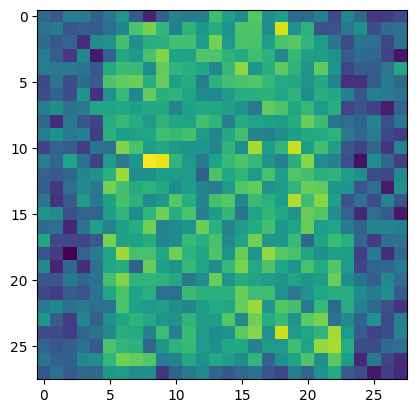

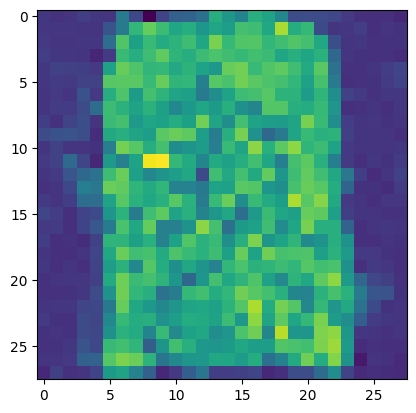

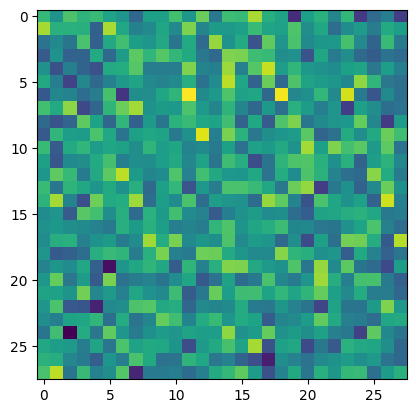

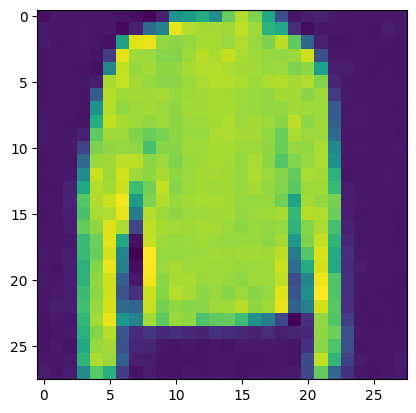

Epoch: 9   Loss: tensor(0.8281, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4128, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0025, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(0.0457, device='cuda:0', grad_fn=<AddBackward0>)


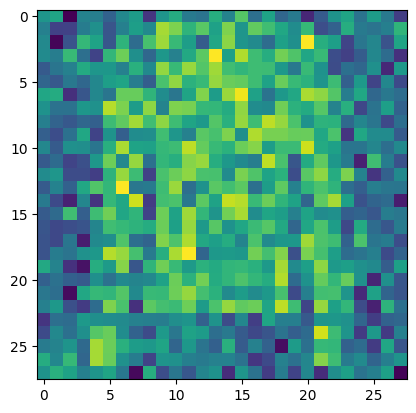

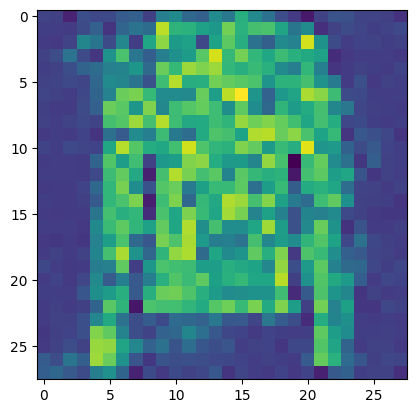

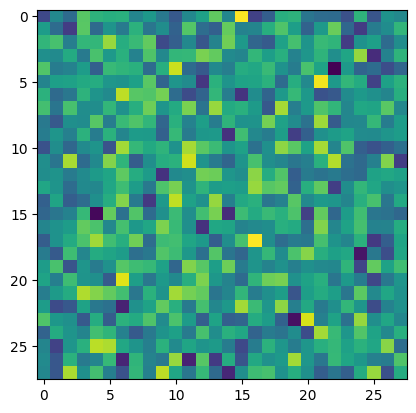

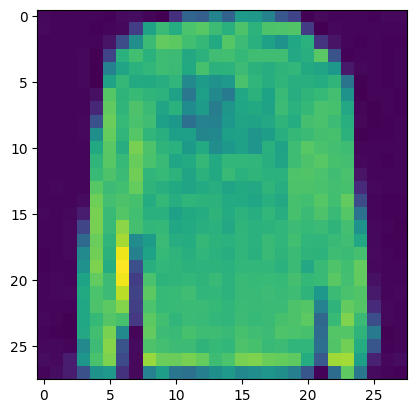

Epoch: 9   Loss: tensor(0.8978, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4280, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0418, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 9  Adversarial Loss:tensor(0.0382, device='cuda:0', grad_fn=<AddBackward0>)


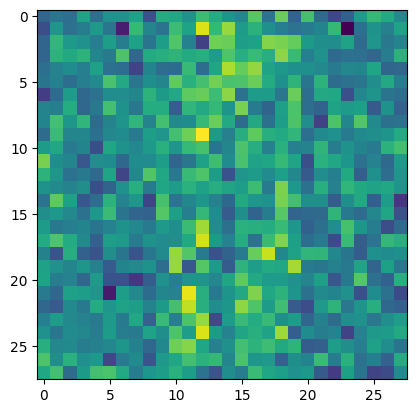

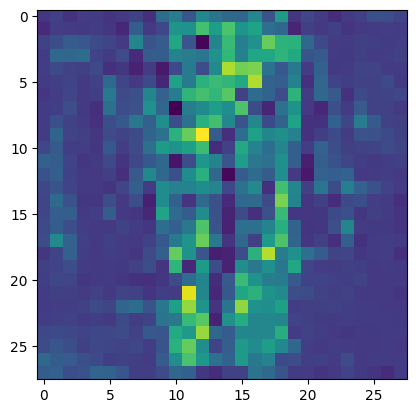

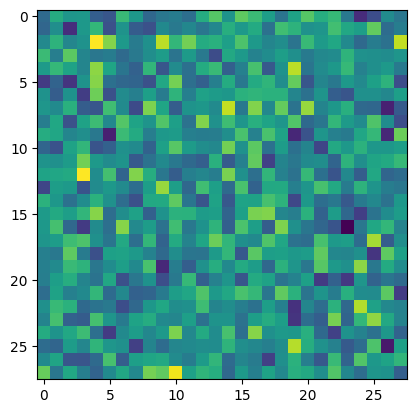

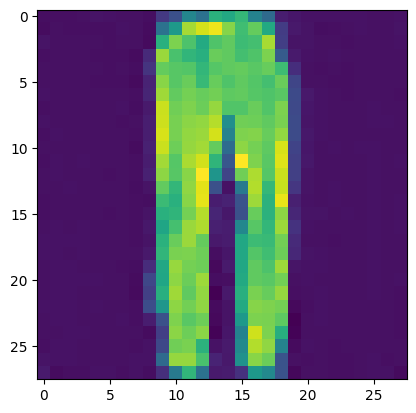

Epoch: 9   Loss: tensor(1.3367, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4022, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.5324, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(0.2577, device='cuda:0', grad_fn=<AddBackward0>)


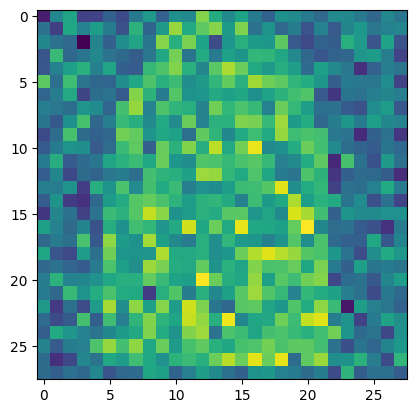

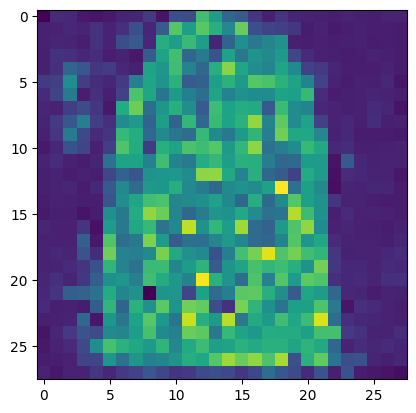

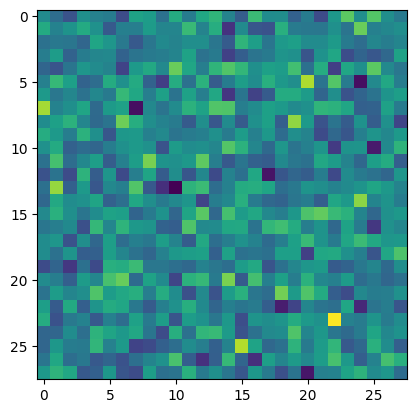

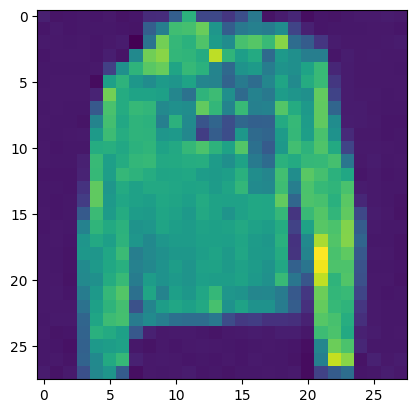

Epoch: 10   Loss: tensor(1.3903, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4129, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.5644, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(0.5573, device='cuda:0', grad_fn=<AddBackward0>)


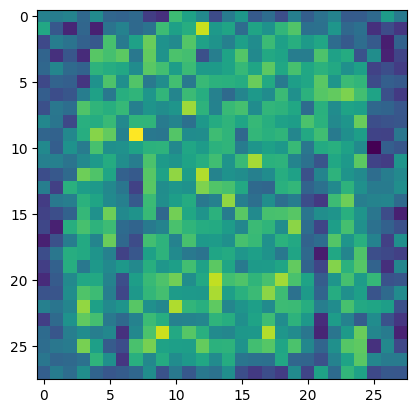

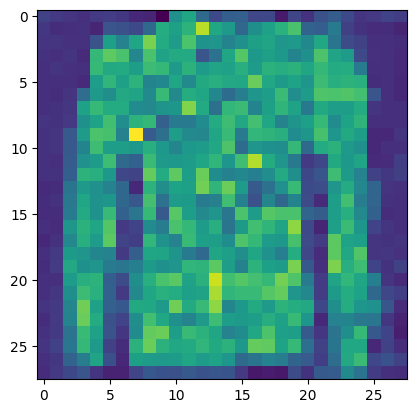

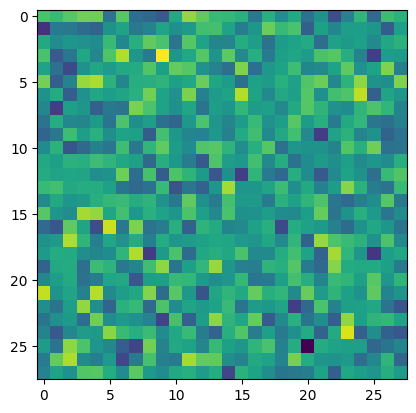

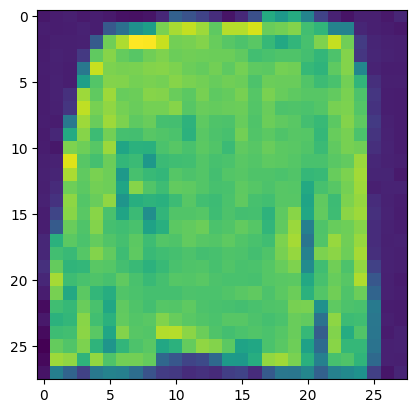

Epoch: 10   Loss: tensor(1.1298, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3947, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.3404, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(3.1600, device='cuda:0', grad_fn=<AddBackward0>)


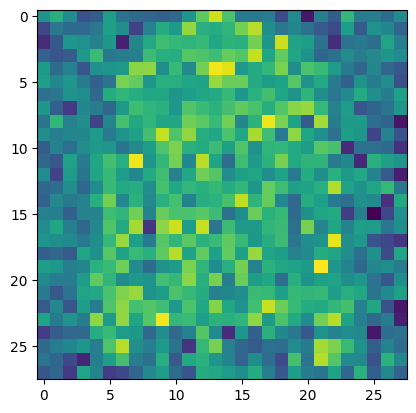

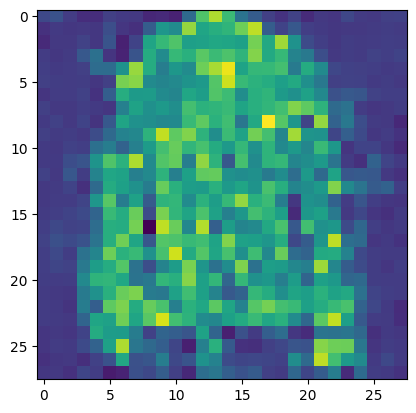

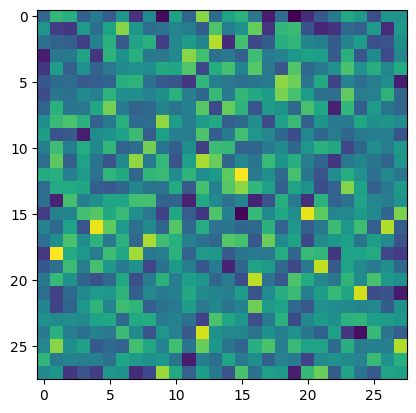

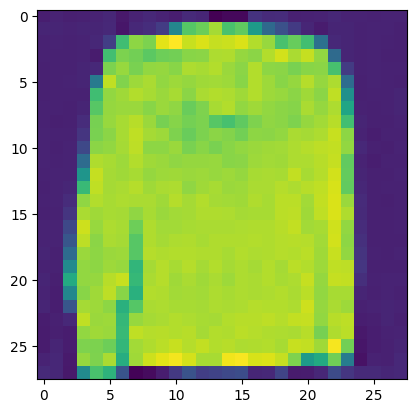

Epoch: 10   Loss: tensor(1.2972, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4017, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.4938, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(0.0268, device='cuda:0', grad_fn=<AddBackward0>)


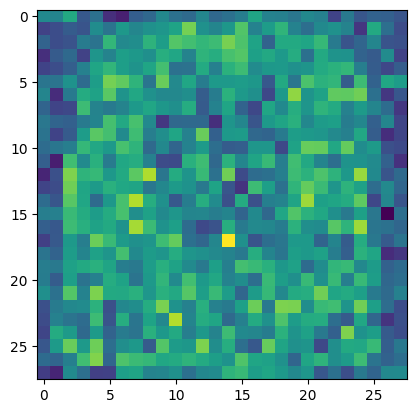

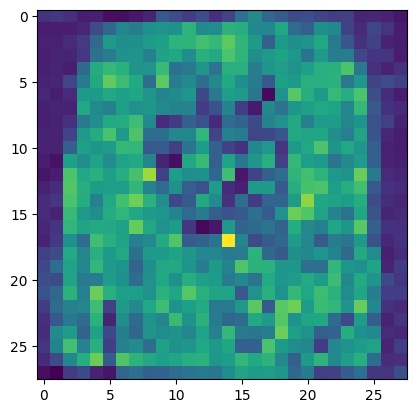

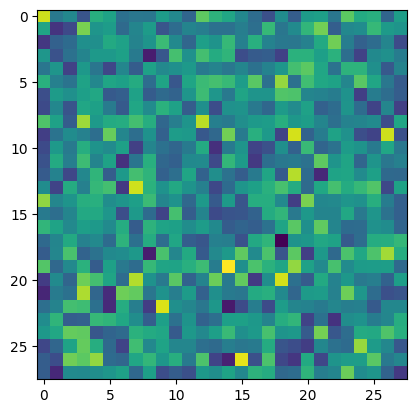

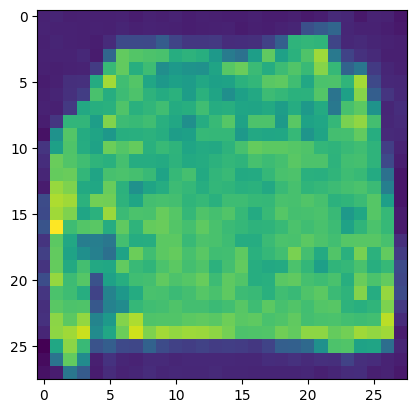

Epoch: 10   Loss: tensor(0.8087, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4030, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(0.1121, device='cuda:0', grad_fn=<AddBackward0>)


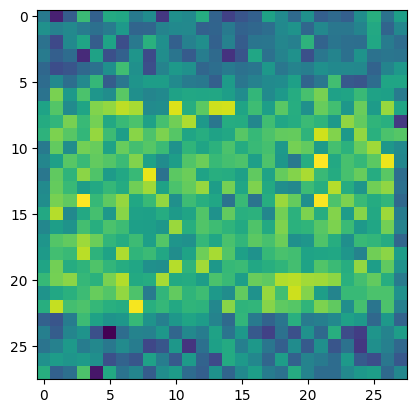

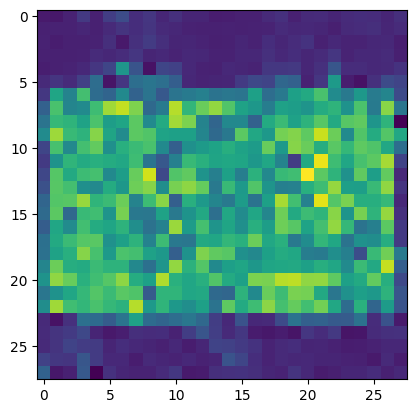

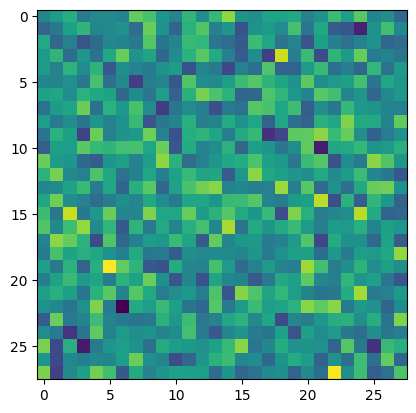

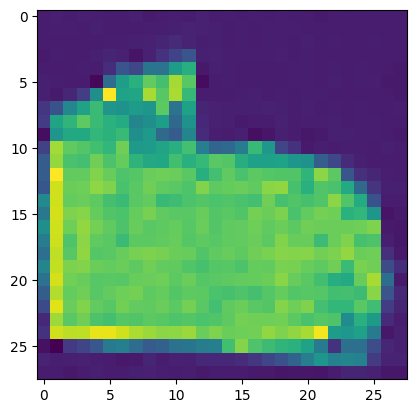

Epoch: 10   Loss: tensor(0.7781, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3865, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0052, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(0.4344, device='cuda:0', grad_fn=<AddBackward0>)


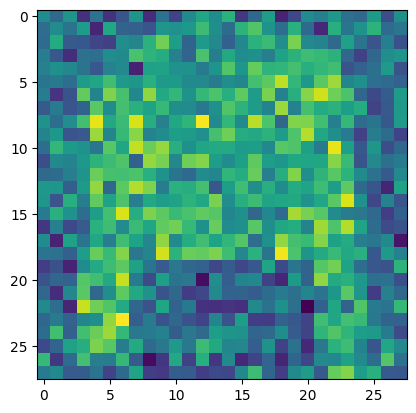

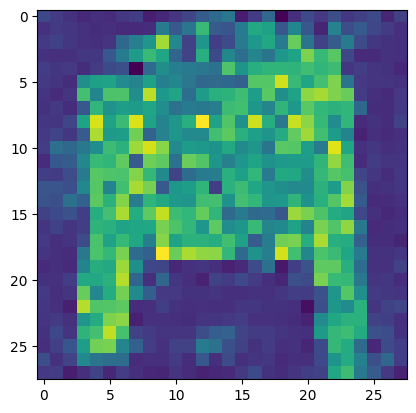

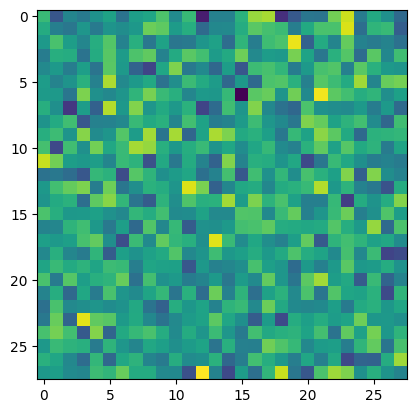

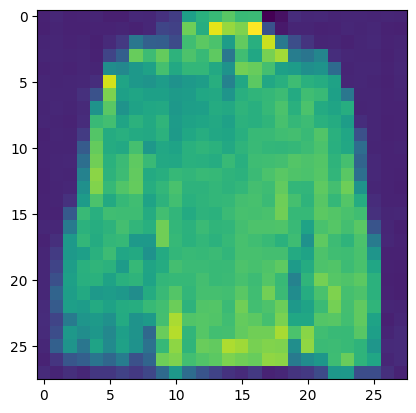

Epoch: 10   Loss: tensor(0.7703, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3850, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0004, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(0.4254, device='cuda:0', grad_fn=<AddBackward0>)


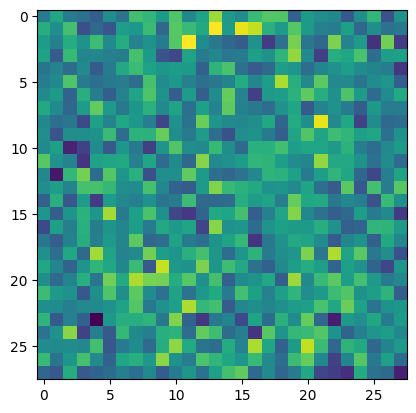

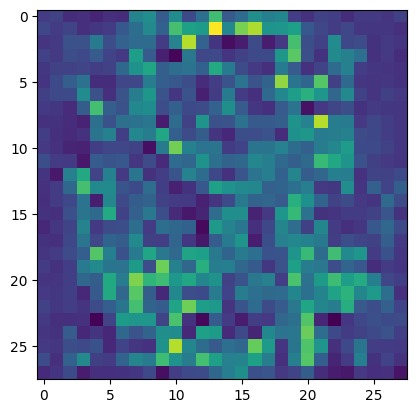

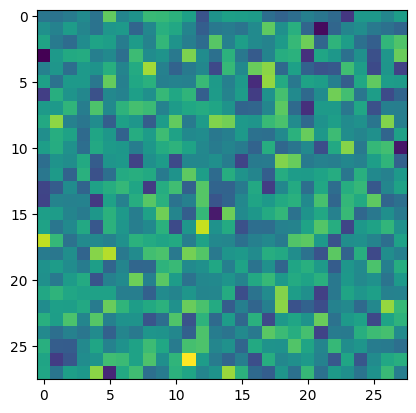

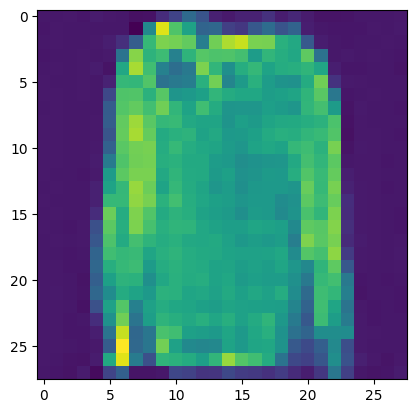

Epoch: 10   Loss: tensor(0.8017, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4003, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(0.5728, device='cuda:0', grad_fn=<AddBackward0>)


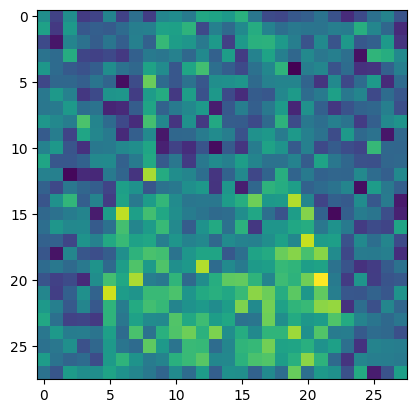

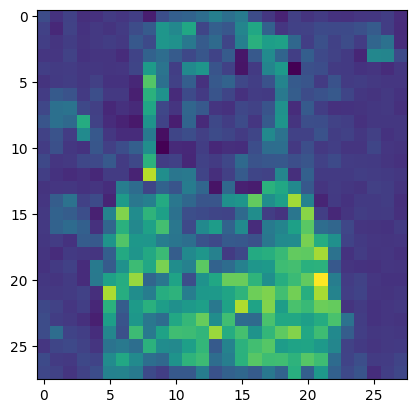

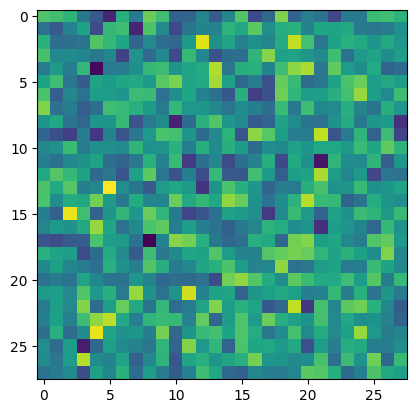

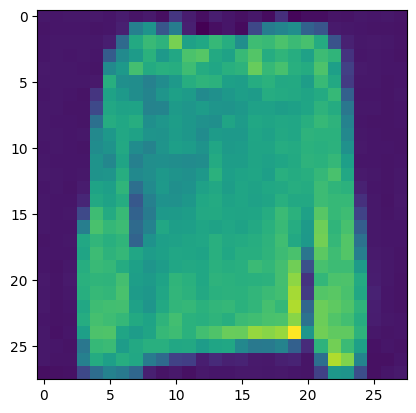

Epoch: 10   Loss: tensor(0.7958, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3966, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0026, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(0.0352, device='cuda:0', grad_fn=<AddBackward0>)


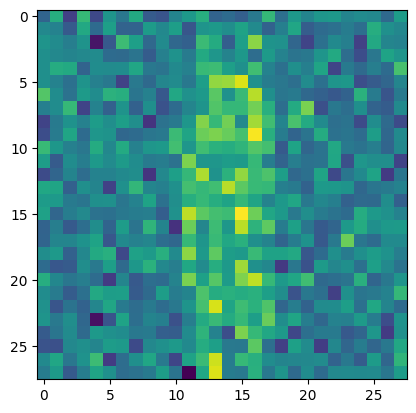

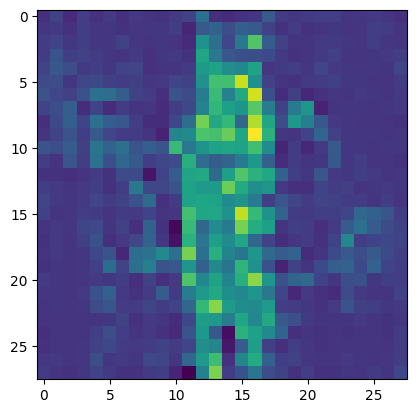

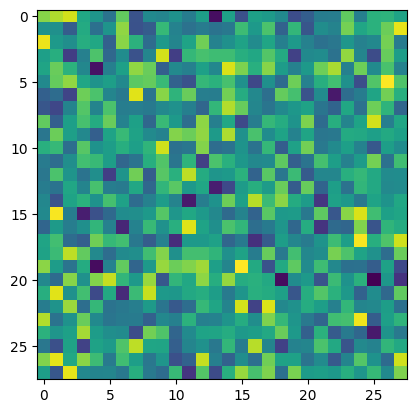

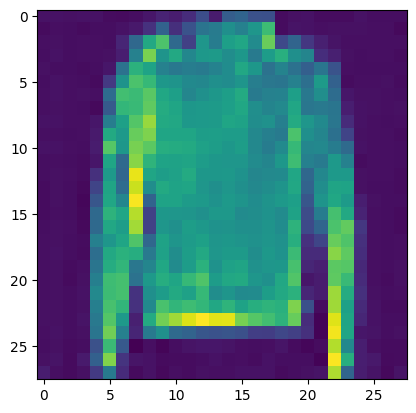

Epoch: 10   Loss: tensor(0.8276, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3966, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0344, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 10  Adversarial Loss:tensor(0.0654, device='cuda:0', grad_fn=<AddBackward0>)


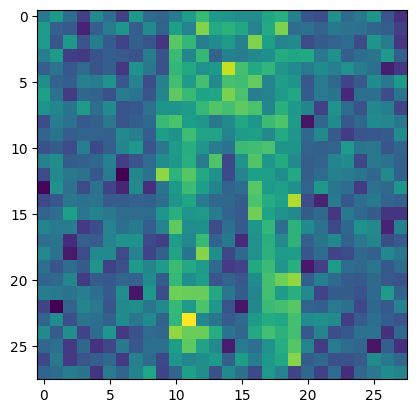

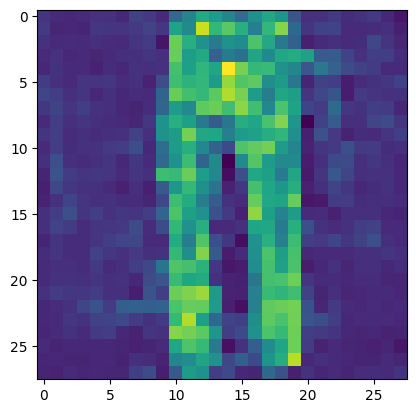

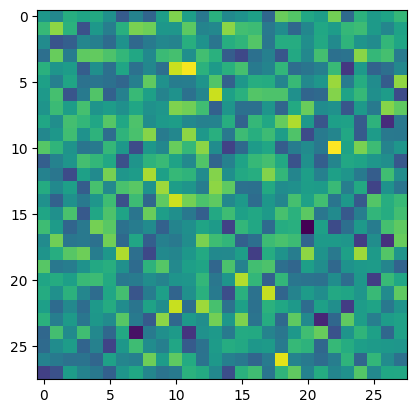

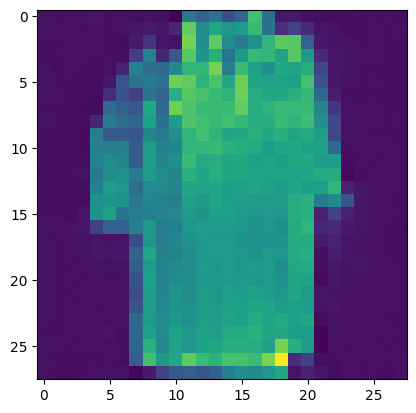

Epoch: 10   Loss: tensor(0.9344, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4327, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0691, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(0.0511, device='cuda:0', grad_fn=<AddBackward0>)


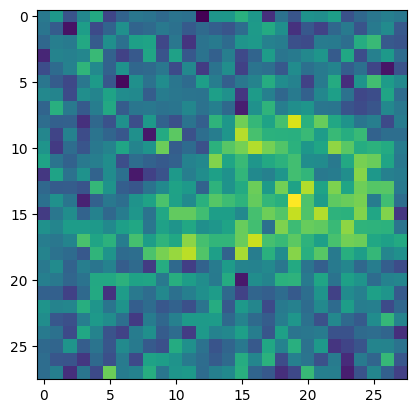

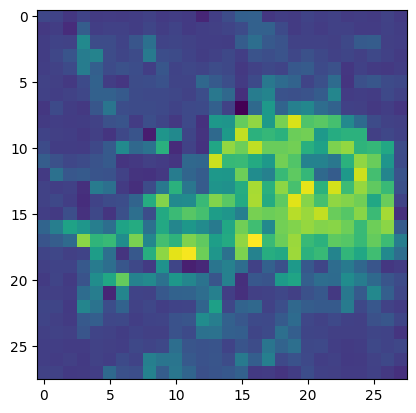

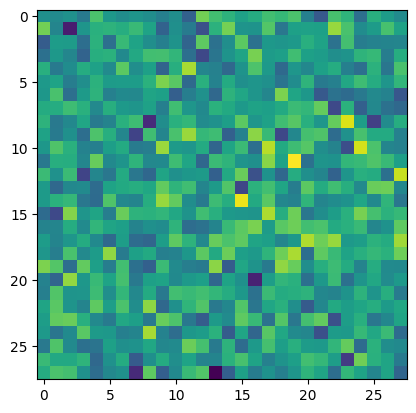

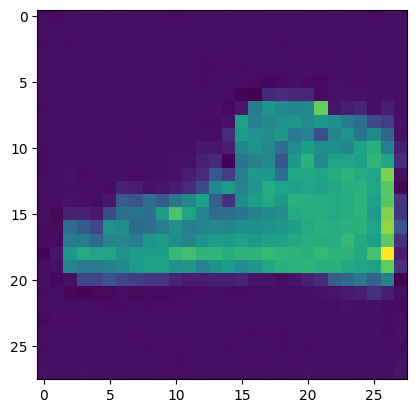

Epoch: 11   Loss: tensor(0.8909, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4031, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0847, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(0.0665, device='cuda:0', grad_fn=<AddBackward0>)


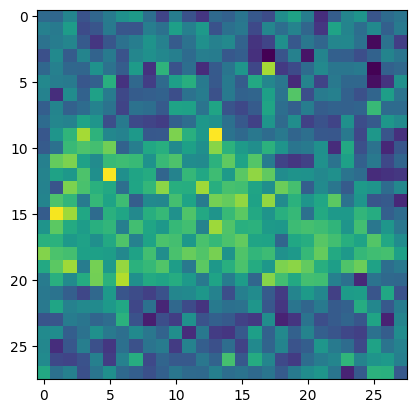

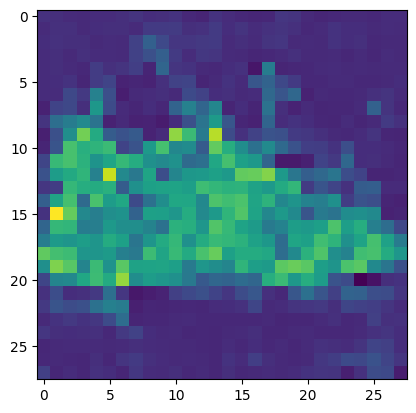

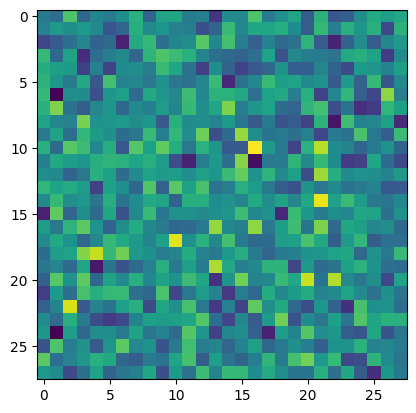

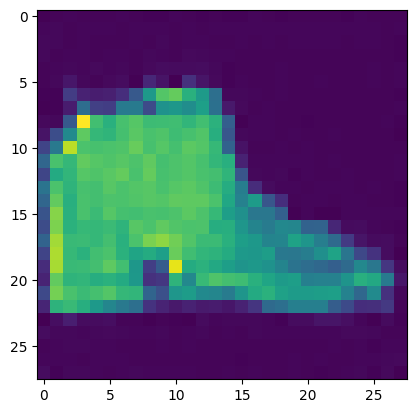

Epoch: 11   Loss: tensor(0.9344, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4102, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.1141, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(0.1941, device='cuda:0', grad_fn=<AddBackward0>)


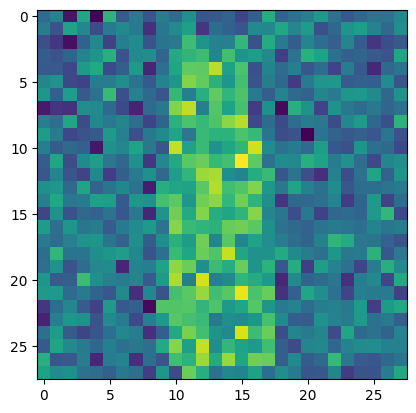

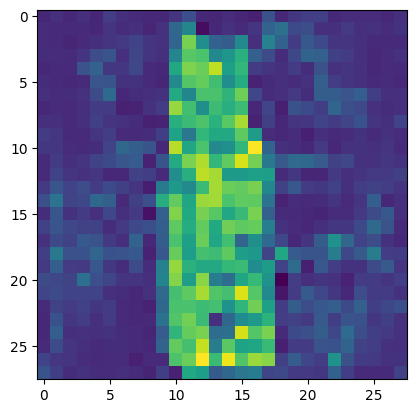

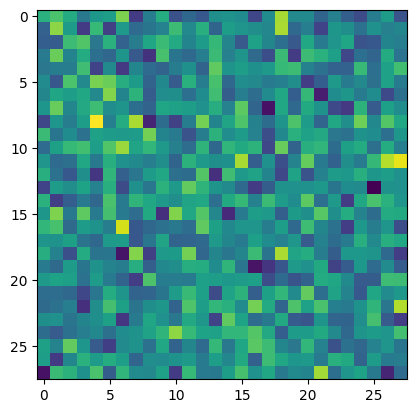

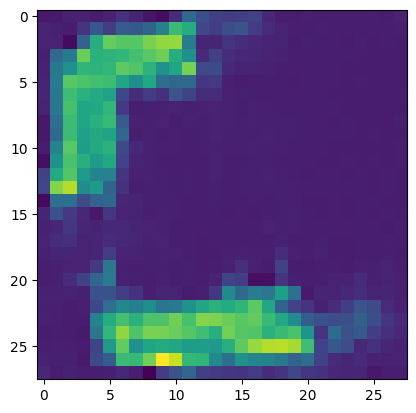

Epoch: 11   Loss: tensor(1.0777, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4047, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.2683, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(0.1039, device='cuda:0', grad_fn=<AddBackward0>)


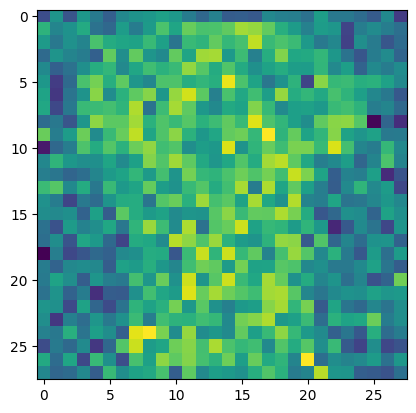

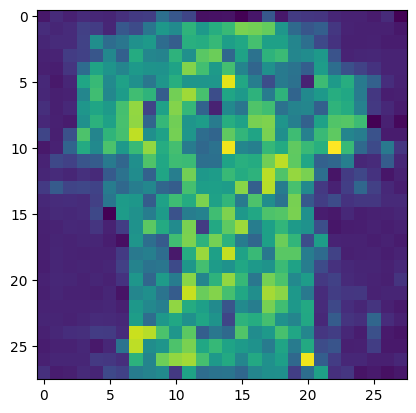

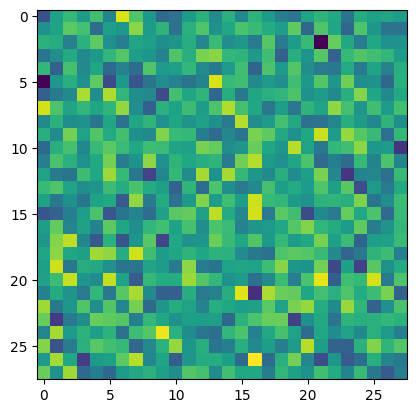

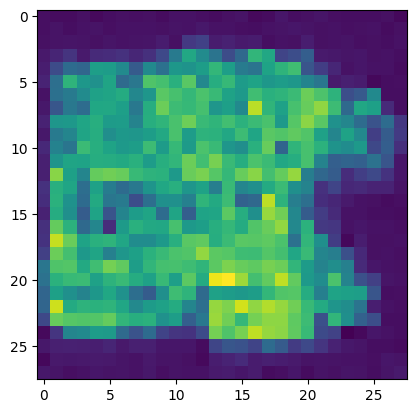

Epoch: 11   Loss: tensor(0.9179, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4177, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0825, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(0.0803, device='cuda:0', grad_fn=<AddBackward0>)


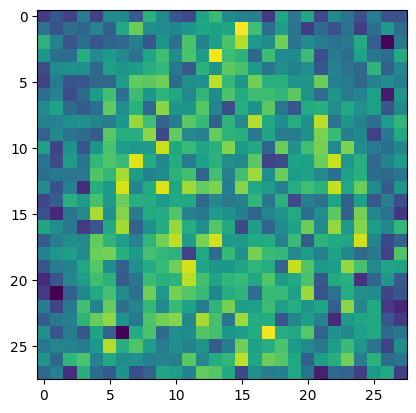

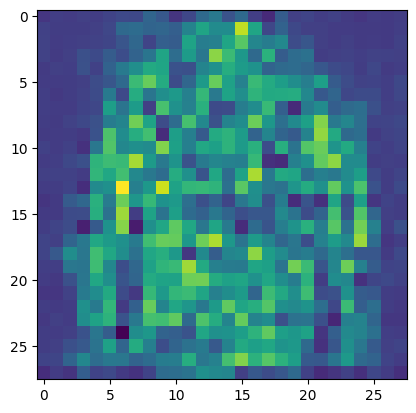

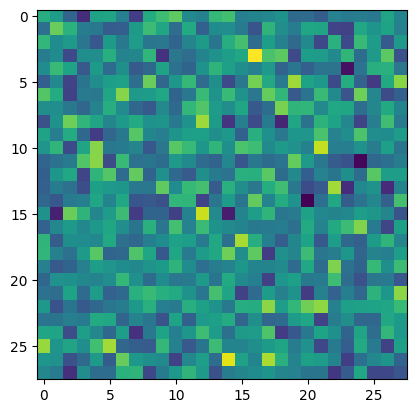

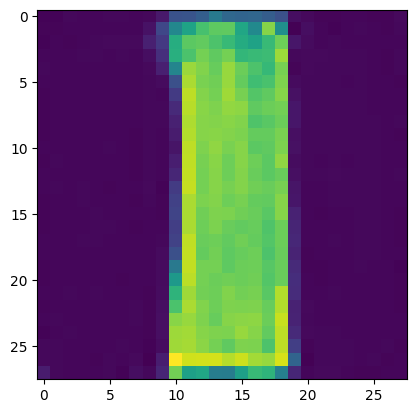

Epoch: 11   Loss: tensor(0.8926, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4276, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0373, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(0.2002, device='cuda:0', grad_fn=<AddBackward0>)


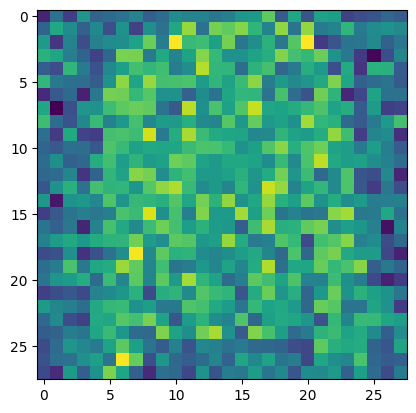

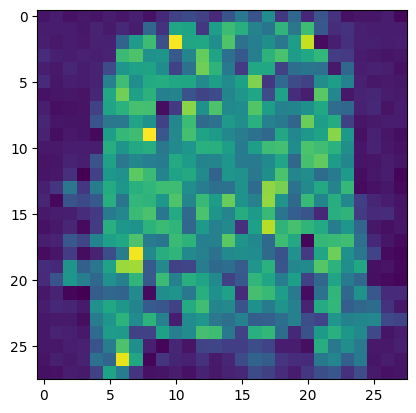

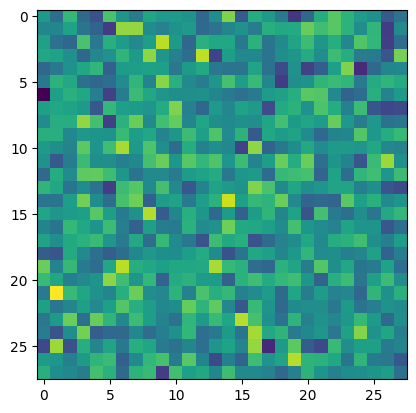

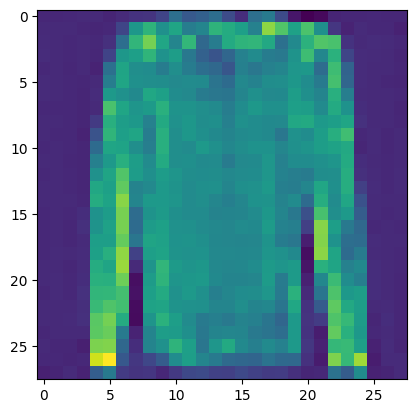

Epoch: 11   Loss: tensor(0.9093, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4169, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0755, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(0.2944, device='cuda:0', grad_fn=<AddBackward0>)


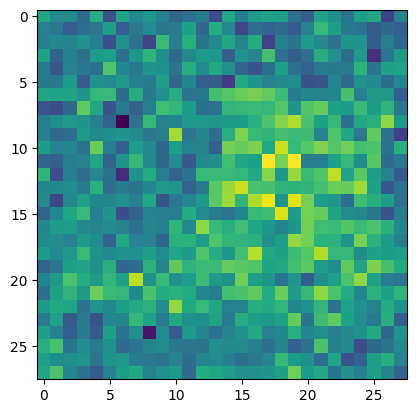

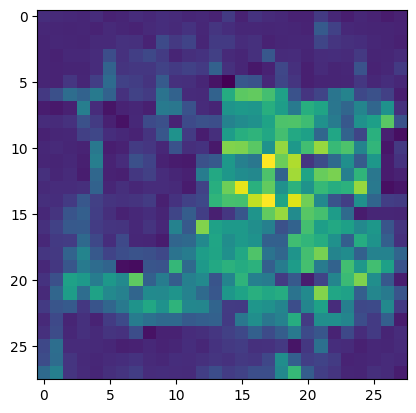

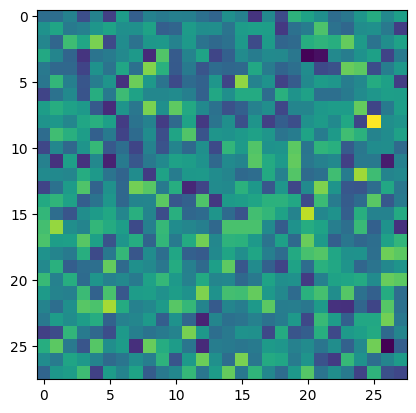

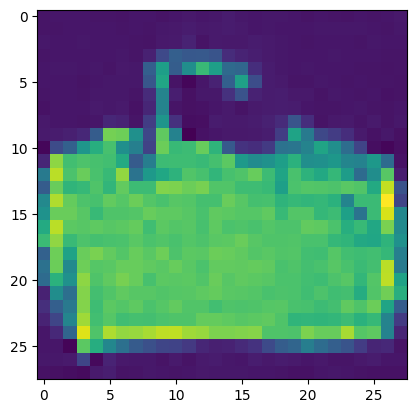

Epoch: 11   Loss: tensor(0.8415, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4025, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0365, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(0.0618, device='cuda:0', grad_fn=<AddBackward0>)


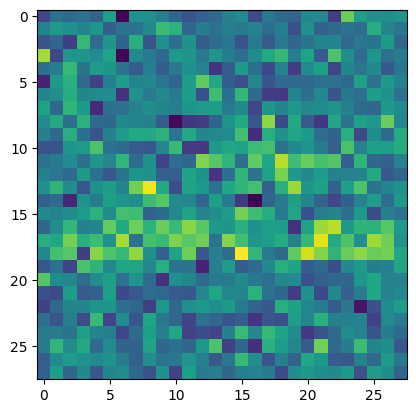

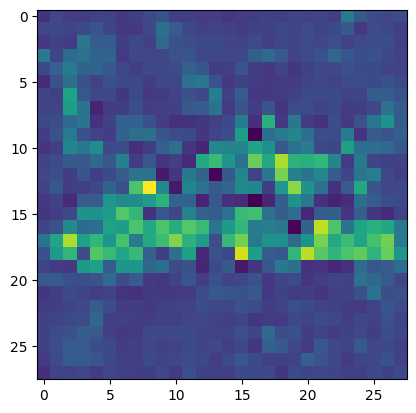

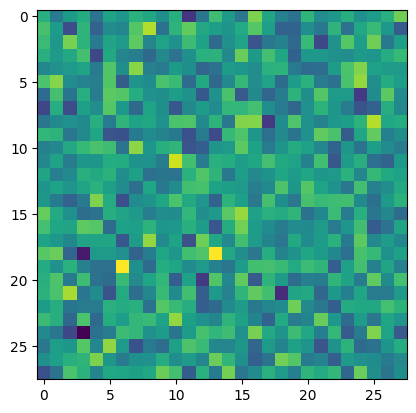

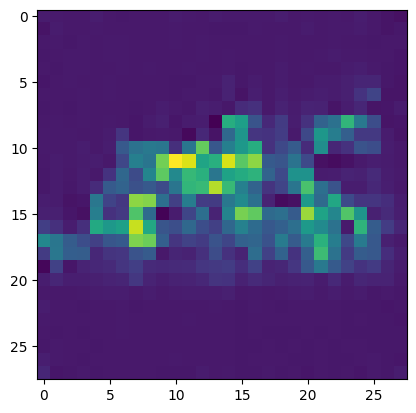

Epoch: 11   Loss: tensor(0.7868, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3928, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0011, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(0.0262, device='cuda:0', grad_fn=<AddBackward0>)


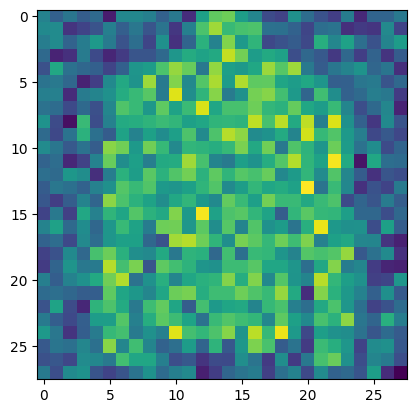

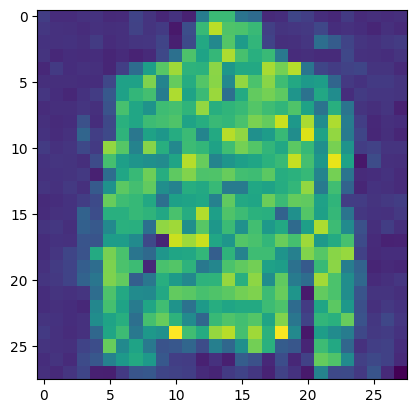

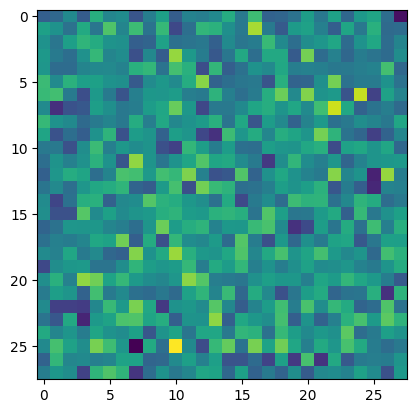

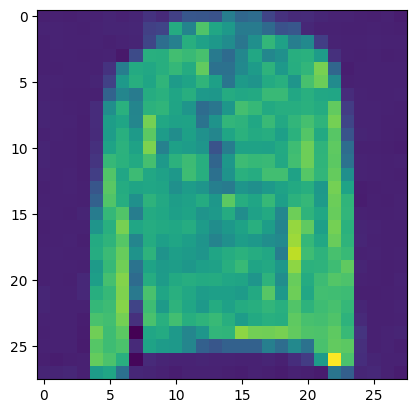

Epoch: 11   Loss: tensor(0.7800, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3877, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0047, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 11  Adversarial Loss:tensor(0.4650, device='cuda:0', grad_fn=<AddBackward0>)


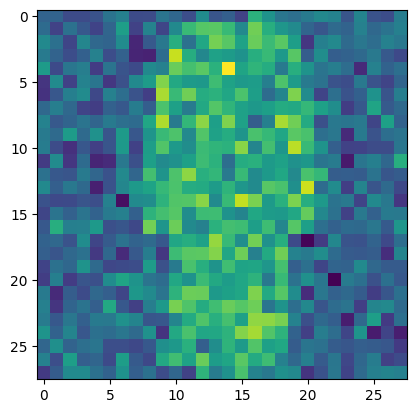

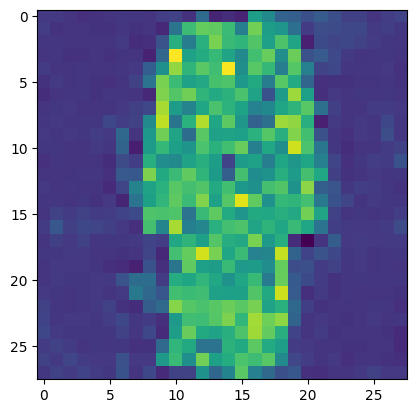

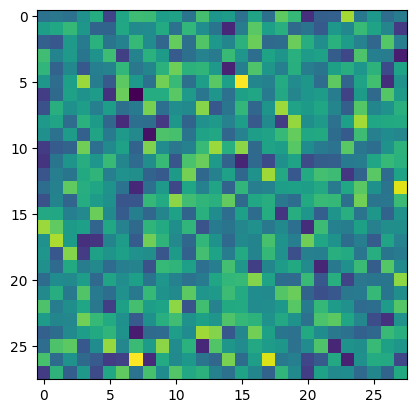

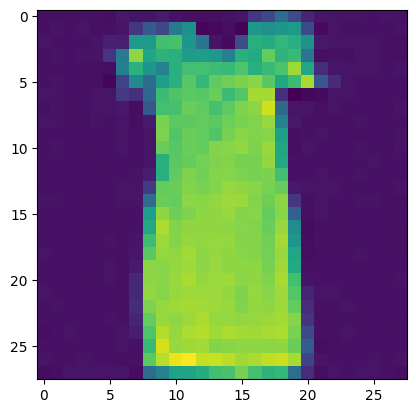

Epoch: 11   Loss: tensor(0.7921, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3957, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(0.0148, device='cuda:0', grad_fn=<AddBackward0>)


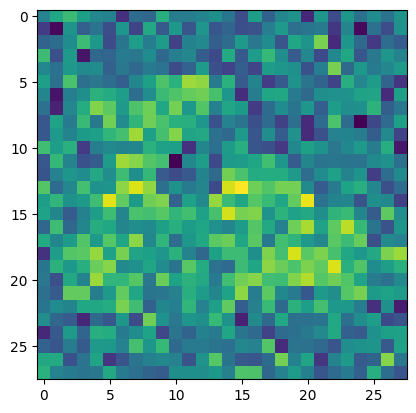

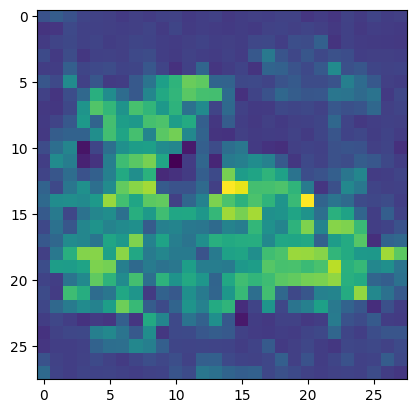

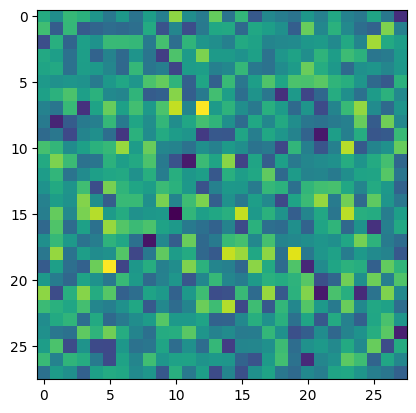

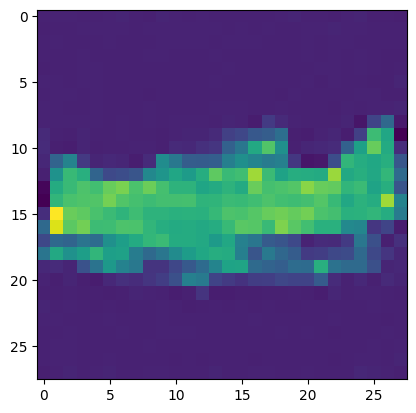

Epoch: 12   Loss: tensor(0.8390, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4184, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(0.1012, device='cuda:0', grad_fn=<AddBackward0>)


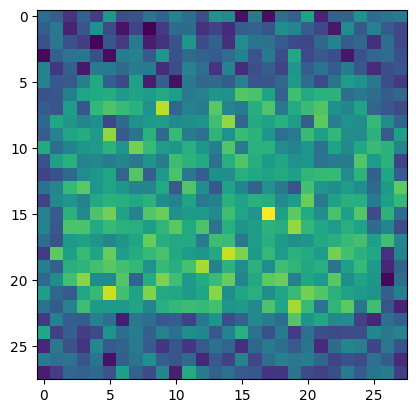

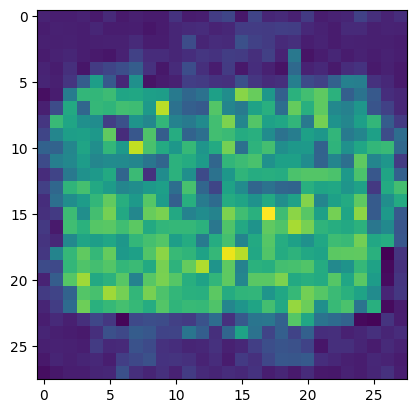

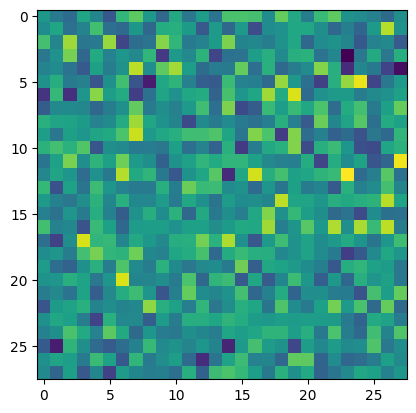

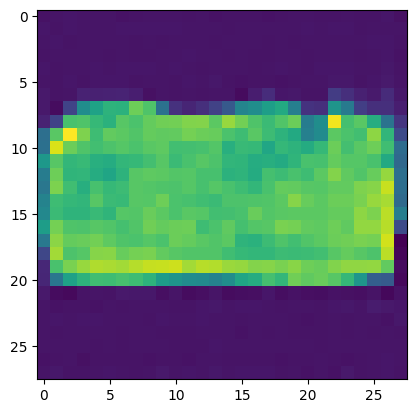

Epoch: 12   Loss: tensor(0.8322, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4150, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0022, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(0.0418, device='cuda:0', grad_fn=<AddBackward0>)


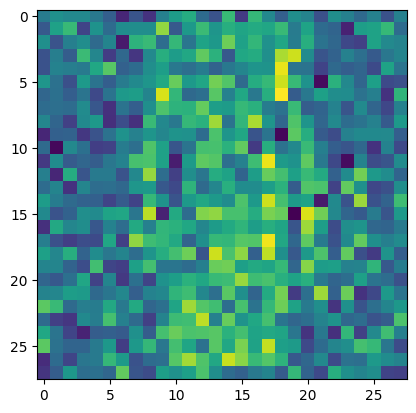

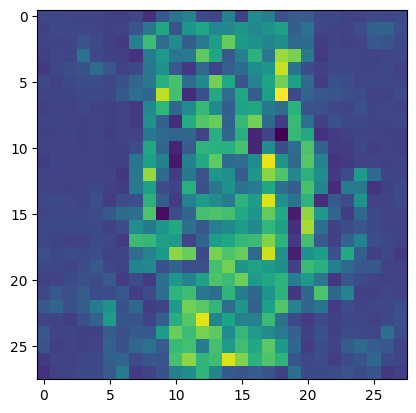

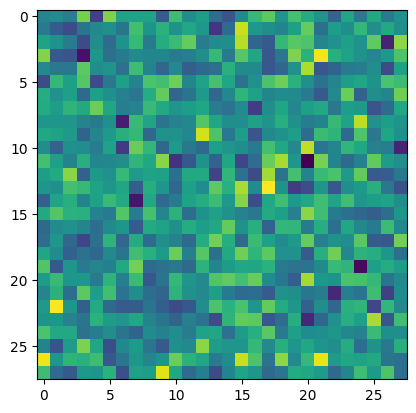

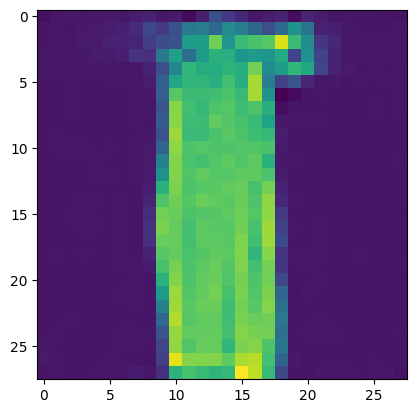

Epoch: 12   Loss: tensor(0.8154, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4045, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0064, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(0.1111, device='cuda:0', grad_fn=<AddBackward0>)


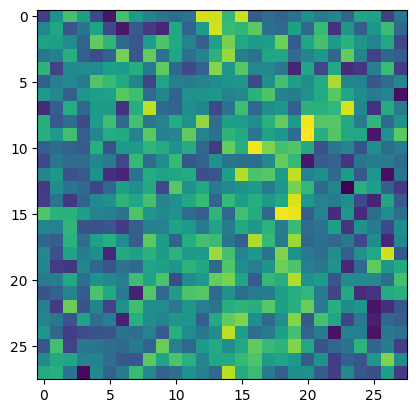

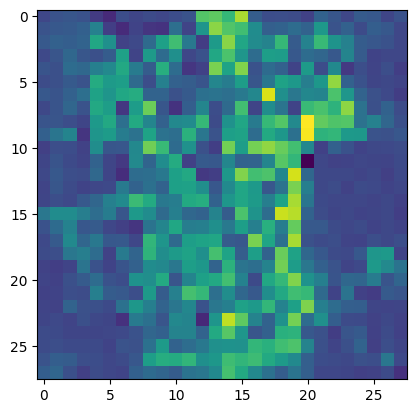

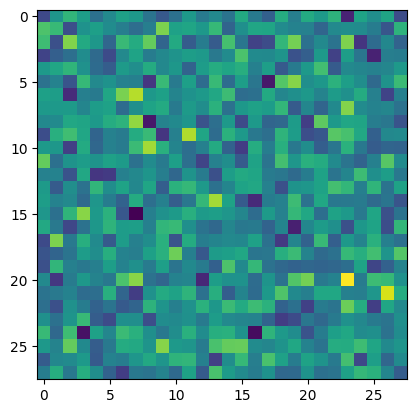

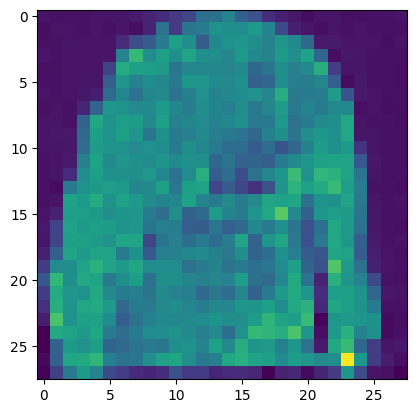

Epoch: 12   Loss: tensor(0.8093, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4041, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(0.0285, device='cuda:0', grad_fn=<AddBackward0>)


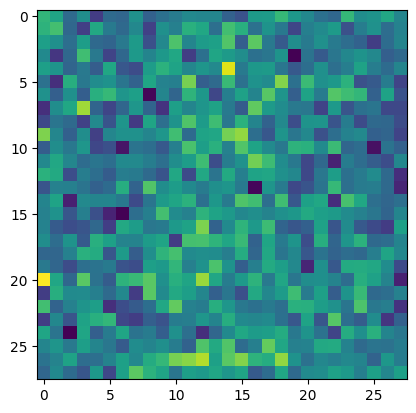

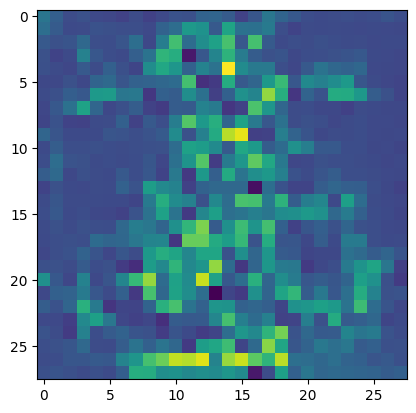

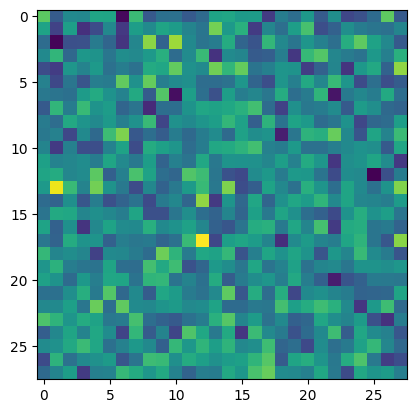

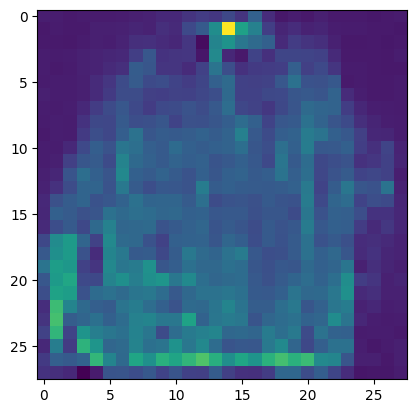

Epoch: 12   Loss: tensor(0.7955, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3849, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0256, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(0.0176, device='cuda:0', grad_fn=<AddBackward0>)


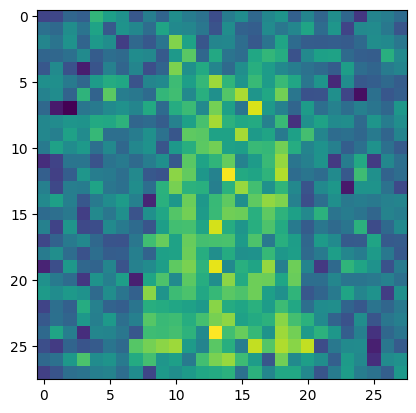

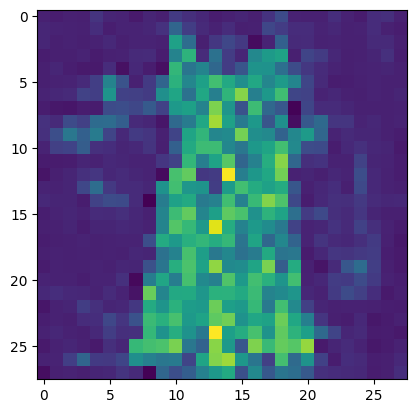

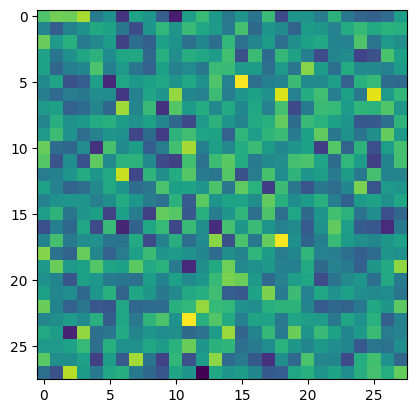

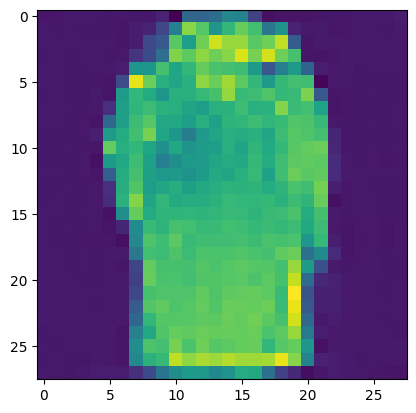

Epoch: 12   Loss: tensor(0.8725, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4256, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0214, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(0.0134, device='cuda:0', grad_fn=<AddBackward0>)


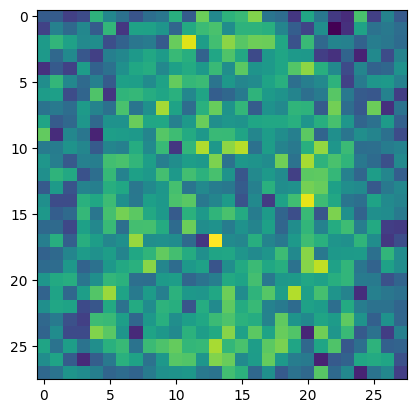

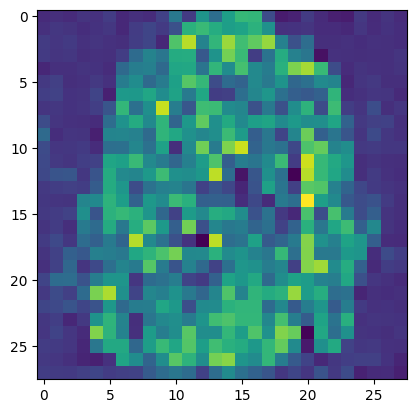

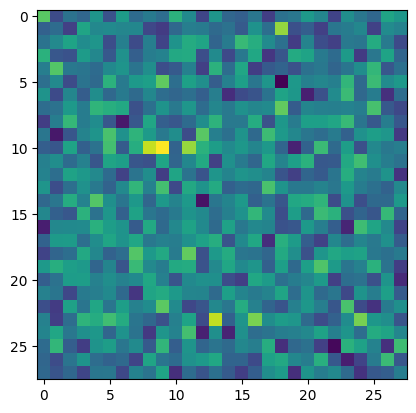

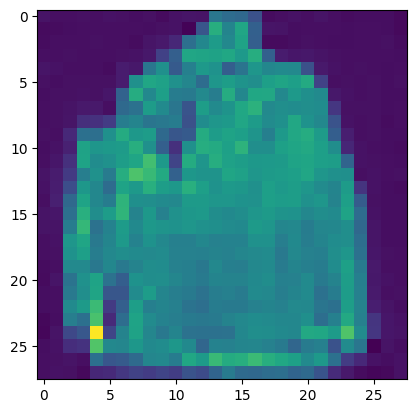

Epoch: 12   Loss: tensor(0.8171, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4037, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0097, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(0.0479, device='cuda:0', grad_fn=<AddBackward0>)


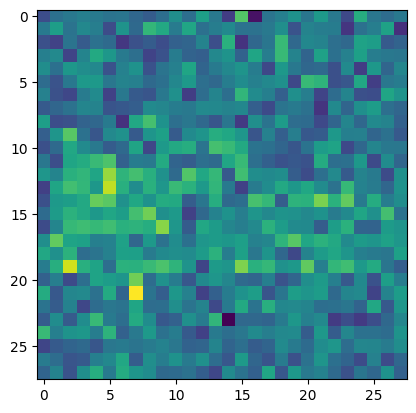

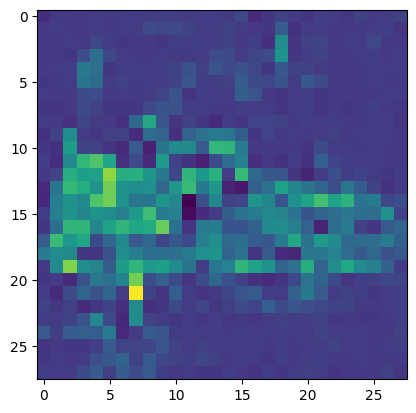

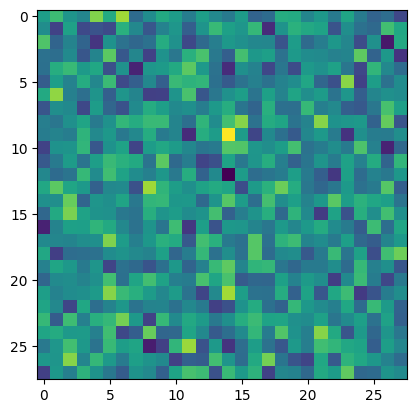

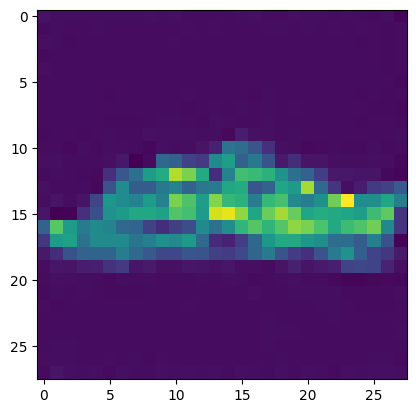

Epoch: 12   Loss: tensor(0.8224, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4094, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0036, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(0.0174, device='cuda:0', grad_fn=<AddBackward0>)


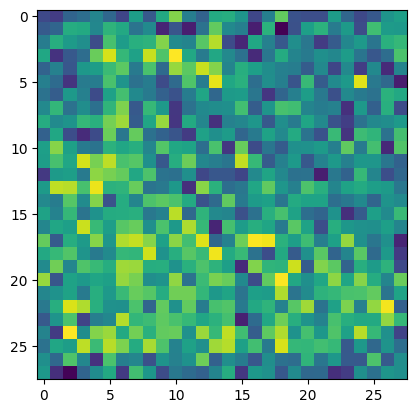

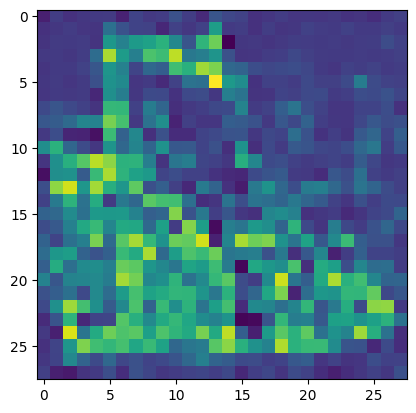

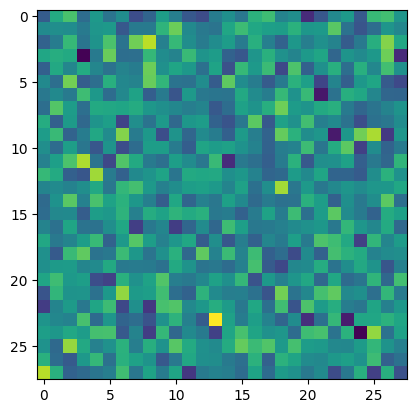

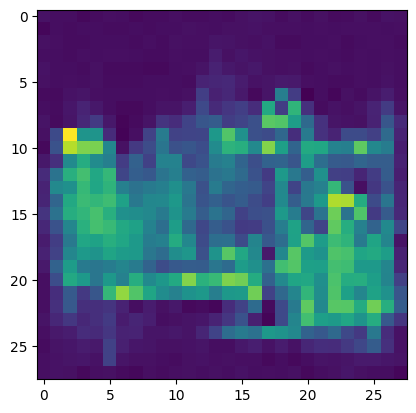

Epoch: 12   Loss: tensor(0.7858, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3897, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0063, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 12  Adversarial Loss:tensor(0.1387, device='cuda:0', grad_fn=<AddBackward0>)


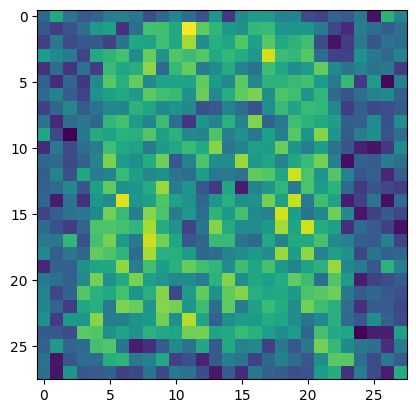

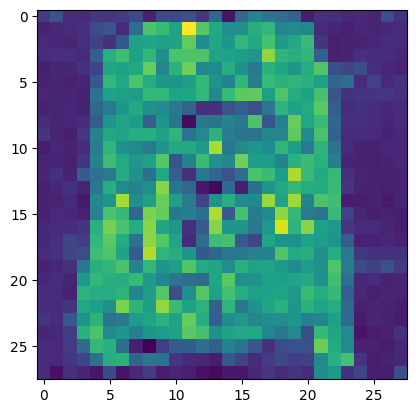

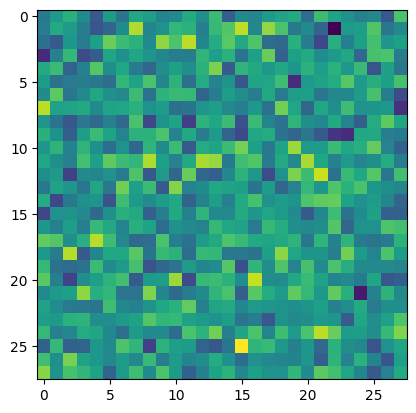

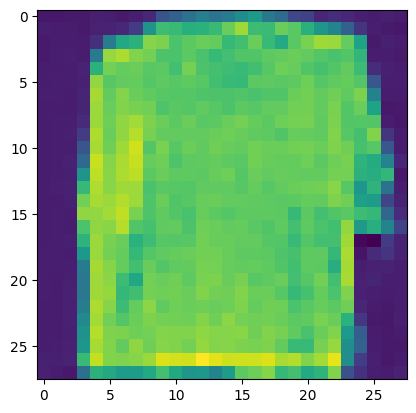

Epoch: 12   Loss: tensor(0.8919, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4116, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0687, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(0.2049, device='cuda:0', grad_fn=<AddBackward0>)


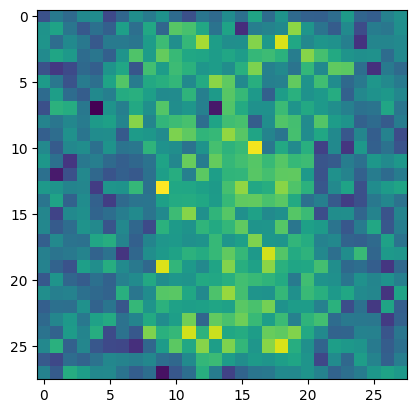

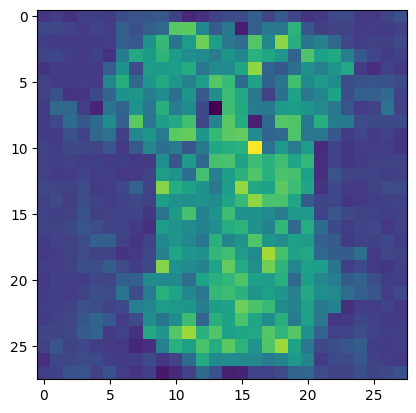

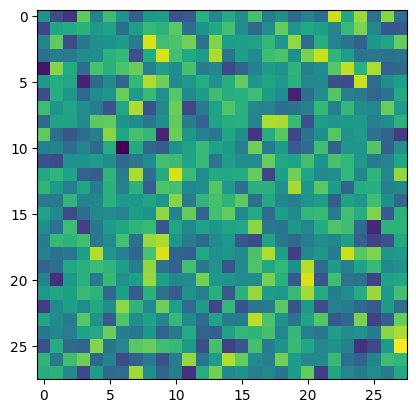

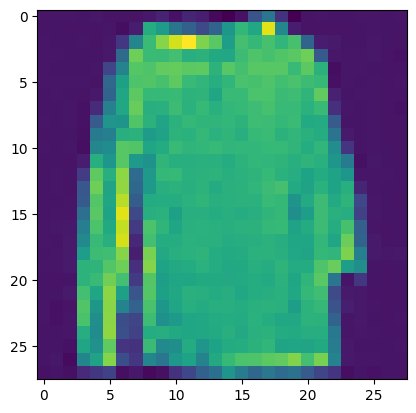

Epoch: 13   Loss: tensor(0.8843, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4021, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0802, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(0.0083, device='cuda:0', grad_fn=<AddBackward0>)


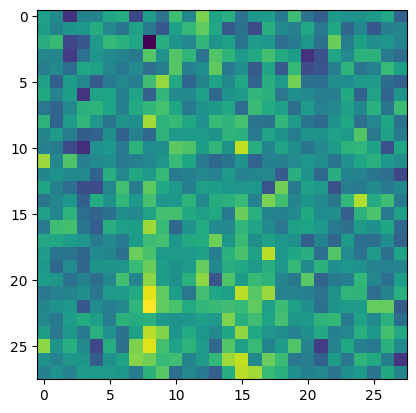

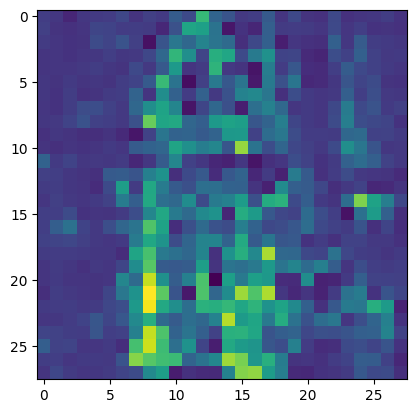

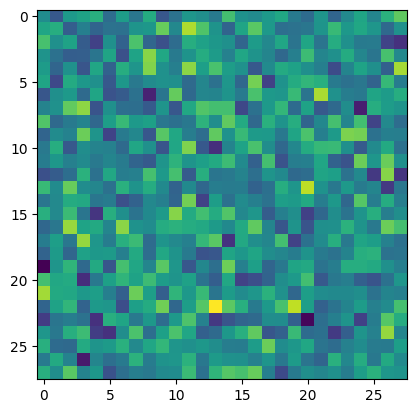

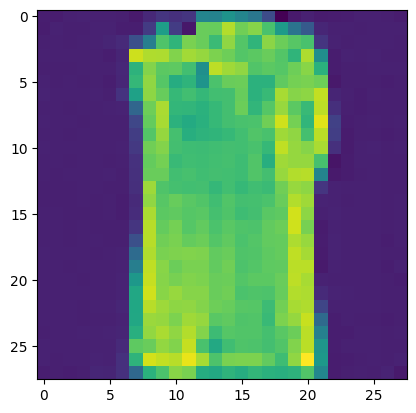

Epoch: 13   Loss: tensor(0.8274, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4130, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0013, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(0.0750, device='cuda:0', grad_fn=<AddBackward0>)


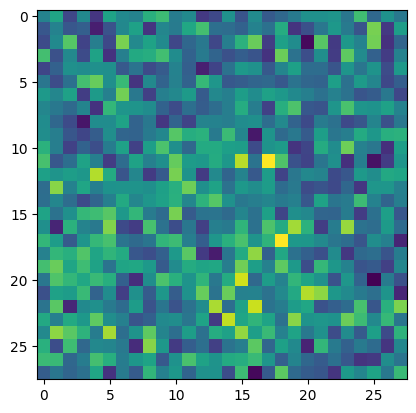

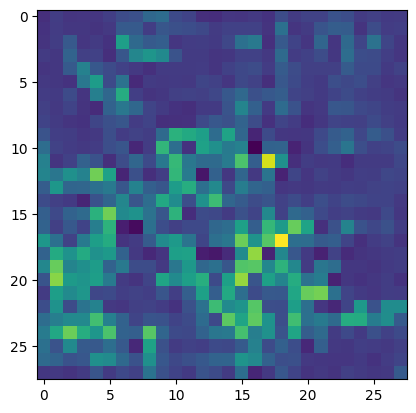

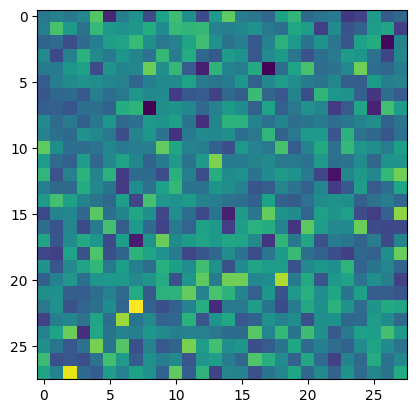

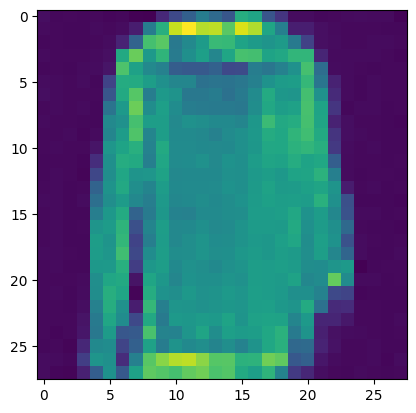

Epoch: 13   Loss: tensor(0.8130, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3968, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0193, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(0.0090, device='cuda:0', grad_fn=<AddBackward0>)


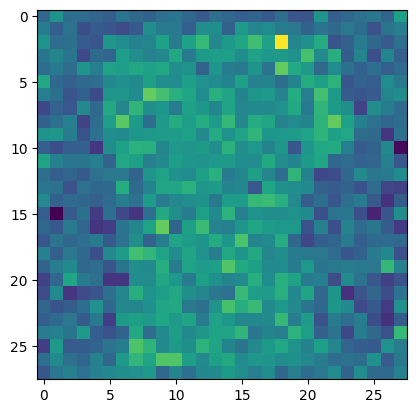

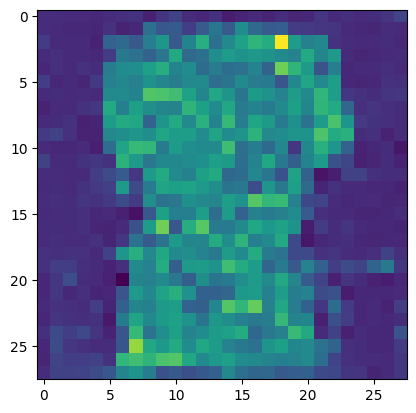

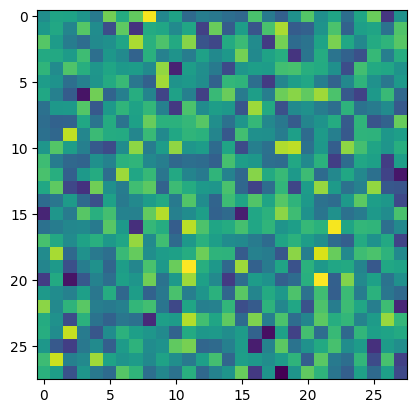

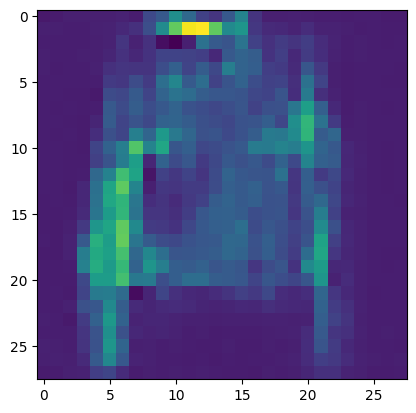

Epoch: 13   Loss: tensor(0.8003, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3992, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0018, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(0.0567, device='cuda:0', grad_fn=<AddBackward0>)


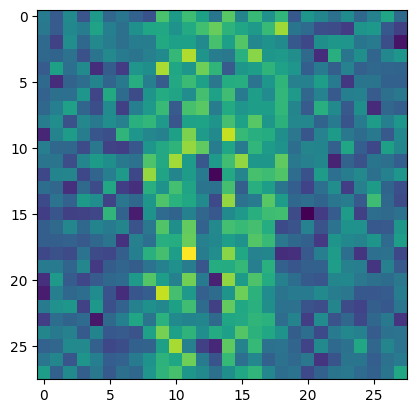

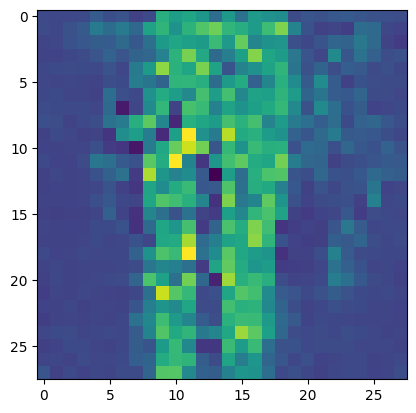

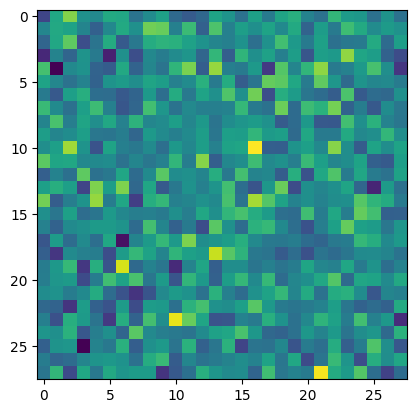

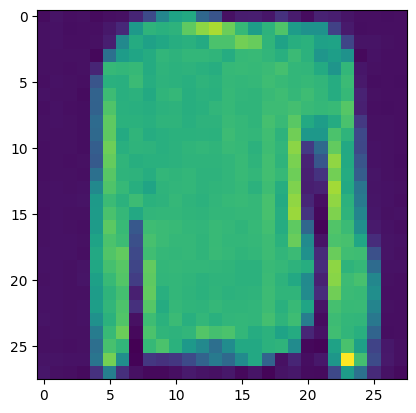

Epoch: 13   Loss: tensor(0.8139, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4068, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(0.1087, device='cuda:0', grad_fn=<AddBackward0>)


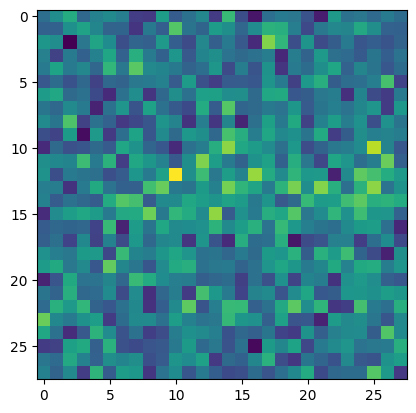

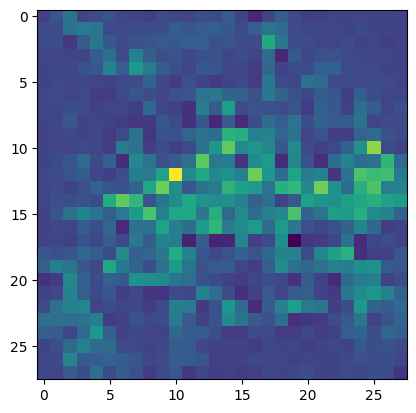

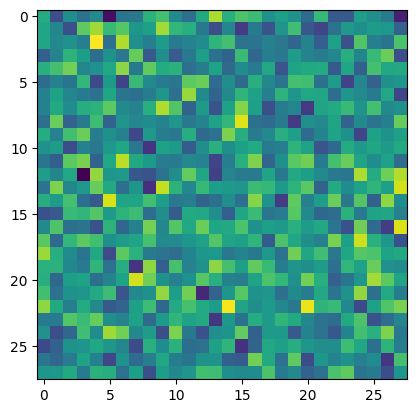

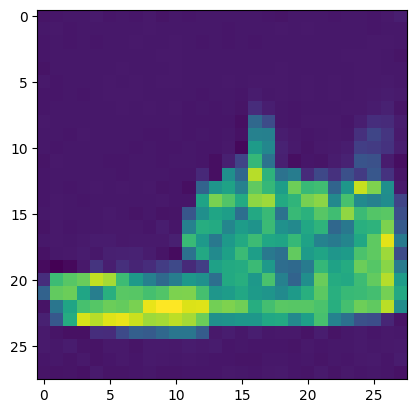

Epoch: 13   Loss: tensor(0.8359, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4179, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(0.0246, device='cuda:0', grad_fn=<AddBackward0>)


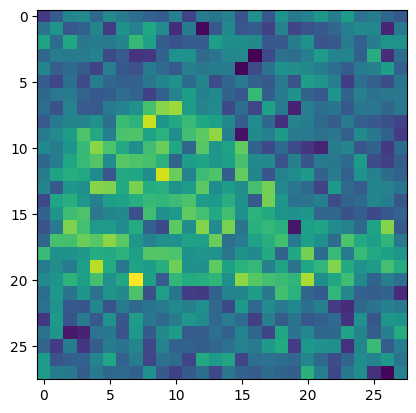

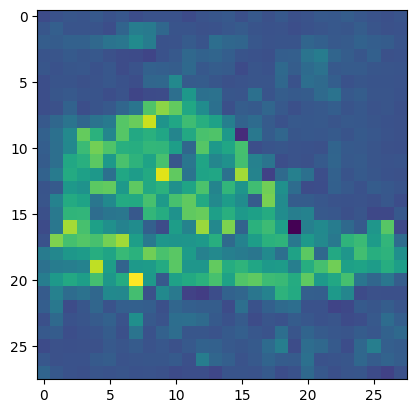

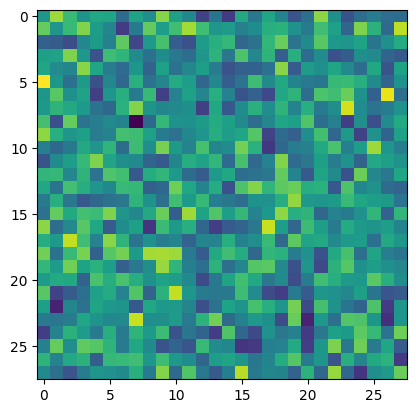

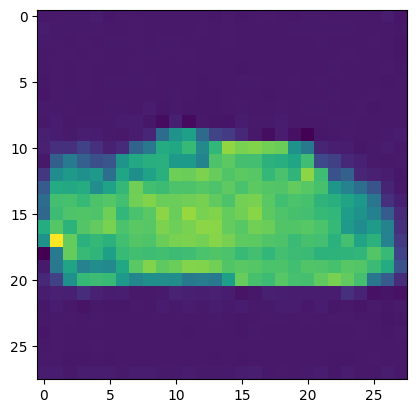

Epoch: 13   Loss: tensor(0.7733, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3861, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0010, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(0.0880, device='cuda:0', grad_fn=<AddBackward0>)


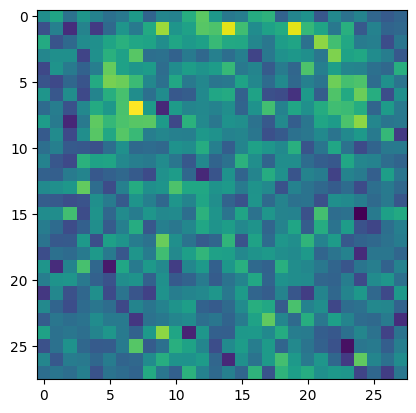

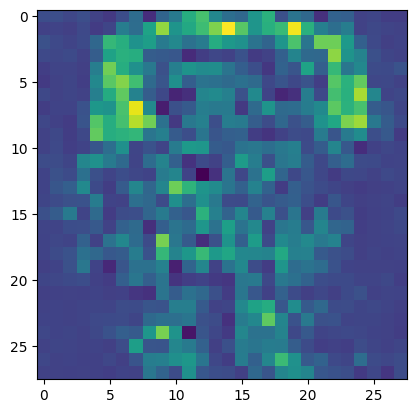

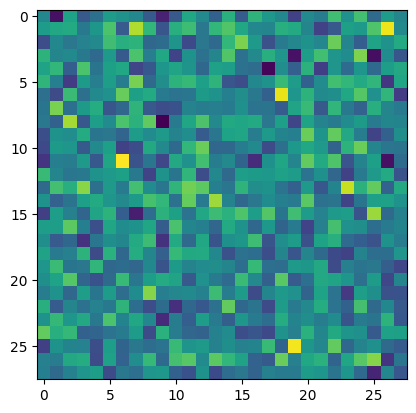

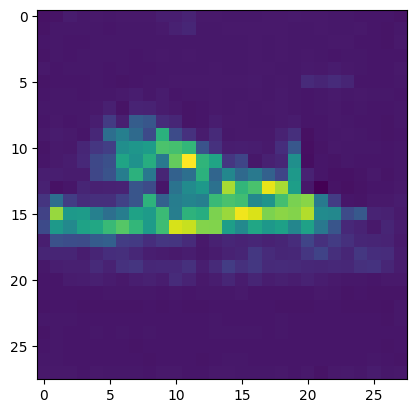

Epoch: 13   Loss: tensor(0.7921, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3960, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0002, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(0.0080, device='cuda:0', grad_fn=<AddBackward0>)


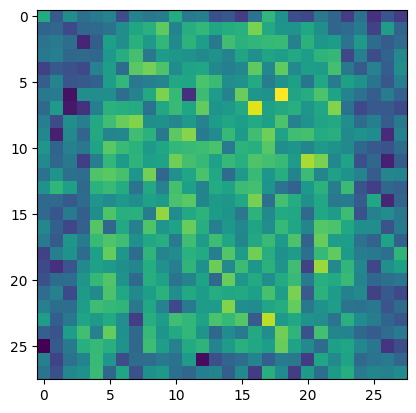

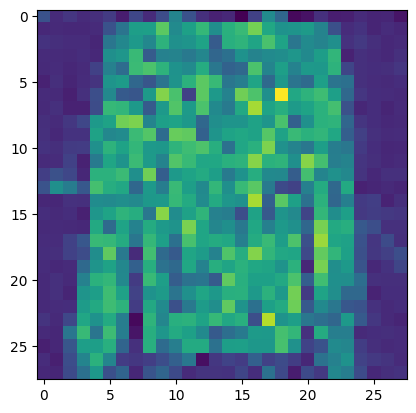

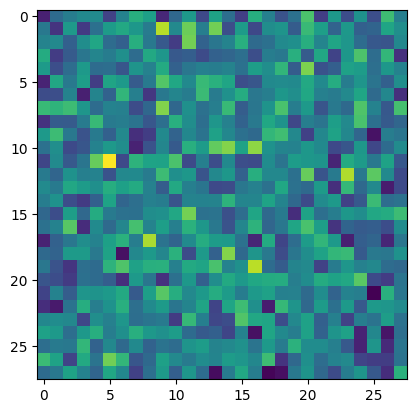

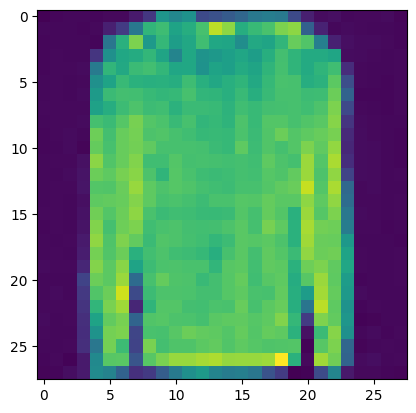

Epoch: 13   Loss: tensor(0.7996, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3990, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0016, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 13  Adversarial Loss:tensor(0.0077, device='cuda:0', grad_fn=<AddBackward0>)


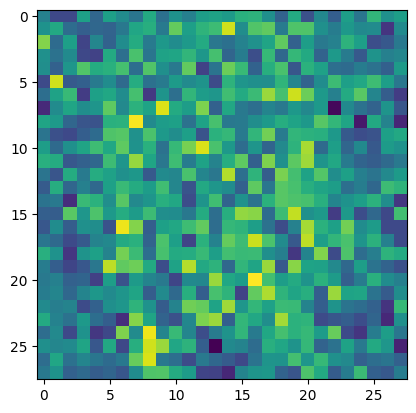

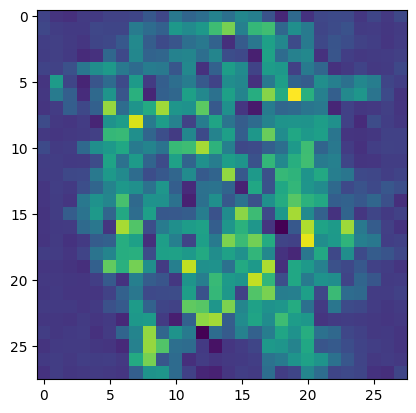

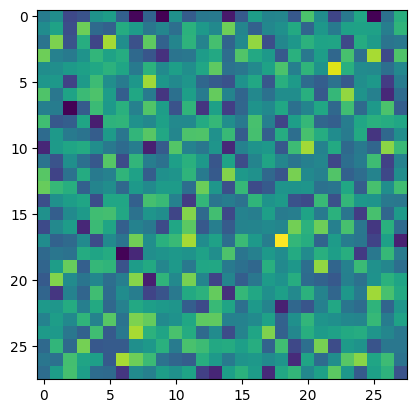

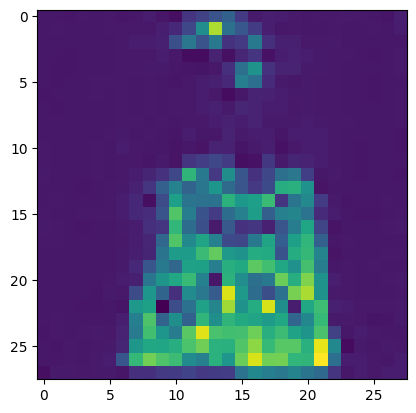

Epoch: 13   Loss: tensor(0.8353, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4173, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0006, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 14  Adversarial Loss:tensor(0.0423, device='cuda:0', grad_fn=<AddBackward0>)


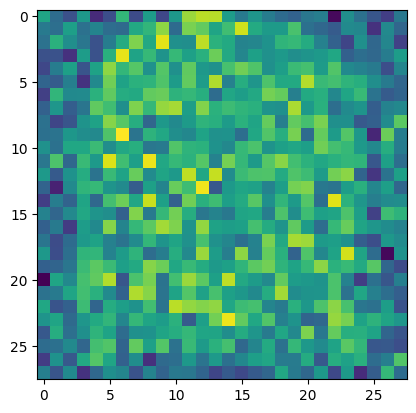

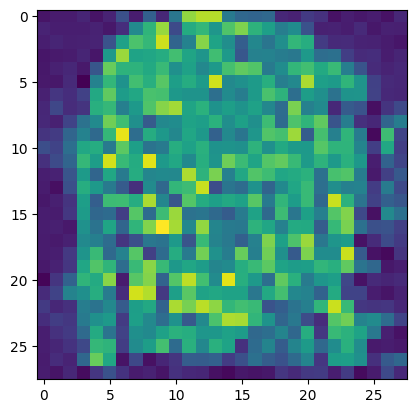

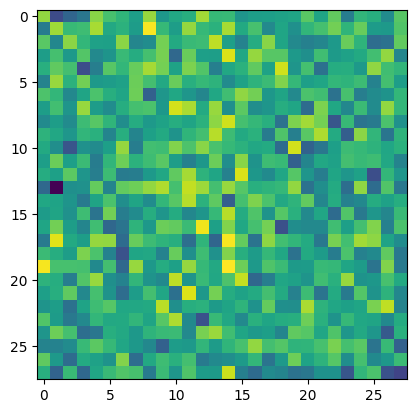

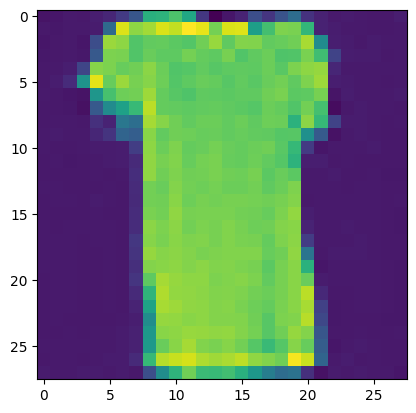

Epoch: 14   Loss: tensor(0.8264, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4130, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0003, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 14  Adversarial Loss:tensor(0.0063, device='cuda:0', grad_fn=<AddBackward0>)


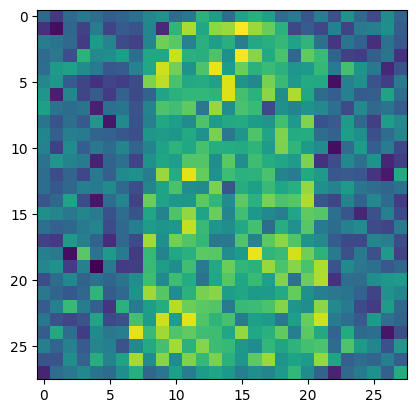

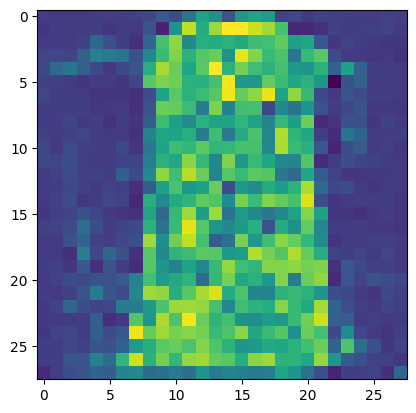

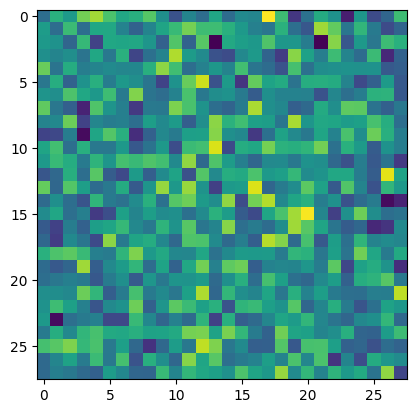

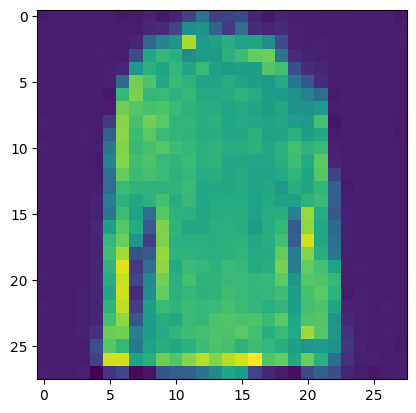

Epoch: 14   Loss: tensor(0.8060, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.3994, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0072, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 14  Adversarial Loss:tensor(0.0085, device='cuda:0', grad_fn=<AddBackward0>)


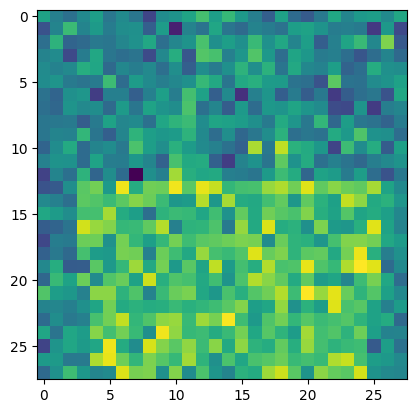

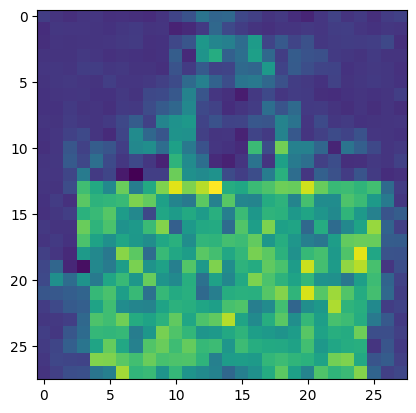

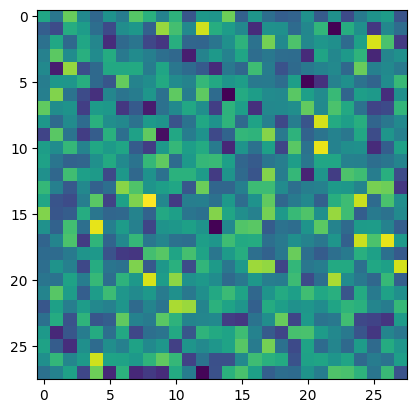

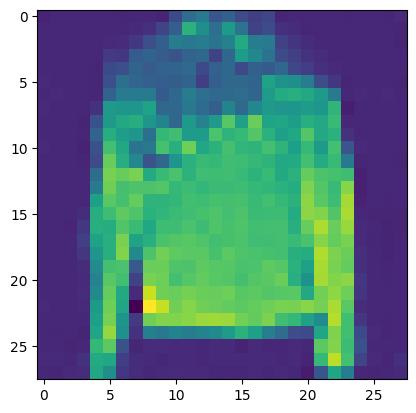

Epoch: 14   Loss: tensor(0.8130, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4050, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0030, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 14  Adversarial Loss:tensor(0.0128, device='cuda:0', grad_fn=<AddBackward0>)


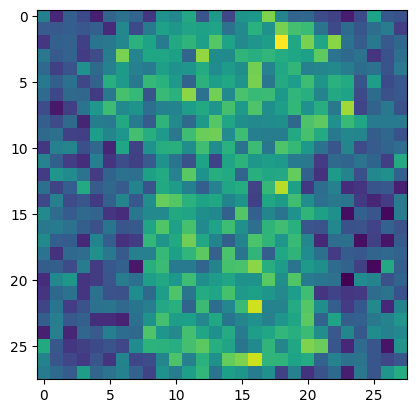

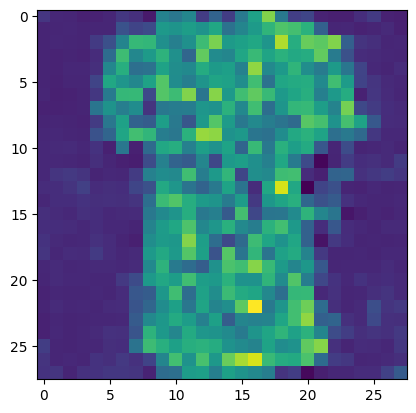

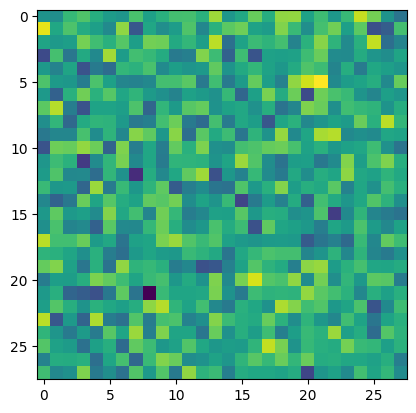

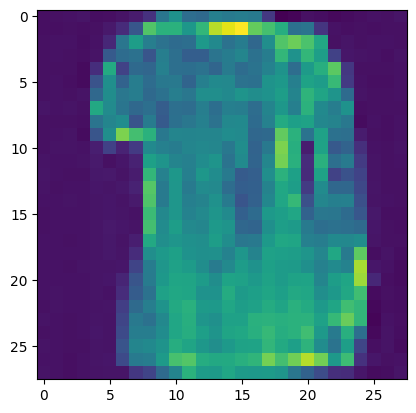

Epoch: 14   Loss: tensor(0.8030, device='cuda:0', grad_fn=<AddBackward0>)   Distillation Loss:tensor(0.4004, device='cuda:0', grad_fn=<MseLossBackward0>)  Adversarial Loss:tensor(0.0023, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
Epoch: 14  Adversarial Loss:tensor(0.0052, device='cuda:0', grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [155]:
epochs = 20
save_and_sample_every = 100
disc_loss = nn.BCELoss()
dis_loss = nn.MSELoss()
l = 2
student_optimizer = Adam(student_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
discriminator_optimizer = Adam(discriminator_model.parameters(), lr=1e-3, betas=(0.9, 0.999))
losses=[]

for epoch in range(epochs):

    for step, batch in enumerate(dataloader):
      if step == 10:
        break

      student_optimizer.zero_grad()
      discriminator_optimizer.zero_grad()
      random_index = random.randint(0, 127)

      batch_size = batch[0].shape[0]
      batch = batch[0].to(device)

      t_student = torch.randint(149, 150, (batch_size,), device=device).long()
      t_teacher = torch.randint(399, 400, (batch_size,), device=device).long()

      noise=torch.randn_like(batch) #crea rumore con la stessa dimensione del batch
      x_noisy_student = q_sample(x_start=batch, t=t_student, noise=noise)

      #SHOW THE ORIGINAL IMAGE
      image_data0 = x_noisy_student[0][random_index].cpu().numpy().reshape(image_size, image_size, channels)

      predicted_noise = student_model(x_noisy_student[0], t_student)

      student_data = sample( student_model, x_noisy_student[0], image_size, timestep=student_timesteps,  batch_size=BATCH_SIZE, channels=channels)

      #SHOW STUDENT RESULT

      image_data1 = student_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

      # Etichette per esempi reali e falsi
      real_labels = torch.ones(BATCH_SIZE, 1).to(device)
      fake_labels = torch.zeros(BATCH_SIZE, 1).to(device)

      output_real = discriminator_model(batch)

      loss_real = disc_loss(output_real, real_labels)
      # Forward pass per esempi falsi
      output_fake = discriminator_model(student_data[-1].detach())  # Detach per evitare di propagare il gradiente al generatore
      loss_fake = disc_loss(output_fake, fake_labels)

        # Calcolo totale della loss
      adversarial_loss = loss_real + loss_fake
      adversarial_loss.backward()
      discriminator_optimizer.step() #aggiorna il discriminator

      print("Epoch: " + str(epoch) , " Adversarial Loss:" + str(adversarial_loss) )

      output_fake = discriminator_model(student_data[-1])
      loss_fake = disc_loss(output_fake, fake_labels)

      noise=torch.randn_like(batch)
      x_noisy_teacher = q_sample(x_start=student_data[-1], t=t_teacher, noise=noise)

       #SHOW THE ORIGINAL IMAGE
      image_data2 = x_noisy_teacher[0][random_index].cpu().numpy().reshape(image_size, image_size, channels)

      teacher_predicted_noise = teacher_model(x_noisy_teacher[0], t_teacher)

      teacher_data = sample( teacher_model, x_noisy_teacher[0], image_size, timestep=teacher_timesteps,  batch_size=BATCH_SIZE, channels=channels)

      #SHOW TEACHER RESULT

      image_data3 = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

      plt.imshow(image_data0)
      plt.show()
      plt.imshow(image_data1)
      plt.show()
      plt.imshow(image_data2)
      plt.show()
      plt.imshow(image_data3)
      plt.show()

      distill_loss = F.mse_loss(student_data[-1].requires_grad_(), teacher_data[-1])
      loss = l*distill_loss + loss_fake
      losses.append(loss)

      print("Epoch: " + str(epoch) + "   Loss:", str(loss), "  Distillation Loss:" + str(distill_loss), " Adversarial Loss:" + str(loss_fake) )

      loss.backward()
      student_optimizer.step()


In [ ]:
print(losses)

In [ ]:
t_teacher = next(iter(dataloader))
teacher_data = sample(teacher_model, t_teacher[0].to(device), image_size=image_size, timestep=500,  batch_size=BATCH_SIZE, channels=channels)

In [ ]:
# show a random one
random_index = random.randint(0, 127)
print(random_index)

image_data = teacher_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

plt.imshow(image_data)
plt.show()

In [145]:
t_student = next(iter(dataloader))
t = torch.randint(0, 100, (128,), device=device).long()
noise=torch.randn_like(t_student[0])
x_noisy_student = q_sample(x_start=t_student[0].to(device), t=t.to(device), noise=noise.to(device))
student_data = sample(student_model, x_noisy_student[0], image_size=image_size, timestep=50,  batch_size=BATCH_SIZE, channels=channels)

97


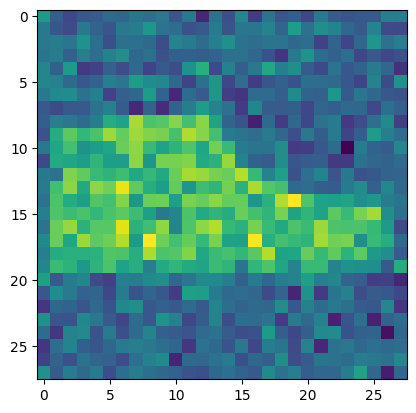

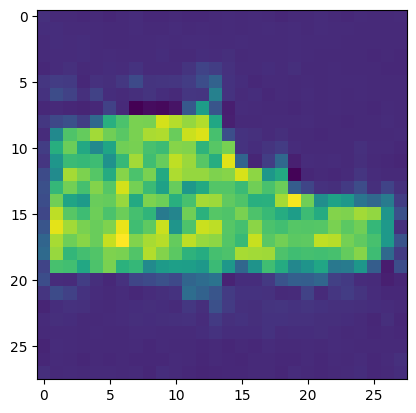

In [146]:
# show a random one
random_index = random.randint(0, 127)
print(random_index)

# Normalizza i dati dell'immagine nel range [0, 1] se sono float

image_data0 = x_noisy_student[0][random_index].cpu().numpy().reshape(image_size, image_size, channels)
image_data = student_data[-1][random_index].cpu().numpy().reshape(image_size, image_size, channels)

plt.imshow(image_data0)
plt.show()
plt.imshow(image_data)
plt.show()
#print(len(samples[-1]))#samples = [200,128,1,28,28]